#### packages and functions

I've truncated the gage testing notebook quite a bit just for convenience, so let me just make sure that the new processing method is well integrated into the old one

In [59]:
from pathlib import Path
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import time
import os
from scipy import signal
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit
from scipy.special import erf
import scipy.io
import colorsys
from scipy import signal
import math
from scipy.stats import norm
import pickle
import os
import pandas as pd

import ipyparams
from e6py import E6math
from e6py import Photontimer
from e6py import smart_gaussian2d_fit
import datetime
import GageSimp as gs
from tqdm import tqdm
from importlib import reload
reload(gs)

<module 'GageSimp' from '\\\\shotnoise-e6\\datavault-e6\\expdata-e6\\data\\2024\\05\\04\\analysis\\GageSimp.py'>

In [60]:
from scipy.interpolate import interp1d

def uniquebin(x, y):
    xbin = np.unique(np.array(x).astype('float'))
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    for i in range(0, len(xbin)):
        ytemplist = y[x == xbin[i]]
        ybin[i] = np.nanmean(ytemplist)
        ybinerr[i] = np.nanstd(ytemplist)
    
    return xbin, ybin, ybinerr

def uniquebin(x, y):
    xbin = np.unique(np.array(x).astype('float'))
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    ybinmean_err = xbin * 0;
    for i in range(0, len(xbin)):
        ytemplist = y[x == xbin[i]]
        ybin[i] = np.nanmean(ytemplist)
        ybinerr[i] = np.nanstd(ytemplist)
        ybinmean_err[i] = ybinerr[i]/np.sqrt(np.sum(x == xbin[i]))
    return xbin, ybin, ybinerr,ybinmean_err


def rabi_oscillation_t(tau,fR,phi,A=1,offset=0):
    return A*np.cos(2*np.pi*tau*fR+phi)+offset


def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

def rabi_oscillation_decoherence(tau=0, fR=3e3, gamma=0, Amp=1, offset=0):
    w=np.exp(-0.5*gamma*tau)*(np.cos(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau)+(gamma/2/np.sqrt(fR**2-(gamma/2)**2))*np.sin(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau))
    return Amp*(1-w)/2+offset

def butter_lowpass_filter(data, cutoff, order):
    b, a = signal.butter(order, cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def exp_fun_2(t,alpha,A=1,B=0):
    return A*np.exp(-2*alpha*t)+B


def exp_fun(t,gamma,A=1,B=0):
    return A*np.exp(-gamma*t)+B

# x_int=np.array([0,0.7 ,0.8, 0.9, 1   ,1.1,  1.2, 1.3,  1.4,  1.5, 1.6,   1.7  ,1.8  ,2.0  ,2.1  ,2.2  ,2.5  ,3  ,3.5, 4  ,4.5,5  ,5.5,6  ,6.5,7.5,8.5,10])
# y_int=np.array([0,0.99,7.18,20.7,41.3,65.3, 90.5,115.4,138.1,159.0,178.5,195.6,210.3,236.7,248.4,258.7,283.8,314,335, 349,361,370,376,383,388,397,402,408])

x_int=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.7,1.8,1.9,2,2.2,2.5,2.75,3,3.25,3.5,4,4.5,5,6,7,8,9,10])
y_int=np.array([0.01,0.05,0.37,1.61,4.6,10.33,19.55,32.62,49.72,70.12,93.72,119.12,145.82,174.32,203.32,232.32,288.52,311.92,
                335.92,355.92,387.92,411.92,421.92,428.92,430.92,433.92,437.92,441.92,442.92,445.92,447.92,449.92,449.92,451.42])
y_int=y_int/np.max(y_int)
power_curve= interp1d(x_int,y_int,kind='slinear')

def ControlV_Power(x,maximum_power=1):
    return maximum_power*power_curve(x)

def double_lorentzian_fit(f, A, B, kappa, gamma, f0):
    return A/(1+(2*(f-f0)/kappa)**2) + B/(1+(2*(f-f0)/gamma)**2)

def lorentzian_fit(f, A, kappa, f0):
    return A/(1+(2*(f-f0)/kappa)**2)

def get_outer_inner_point_product(point_idx, outer_num, inner_num): 
    total_num = outer_num*inner_num
    if point_idx>=total_num:
        print('point_idx is out of range')
        return
    outer_point_idx = point_idx//inner_num
    inner_point_idx = point_idx%inner_num
    return outer_point_idx, inner_point_idx
    

def get_outer_inner_point_parallel(point_idx, outer_num, inner_num): 
    total_num = outer_num*inner_num
    if point_idx>=total_num:
        print('point_idx is out of range')
        return
    outer_point_idx = point_idx%outer_num
    inner_point_idx = point_idx%inner_num
    return outer_point_idx, inner_point_idx

def get_outer_inner_point(point_idx, outer_num, inner_num, parallel=False): 
    if parallel:
        return get_outer_inner_point_parallel(point_idx, outer_num, inner_num)
    else:
        return get_outer_inner_point_product(point_idx, outer_num, inner_num)

1


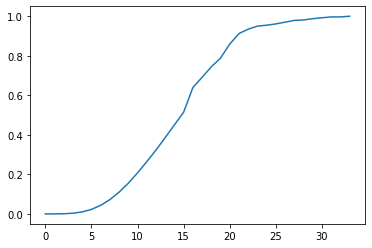

In [61]:
plt.plot(power_curve(x_int))
print(1)

In [62]:
# simulated N scaling
# 512MHz g0=3.1MHz
N_sim=np.array([ 1,  2,  3,  4,  5,  6, 7,  8])

rel_cav_height_10nm_512MHz=np.array([ 1.        ,  3.9932454 ,  8.97666513, 15.94504205, 24.88395339,
       35.800021  , 48.67755505, 63.52935801])
rel_cav_height_130nm_512MHz=np.array([ 1.        ,  3.50127715,  7.53997985, 13.00364974, 20.4688463 ,
       28.4414432 , 38.86101047, 49.20170356])
rel_cav_height_150nm_512MHz=np.array([ 1.        ,  3.24543437,  6.4885979 , 11.24202425, 17.41620041,
       24.46064153, 32.54476083, 41.89095921])

rel_cav_weight_10nm_512MHz=np.array([ 1.        ,  3.99523801,  8.9856586 , 15.96919352, 24.93404818,
       35.88833457, 48.82018323, 63.7452156 ])
rel_cav_weight_130nm_512MHz=np.array([ 1.        ,  3.50267269,  7.54650876, 13.02259644, 20.50677823,
       28.50735218, 38.97035077, 49.3646424 ])
rel_cav_weight_150nm_512MHz=np.array([ 1.        ,  3.24677217,  6.49427329, 11.25711612, 17.4485312 ,
       24.51886691, 32.63516859, 42.02741649])


shift_sim_10nm_512MHz=np.array([-0.01894299, -0.03786727, -0.05680144, -0.07574188, -0.09466694,
       -0.11360509, -0.1325311 , -0.15147438])
shift_sim_130nm_512MHz=np.array([-0.01538429, -0.02865735, -0.04121567, -0.05446417, -0.06770355,
       -0.0797003 , -0.09273594, -0.1045913 ])
shift_sim_150nm_512MHz=np.array([-0.01513781, -0.02757617, -0.03933482, -0.05132907, -0.06360572,
       -0.07492203, -0.0868774 , -0.09839016])

width_sim_10nm_512MHz=np.array([0.53025615, 0.53051427, 0.53077022, 0.53102726, 0.53128471,
       0.53154183, 0.53179986, 0.53205581])
width_sim_130nm_512MHz=np.array([0.530239  , 0.53047341, 0.53070598, 0.53096488, 0.53119116,
       0.53142854, 0.53166353, 0.53188658])
width_sim_150nm_512MHz=np.array([0.53023666, 0.53047224, 0.53070898, 0.53093774, 0.53117223,
       0.53140884, 0.53163139, 0.53187685])


In [63]:
import os
print(os.getcwd())

y:\expdata-e6\data\2024\05\04\analysis


In [64]:
# set cwd
os.chdir('y:/expdata-e6/data/2024/05/04/analysis')

###### Cavity Fluorescence 

## Load data

### User input section

In [65]:
########################### User input section ############################

user_dict = {'run_name': 'run2',
             'override_num_shots': False,
             'reset_hard': True,
             'num_shots_manual': 286,
             'num_frames': 3,
             'point_name_inner': 'delta_pc (MHz)',
             'point_name_outer': 'pump power (uW)',
             'point_list_outer': ControlV_Power(np.array([0.8,0.9,1,1.1,1.2,1.3]), 150),
             'point_list_inner': np.array([-2.45,-2.3,-2.15,-2,-1.85,-1.7,-1.55]),
             'point_parallel': False,
             'tweezer_freq_list': 88 + 0.8*0 + 0.8*np.arange(40)}

if len(user_dict['point_list_inner'])==1:
    outer_zoom_factor = 1
else:
    outer_zoom_factor=10

atom_site = []
for i in range(user_dict['num_frames']):
    atom_site.append(np.arange(len(user_dict['tweezer_freq_list'])))

num_points_inner = len(user_dict['point_list_inner'])
num_points_outer = len(user_dict['point_list_outer'])
if num_points_inner == 1:
    point_list = np.array(user_dict['point_list_outer'])
elif user_dict['point_parallel'] == False:
    point_list = (outer_zoom_factor*np.outer(user_dict['point_list_outer'],
                                             np.ones(len(user_dict['point_list_inner']))) 
                                             + np.outer(np.ones(len(user_dict['point_list_outer'])),
                                                        user_dict['point_list_inner'])).flatten()
elif user_dict['point_parallel'] == True:
    point_list = np.arange(num_points_outer*num_points_inner)
    plt.plot(point_list)
num_points = len(point_list)

In [66]:
ControlV_Power(np.array([0.6]), 138)*8.8167**2/80/4

array([1.45180137])

In [67]:
ControlV_Power(np.array([1]), 444)

array([92.1795224])

### Check for file number mismatch gitch

In [68]:
photon_timer_const = {'datastream_name': 'PhotonTimer',
                      'working_path': Path('C:/', 'Users', 'CavityQED', 'Desktop', 'PT_test',str(Path.cwd().parent)[-10:-6], str(Path.cwd().parent)[-5:-3], str(Path.cwd().parent)[-2:]),
                      'file_prefix': 'PTPhotonTimer',
                      'file_suffix': '.bin'}

data_path_fpga = photon_timer_const['working_path']/'data'/user_dict['run_name']/photon_timer_const['datastream_name']
print(data_path_fpga)
opal_path, opal_dirs, opal_files = next(os.walk( data_path_fpga ))
photon_timer_const['num_shots'] = len(opal_files)
photon_timer_const['data_path'] = data_path_fpga

C:\Users\CavityQED\Desktop\PT_test\2024\05\04\data\run2\PhotonTimer


StopIteration: 

In [69]:
quiet = False
plot_true = True

jkam_dict = {'datastream_name': 'jkam_parallel',
             'working_path': Path("y:/expdata-e6/data/2024/05/04"),
             'file_prefix': 'jkam_capture',
             'num_shot_start': 0}

data_path = jkam_dict['working_path']/'data'/user_dict['run_name']/jkam_dict['datastream_name']
path, dirs, files = next(os.walk(data_path))

jkam_const = gs.gen_jkam_constants(user_dict, 
                                       jkam_dict, 
                                       outer_zoom_factor,
                                       atom_site,
                                       num_points_inner,
                                       num_points_outer,
                                       point_list,
                                       num_points)

jkam_mask_dict = gs.gen_jkam_mask_info(jkam_dict, jkam_const)

run_name = user_dict['run_name']
override_num_shots = user_dict['override_num_shots']
reset_hard = user_dict['reset_hard']
num_shots_manual = user_dict['num_shots_manual']
num_frames = user_dict['num_frames']
num_shot_start = jkam_dict['num_shot_start']
file_prefix = jkam_dict['file_prefix']
tweezer_freq_list = user_dict['tweezer_freq_list']
num_tweezers = len(tweezer_freq_list)

num_points=42, num_loops=10
num_shots=401
Gathering JKAM creation times...


  0%|          | 0/401 [00:00<?, ?it/s]

In [ ]:
mask_valid_data_fpgaR, jkam_fpgaR_matchlist, fpgaR_index_list = gs.gen_jkam_masks(jkam_mask_dict, jkam_dict, jkam_const, photon_timer_const)

### Load from red opal kelly

In [13]:
plot_fig = True
start = time.time()

# datastream_name='PhotonTimer'
# working_path = Path.cwd().parent
# data_path_fpga = working_path/'data'/run_name/datastream_name
# file_prefix='PTPhotonTimer'

threshold=2
box=1

frame_num = 0
unit_time_PT = 1/700 #us 

# path, dirs, files = next(os.walk(data_path_fpga))
# num_shot_start = 0
# num_shots_opal = len(files)
# num_shots = num_shots_opal
# num_shots = num_shots_opal


# if override_num_shots:
#     num_shots = num_shots_manual
    
try:
    num_shots_loaded = len(np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True))
except FileNotFoundError:
    num_shots_loaded = 0
    
PT_cavity_photoncount_array=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array[:] = np.NaN
PT_cavity_photoncount_array_raw=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array_raw[:] = np.NaN
PT_cavity_timestamp_array_raw = np.empty(num_shots, dtype=object)
#################################################################
if reset_hard:
    print(f'loading {num_shots} shots from PT raw data')

    for shot_num in range(num_shots):
        if shot_num%100 == 0:
            print(f'shot{shot_num} done')
        if mask_valid_data[shot_num]:   
            file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
            with open(data_path_fpga/file_name, 'rb') as f:

                bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                # events, events_malformed = te.parse(bin_data) # numba version
    #             print(len(bin_data))
                events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                # print(events[4])
            timestamps = np.sort(events[4])
            PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
        else:
            PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
    with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
         pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
#########################################################################################
else:
    print(f'loading {num_shots_loaded} shots from PT pickle file')
    try:
        PT_cavity_timestamp_array_raw[:num_shots_loaded] = np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')
    except:
        print('first time run')
    
    if (num_shots > num_shots_loaded):
        print(f'loading {num_shots_loaded} to {num_shots} shots from raw data')
        for shot_num in range(num_shots_loaded, num_shots):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
                
            if mask_valid_data[shot_num]:
                file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
                timestamps = np.sort(events[4])
                PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
            else:
                PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
            
        with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
    
    

print(f"time elapsed {time.time()-start} s")




loading 15391 shots from PT pickle file
done
done
time elapsed 4.161908864974976 s


### Load from silver opal kelly

In [14]:
# plot_fig = True
# start = time.time()

# datastream_name='PhotonTimer_Silver'
# # working_path = Path.cwd().parent
# working_path = Path('C:/', 'Users', 'CavityQED', 'Desktop', 'PT_test',str(Path.cwd().parents[0])[-10:-6],
#                     str(Path.cwd().parents[0])[-5:-3],str(Path.cwd().parents[0])[-2:])
# data_path_fpga = working_path/'data'/run_name/datastream_name
# silver_file_prefix='PTPhotonTimer_Silver'
# silver_creation_time_array =  np.zeros(num_shots)

# opal_path, opal_dirs, opal_files = next(os.walk( data_path_fpga ))

# num_shots_fpga=len(opal_files)

# for shot_num in range(num_shots):
#     if shot_num<num_shots_fpga:
#         file_name = silver_file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
#         silver_creation_time_array[shot_num] = os.path.getctime(data_path_fpga/file_name)
#         if shot_num%1000 ==0:
#             print(shot_num)

# #Check data matching
# mask_valid_data_silver=np.zeros(len(jkam_creation_time_array))>1
# jkam_fpga_matchlist_silver=np.zeros(len(jkam_creation_time_array),dtype='int')-1
# fpga_index_list=np.arange(len(silver_creation_time_array))

# for shot_num in range(num_shots):
#     time_temp=jkam_creation_time_array[shot_num]
#     space_correct=True
#     if (shot_num>0) & (np.abs(time_temp-jkam_creation_time_array[shot_num-1]-avg_time_gap)>0.3*avg_time_gap): space_correct=False
#     if (shot_num<(num_shots-1)):
#         if (np.abs(-time_temp+jkam_creation_time_array[shot_num+1]-avg_time_gap)>0.3*avg_time_gap): space_correct=False
            
#     if ((np.min(np.abs(silver_creation_time_array-time_temp)) <= 0.2*avg_time_gap)) & space_correct:
#         mask_valid_data_silver[shot_num]=True
#         jkam_fpga_matchlist_silver[shot_num]=fpga_index_list[np.argmin(np.abs(silver_creation_time_array-time_temp))]
#     else:
#         print(f'error at {shot_num:d}')
#     if shot_num%1000 ==0:
#             print(shot_num)


# threshold=2
# box=1

# frame_num = 0
# unit_time_PT = 1/700 #us 

# # path, dirs, files = next(os.walk(data_path_fpga))
# # num_shot_start = 0
# # num_shots_opal = len(files)
# # num_shots = num_shots_opal
# # num_shots = num_shots_opal


# # if override_num_shots:
# #     num_shots = num_shots_manual
    
# try:
#     num_shots_loaded = len(np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True))
# except FileNotFoundError:
#     num_shots_loaded = 0
    
# silver_PT_cavity_photoncount_array=np.zeros((num_shots, num_frames))
# silver_PT_cavity_photoncount_array[:] = np.NaN
# silver_PT_cavity_photoncount_array_raw=np.zeros((num_shots, num_frames))
# silver_PT_cavity_photoncount_array_raw[:] = np.NaN
# silver_PT_cavity_timestamp_array_raw = np.empty(num_shots, dtype=object)
# #################################################################
# if reset_hard:
#     print(f'loading {num_shots} shots from PT raw data')

#     for shot_num in range(num_shots):
#         if shot_num%100 == 0:
#             print(f'shot{shot_num} done')
#         if mask_valid_data_silver[shot_num]:   
#             file_name = silver_file_prefix+'_'+str(jkam_fpga_matchlist_silver[shot_num]).zfill(5)+'.bin'
#             with open(data_path_fpga/file_name, 'rb') as f:

#                 bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
#                 # events, events_malformed = te.parse(bin_data) # numba version
#     #             print(len(bin_data))
#                 events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
#                 # print(events[4])
#             timestamps = np.sort(events[4])
#             silver_PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
#         else:
#             silver_PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
#     with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
#          pickle.dump(silver_PT_cavity_timestamp_array_raw, f1)
          
#     print('done')
# #########################################################################################
# else:
#     print(f'loading {num_shots_loaded} shots from PT pickle file')
#     try:
#         silver_PT_cavity_timestamp_array_raw[:num_shots_loaded] = np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True)
#         print('done')
#     except:
#         print('first time run')
    
#     if (num_shots > num_shots_loaded):
#         print(f'loading {num_shots_loaded} to {num_shots} shots from raw data')
#         for shot_num in range(num_shots_loaded, num_shots):
#             if shot_num%100 == 0:
#                 print(f'shot{shot_num} done')
                
#             if mask_valid_data_silver[shot_num]:
#                 file_name = silver_file_prefix+'_'+str(jkam_fpga_matchlist_silver[shot_num]).zfill(5)+'.bin'
#                 with open(data_path_fpga/file_name, 'rb') as f:

#                     bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
#                     # events, events_malformed = te.parse(bin_data) # numba version
#         #             print(len(bin_data))
#                     events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
#                     # print(events[4])
#                 timestamps = np.sort(events[4])
#                 silver_PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
#             else:
#                 silver_PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
            
#         with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
#              pickle.dump(silver_PT_cavity_timestamp_array_raw, f1)
          
#     print('done')
    
    

# print(f"time elapsed {time.time()-start} s")




In [15]:
# plt.plot(jkam_fpga_matchlist_silver)

### Load from silver opal kelly

In [16]:
# plot_fig = False

# load_silver = False

# override_num_shot_silvers= override_num_shots

# num_shot_silvers_manual=num_shots_manual

# file_read_every=10

# if load_silver:

#     start = time.time()

#     datastream_name='PhotonTimer_Silver'
#     working_path = Path.cwd().parent
#     data_path_fpga = working_path/'data'/run_name/datastream_name
#     file_prefix='PTPhotonTimer_Silver'

#     # axialPD_avg_array = np.zeros(num_shot_silvers)
#     # axialPD_avg_array[:] = np.NaN
#     # axialPD_sigma_array = np.zeros(num_shot_silvers)
#     # axialPD_sigma_array[:] = np.NaN
#     # step_start = 15000
#     # step_end = 25000
#     threshold=2
#     box=1
#     cumulative_file_offset = 0
#     frame_num = 0
#     unit_time_PT = 1/700 #us


#     path, dirs, files = next(os.walk(data_path_fpga))
#     # num_shot_silvers = 600
#     num_shot_silver_start = 0
#     num_shot_silvers_fpga = len(files)
#     num_shot_silvers = num_shot_silvers_fpga
#     # num_shot_silvers = num_shot_silvers_fpga
#     if override_num_shot_silvers:
#         num_shot_silvers = num_shot_silvers_manual

#     try:
#         num_shots_loaded = len(np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True))
#     except FileNotFoundError:
#         num_shots_loaded = 0

#     #################################################################
#     if num_shot_silvers != num_shots_loaded or reset_hard:

#         print(f'loading {num_shot_silvers} shots from PT raw data')
#         PT_cavity_photoncount_array=np.zeros((num_shot_silvers, num_frames))
#         PT_cavity_photoncount_array[:] = np.NaN
#         PT_cavity_photoncount_array_raw=np.zeros((num_shot_silvers, num_frames))
#         PT_cavity_photoncount_array[:] = np.NaN
#     #     PT_cavity_timestamp_array = np.empty((num_shot_silvers, num_frames), dtype=object)
#         Silver_PT_cavity_timestamp_array_raw = np.empty(num_shot_silvers, dtype=object)

#         for shot_num in range(num_shot_silvers):
#             if shot_num%100 == 0:
#                 print(f'shot{shot_num} done')

#             file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
#             if (shot_num % file_read_every)==0:
#                 with open(data_path_fpga/file_name, 'rb') as f:

#                     bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
#                     # events, events_malformed = te.parse(bin_data) # numba version
#         #             print(len(bin_data))
#                     events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
#                     # print(events[4])
#             timestamps = np.sort(events[4])
#             Silver_PT_cavity_timestamp_array_raw[shot_num-cumulative_file_offset]  = unit_time_PT * timestamps

#         with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
#              pickle.dump(Silver_PT_cavity_timestamp_array_raw, f1)

#         print('done')
#     #########################################################################################
#     else:
#         print(f'loading {num_shots_loaded} shots from Silver PT pickle file')
#         Silver_PT_cavity_timestamp_array_raw = np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True)
#         print('done')


#     print(f"time elapsed {time.time()-start} s")

In [17]:
A=[0,3,4]
B=np.copy(A)
B


array([0, 3, 4])

In [18]:
red_pfs = False
if red_pfs:
    n_list = []
    t_prep = 100
    f_sweep_start = -2
    t_sweep = 2e3
    f_sweep_end = 2
    f0_array = np.zeros(num_shots)
    f0_array[:] = np.NaN
    for shot_num in range(num_shots):

        try:
            pfs_freq = PT_cavity_timestamp_array_raw[shot_num] - t_prep
            pfs_freq = f_sweep_start+(pfs_freq/t_sweep)*(f_sweep_end-f_sweep_start)
            bins=20
            bin_time = t_sweep/bins
            n, bins = np.histogram(pfs_freq, bins=bins)
            n_list.append(n)

            x_sample = np.arange(f_sweep_start, f_sweep_end, 0.01)
            popt, pcov = curve_fit(E6math.CauchyNoOffset, (bins[1:]+bins[:-1])/2,n/bin_time, p0=(1,1000,0))
        #     print(f'shot#={shot_num}, f0={popt[2]:5.3f}MHz')
            f0_array[shot_num] = popt[2]
        except:
            f0_array[shot_num] = np.nan
        
        # if shot_num==0:
        #     plt.plot((bins[1:]+bins[:-1])/2,n,'o-')
        #     plt.xlabel('probe_freq_offset_MHz',fontsize=12)
        #     plt.ylabel('photon counts',fontsize=12)
    plt.plot((bins[1:]+bins[:-1])/2,np.nanmean(n_list,axis=0),'o-')
    plt.xlabel('probe_freq_offset_MHz',fontsize=12)
    plt.ylabel('photon counts',fontsize=12)
    plt.title('averaged spectrum') 
#     plt.figure(figsize=(10,5))
#     bins=50
#     plt.hist(f0_array, alpha=0.5, color='b', bins=bins)
#     plt.ylabel('occurence')
#     plt.xlabel('delta_PC_zero')

    f0_whole_run = np.nanmean(f0_array)
    print(f'averaged f0 = {f0_whole_run}')

    filtered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.1, order=2)
    slowfiltered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.02, order=2)

    plt.figure(figsize=(10,5))
    bins=50
    plt.plot(np.arange(num_shots),f0_array)
    plt.plot(np.arange(num_shots),filtered_f0_array)
    plt.plot(np.arange(num_shots),slowfiltered_f0_array)
    plt.xlabel('shot#')
    plt.ylabel('delta_PC_zero')
#     plt.ylim(-5,5)
#     plt.xlim(-5,5)

In [19]:
# ### Haven't updated the file offset correction on the silver opal #TO DO

# if load_silver:

#     t_prep = 100
#     f_sweep_start = -2
#     t_sweep = 2e3
#     f_sweep_end = 2
#     f0_array = np.zeros(num_shot_silvers)
#     f0_array[:] = np.NaN
#     for shot_num in range(num_shot_silvers):

#         try:
#             pfs_freq = Silver_PT_cavity_timestamp_array_raw[shot_num] - t_prep
#             pfs_freq = f_sweep_start+(pfs_freq/t_sweep)*(f_sweep_end-f_sweep_start)
#             bins=20
#             bin_time = t_sweep/bins
#             n, bins = np.histogram(pfs_freq, bins=bins)

#             x_sample = np.arange(f_sweep_start, f_sweep_end, 0.01)
#             popt, pcov = curve_fit(E6math.CauchyNoOffset, (bins[1:]+bins[:-1])/2,n/bin_time, p0=(1,1000,0))
#         #     print(f'shot#={shot_num}, f0={popt[2]:5.3f}MHz')
#             f0_array[shot_num] = popt[2]
#         except:
#             f0_array[shot_num] = np.nan
        
#         if shot_num==0:
#             plt.plot((bins[1:]+bins[:-1])/2,n,'o-')
#             plt.xlabel('probe_freq_offset_MHz',fontsize=12)
#             plt.ylabel('photon counts',fontsize=12)
# #     plt.figure(figsize=(10,5))
# #     bins=50
# #     plt.hist(f0_array, alpha=0.5, color='b', bins=bins)
# #     plt.ylabel('occurence')
# #     plt.xlabel('delta_PC_zero')

#     f0_whole_run = np.nanmean(f0_array)
#     print(f'averaged f0 = {f0_whole_run}')

#     filtered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.1, order=2)
#     slowfiltered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.02, order=2)

#     plt.figure(figsize=(10,5))
#     bins=50
#     plt.plot(np.arange(num_shot_silvers),f0_array)
#     plt.plot(np.arange(num_shot_silvers),filtered_f0_array)
#     plt.plot(np.arange(num_shot_silvers),slowfiltered_f0_array)
#     plt.xlabel('shot#')
#     plt.ylabel('delta_PC_zero')
# #     plt.ylim(-5,5)
# #     plt.xlim(-5,5)

### ROI user input and load JKAM data

In [36]:
roi_width = 16
roi_height = 16
roi_area = roi_width * roi_width

def roi_center(tweezer_freq):
    center_x = round(2 * (0.01 * (tweezer_freq - 108)**2+ 26.8 * (tweezer_freq - 100) + 414)) / 2
    center_y = round(2 * (-0.5 * (tweezer_freq - 100) + 28)) / 2
    return [center_x, center_y]

def roi_slice_func(tweezer_freq):
    center_x = roi_center(tweezer_freq)[0]
    center_y = roi_center(tweezer_freq)[1]
    return tuple((slice(round(center_y - roi_height / 2), round(center_y + roi_height / 2), 1), \
                  slice(round(center_x - roi_width / 2), round(center_x + roi_width / 2), 1)))

start = time.time()

quiet = False
plot_true = True
datastream_name=jkam_dict['datastream_name']
working_path = jkam_dict['working_path']
data_path = working_path/'data'/run_name/datastream_name
file_prefix=jkam_dict['file_prefix']
path, dirs, files = next(os.walk(data_path))

num_shot_start = 0
if override_num_shots:
    num_shots = num_shots_manual
try:
    num_shots_loaded = len(np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True))
except FileNotFoundError:
    num_shots_loaded = 0

num_shots = len(files)
if num_shots != num_shots_loaded or reset_hard:
    print(f'loading {num_shots} shots from raw data')
    counts_array = np.empty([num_shots, num_frames, num_tweezers])
    frames_array = np.zeros([num_frames,80,1100])
#     image_array = [[[None for _ in range(num_tweezers)] for _ in range(num_frames)] for _ in range(num_shots)]
    for shot_num in tqdm(range(num_shot_start, num_shot_start+num_shots)):
        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        hf = h5py.File(data_path/file_name, 'r')
        point = shot_num % num_points
        for frame_num in range(num_frames):
            photo = np.array(hf.get('frame-'+str(frame_num+2).zfill(2)))
            tweezer_freq_counter = 0     
            for tweezer_freq in tweezer_freq_list:
#                 image_array[shot_num-num_shot_start][frame_num][tweezer_freq_counter]= np.array(photo[roi_slice_func(tweezer_freq)],dtype='int32')
                counts_array[shot_num-num_shot_start, frame_num, tweezer_freq_counter] = np.sum(photo[roi_slice_func(tweezer_freq)])
                tweezer_freq_counter += 1

            frames_array[frame_num] += photo

            if plot_true == False: 
                if frame_num == 5:
                    vmin = 105
                    vmax = 140

                    fig,ax = plt.subplots(1, 1,figsize=(10, 10) )
                    ax.imshow(photo, norm = colors.Normalize(vmin=vmin,vmax=vmax), cmap='hot', interpolation='nearest')
                    for tweezer_freq in tweezer_freq_list:
                        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
                        ax.add_patch(rect1)
                    plt.show()
                    print(counts_array[shot_num-num_shot_start, frame_num])

        hf.close
    frames_array = frames_array/num_shots*num_points
    
    with open(f'{run_name}_jkam_counts_array.pkl','wb') as f1:
         pickle.dump(counts_array, f1)
    with open(f'{run_name}_jkam_frames_array.pkl','wb') as f2:
         pickle.dump(frames_array, f2)
#     with open(f'{run_name}_jkam_images_array.pkl','wb') as f3:
#          pickle.dump(image_array, f3)
            
    print('done')
else:
    print(f'loading { num_shots_loaded} shots from pickle file')
    counts_array = np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True)
    frames_array = np.load(f'{run_name}_jkam_frames_array.pkl', allow_pickle=True)
#     image_array = np.load(f'{run_name}_jkam_images_array.pkl', allow_pickle=True)
    print('done')

print(f"time elapsed {time.time()-start} s")

loading 401 shots from raw data


100%|██████████| 401/401 [00:42<00:00,  9.48it/s]


done
time elapsed 42.680073738098145 s


In [30]:
roi_center(tweezer_freq_list[-2])

[908.0, 19.0]

### load from GaGe scope

In [40]:
gen_constant_dict = {'voltage_conversion': 1000/32768,
                        'kappa': 2 * np.pi * 1.1,
                        'LO_power': 314,
                        'PHOTON_ENERGY': 2.55e-19}

gage_constant_dict = {'reset_gage': reset_hard,
                            'window': 'hann',
                            'num_segments': 3,
                            'plot_tenth_shot': True,
                            'het_freq': 20.000446, # MHz
                            'dds_freq': 20.00446/2,
                            'samp_freq': 200, # MHz
                            'step_time': 5, # us
                            'filter_time': 5, # us
                            'datastream_name': 'gage',
                            'working_path': Path('y:/expdata-e6/data/2024/05/04'),
                            'run_name': 'run2',
                            'file_prefix': 'gage_shot',
                            'file_suffix': '.h5'}

Gathering target device creation times...


  0%|          | 0/401 [00:00<?, ?it/s]

Matching JKAM and target device data


  0%|          | 0/401 [00:00<?, ?it/s]

Hard reset, loading 401 shots from gage raw data
Processing raw gage files...


  0%|          | 0/401 [00:00<?, ?it/s]

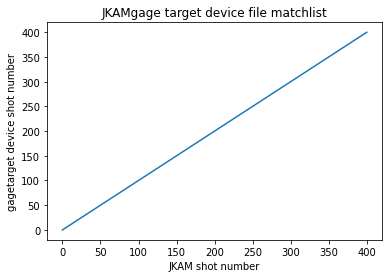

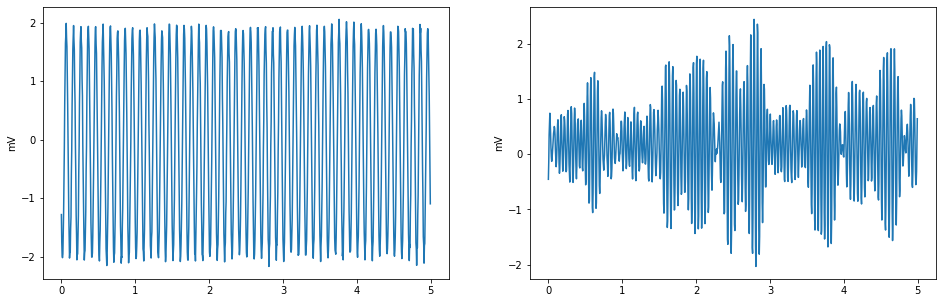

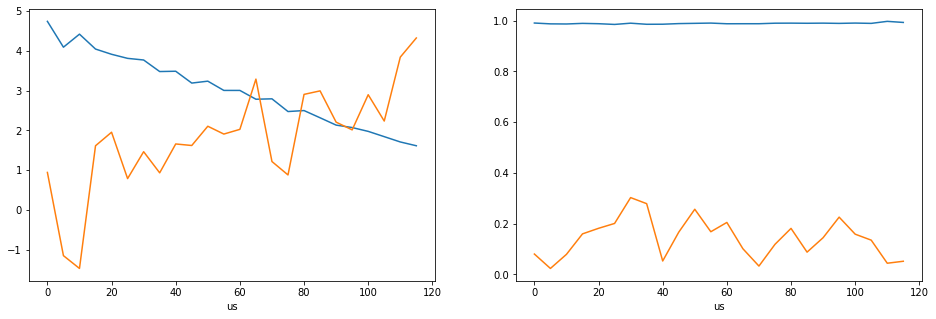

done
number of 401 shots loaded


In [51]:
reload(gs)

gs.perform_gage_demod(user_constants_dict=user_dict,
                 arb_constant_dict = gen_constant_dict,
                 gage_constant_dict = gage_constant_dict,
                 jkam_dict = jkam_dict,
                 jkam_mask_dict = jkam_mask_dict,
                 outer_zoom_factor = outer_zoom_factor,
                 num_points_inner = num_points_inner,
                 num_points_outer = num_points_outer,
                 point_list = point_list,
                 num_points = num_points,
                 atom_site = atom_site,
                 num_shots_jkam = num_shots)

gage_constant_dict = gs.gen_gage_constants(gen_constant_dict, gage_constant_dict, jkam_const)

### Load from position feedback RedPitaya

  0%|          | 0/401 [00:00<?, ?it/s]

0


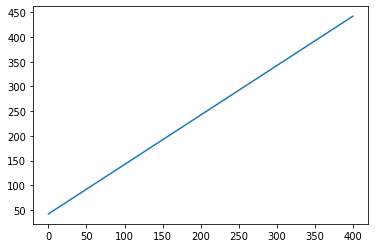

In [54]:
reload(gs)
load_RP=True

if load_RP:
    datastream_name='Redpitaya'
    working_path = Path.cwd().parent
    data_path = working_path/'data'/run_name/datastream_name

    cav_contrast = np.loadtxt(data_path/"cnstcav.txt", dtype=float, delimiter=',')
    perp_contrast = np.loadtxt(data_path/"cnstperp.txt", dtype=float, delimiter=',')
    cav_hist = np.loadtxt(data_path/"histcav.txt", dtype=float, delimiter=',')
    perp_hist = np.loadtxt(data_path/"histperp.txt", dtype=float, delimiter=',')
    cav_len = np.loadtxt(data_path/"lencav.txt", dtype=float, delimiter=',')
    perp_len = np.loadtxt(data_path/"lenperp.txt", dtype=float, delimiter=',')
    cav_output = np.loadtxt(data_path/"outcav.txt", dtype=float, delimiter=',')
    perp_output = np.loadtxt(data_path/"outperp.txt", dtype=float, delimiter=',')
    cav_phase = np.loadtxt(data_path/"phicav.txt", dtype=float, delimiter=',')
    perp_phase = np.loadtxt(data_path/"phiperp.txt", dtype=float, delimiter=',')
    
    
    # check file mismatch for RP
    rp_creation_time_array = cav_phase[:,0]
    mask_valid_data_rp, jkam_rp_matchlist, rp_index_list = gs.RP_jkam_masks(jkam_mask_dict, jkam_dict, jkam_const, rp_creation_time_array)

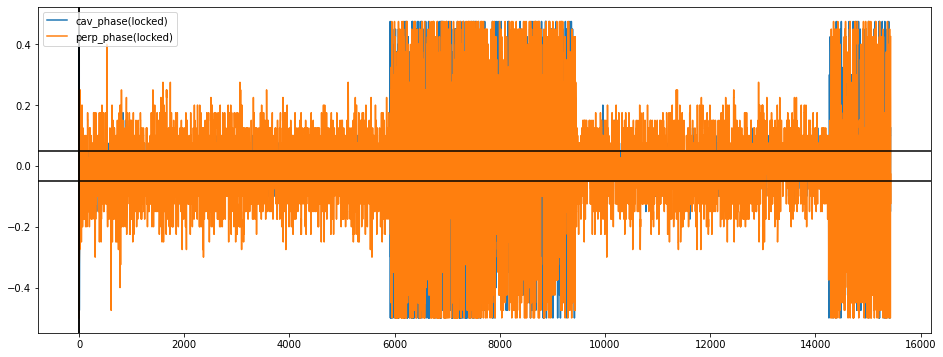

In [55]:
if load_RP:
    plt.figure(figsize=(16,6))
    plt.plot(cav_phase[:,1],label="cav_phase(locked)")
    plt.plot(perp_phase[:,1],label="perp_phase(locked)")
    plt.axhline(0.05,c='k')
    plt.axhline(-0.05,c='k')
    plt.axvline(num_shot_start,c='k')
    # plt.xlim(0,500)
    plt.axvline(num_shot_start,c='k')
    plt.legend()

In [56]:
if load_RP:
    cav_phase_matched = np.empty(jkam_mask_dict['num_shots'])
    perp_phase_matched = np.empty(jkam_mask_dict['num_shots'])
    cav_len_matched = np.empty(jkam_mask_dict['num_shots'])
    perp_len_matched = np.empty(jkam_mask_dict['num_shots'])
    
    for shot_num in range(jkam_mask_dict['num_shots']):
        cav_phase_matched[shot_num] = cav_phase[jkam_rp_matchlist[shot_num],1]
        perp_phase_matched[shot_num] = perp_phase[jkam_rp_matchlist[shot_num],1]
        cav_len_matched[shot_num] = cav_len[jkam_rp_matchlist[shot_num],1]
        perp_len_matched[shot_num] = perp_len[jkam_rp_matchlist[shot_num],1]


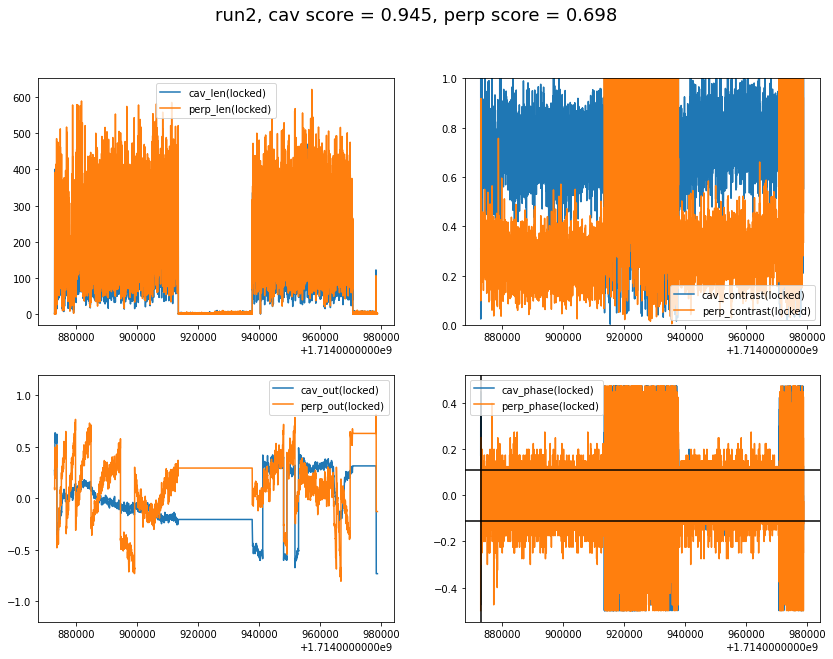

In [57]:
if load_RP:
    num_shot_start = 0

    mask_TPF = (np.abs(cav_phase_matched)<0.081) & (np.abs(perp_phase_matched)<0.11) & (cav_len_matched>10) & (perp_len_matched>10) 
    num_shots_rp = len(cav_phase_matched)
    mask_rp_temp = mask_valid_data_rp[:num_shots_rp]
    cav_score = len(cav_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp][abs(cav_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp])<0.081])/len(cav_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp])
    perp_score = len(perp_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp][abs(perp_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp])<0.11])/len(perp_phase_matched[:jkam_mask_dict['num_shots']][mask_rp_temp])

    fig,axs=plt.subplots(ncols=2,nrows=2,figsize=[14,10])

    fig.suptitle(f'{run_name}, cav score = {cav_score:.3f}, perp score = {perp_score:.3f}',fontsize=18)

    plt.sca(axs[0,0])
    plt.plot(cav_len[:,0],cav_len[:,1],label="cav_len(locked)")
    plt.plot(perp_len[:,0],perp_len[:,1],label="perp_len(locked)")
    # plt.ylim(0,1)
    plt.legend()

    plt.sca(axs[0,1])
    plt.plot(cav_contrast[:,0],cav_contrast[:,1],label="cav_contrast(locked)")
    plt.plot(perp_contrast[:,0],perp_contrast[:,1],label="perp_contrast(locked)")
    plt.ylim(0,1)
    plt.legend()

    plt.sca(axs[1,0])
    plt.plot(cav_output[:,0],cav_output[:,1],label="cav_out(locked)")
    plt.plot(perp_output[:,0],perp_output[:,1],label="perp_out(locked)")
    plt.ylim(-1.2,1.2)
    plt.legend()

    plt.sca(axs[1,1])
    plt.plot(cav_phase[:,0],cav_phase[:,1],label="cav_phase(locked)")
    plt.plot(perp_phase[:,0],perp_phase[:,1],label="perp_phase(locked)")
    plt.axhline(0.11,c='k')
    plt.axhline(-0.11,c='k')
    plt.axvline(cav_phase[num_shot_start,0],c='k')
    plt.legend()

In [58]:
if load_RP == False:
    mask_TPF = np.ones(jkam_mask_dict['num_shots'])>0

## Select data

##### User input section

[400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.]


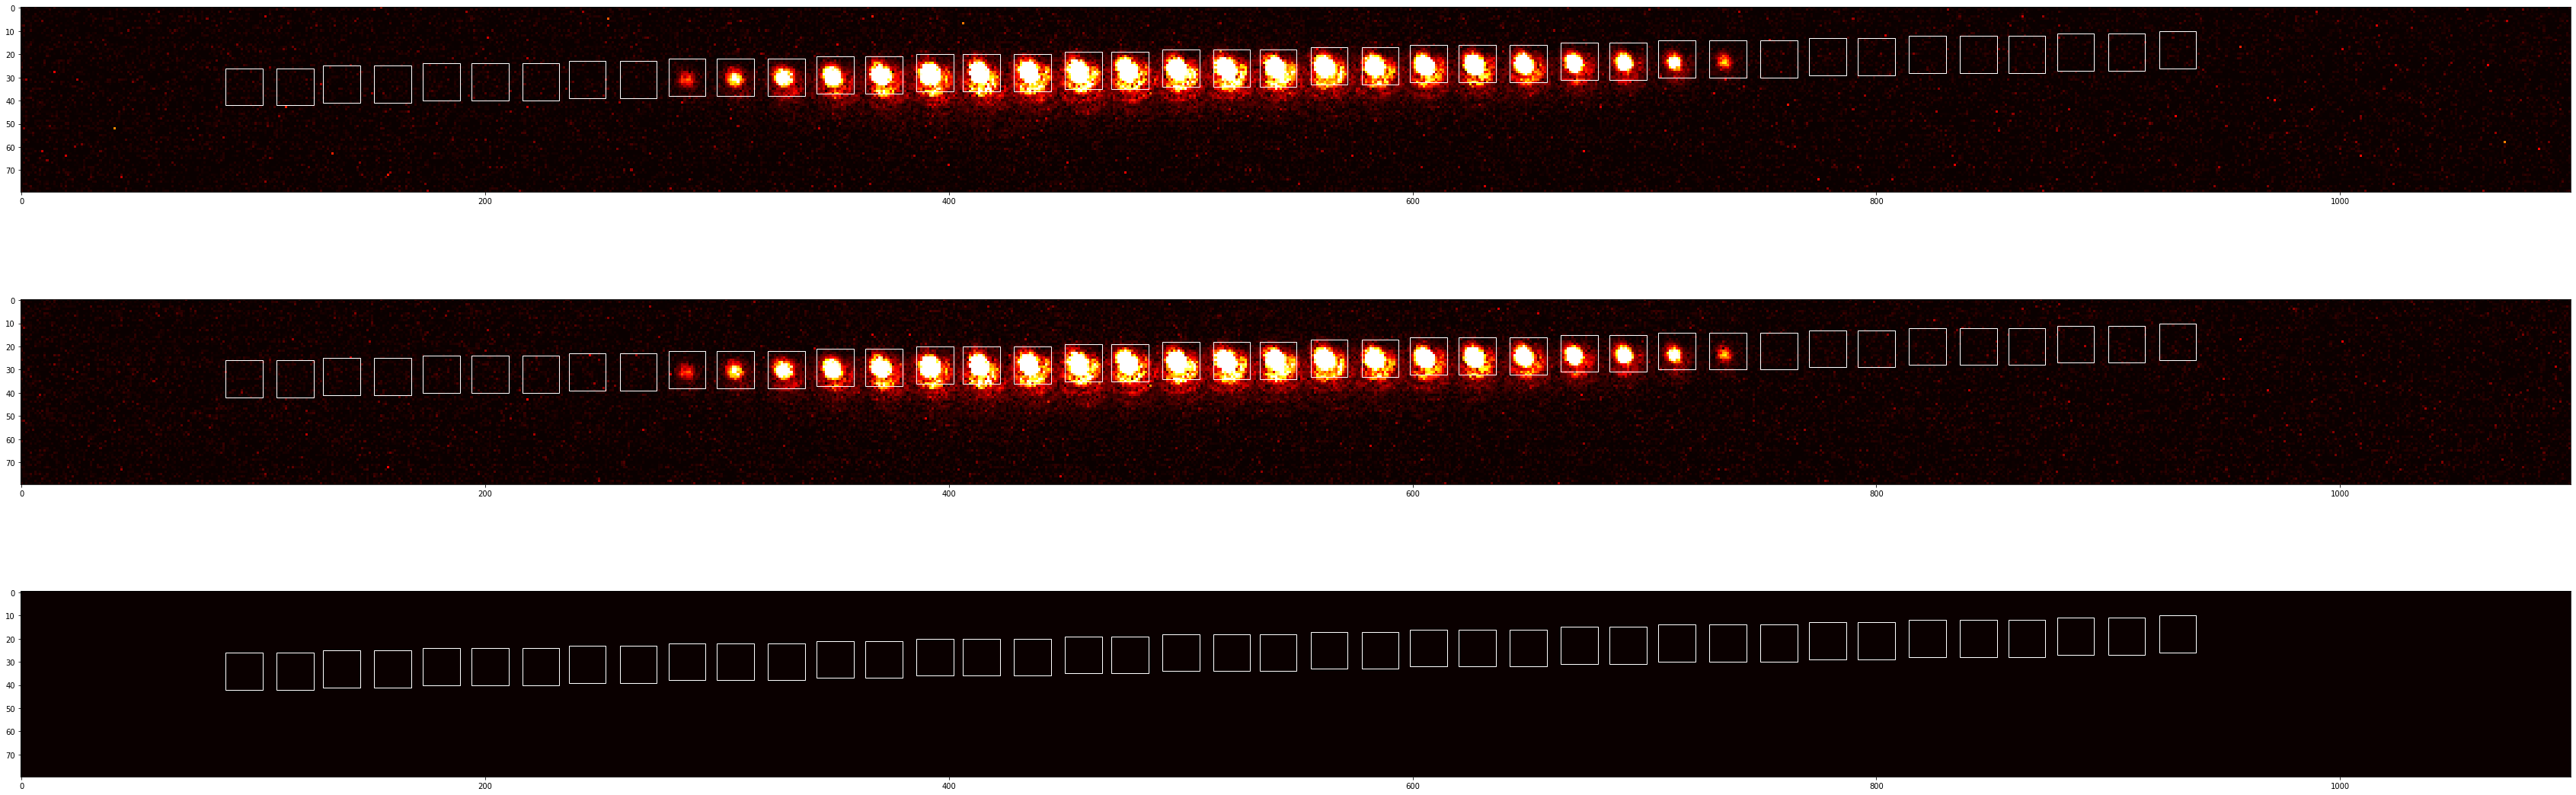

In [158]:
########################### User input section ############################

#Boolean input
###############################################
post_select_true = False
realtime_frequency_zeroing = True
quiet = False
probe_trim = False
odt_freq_center_override = True
plot_many_figures = True
plot_sigma_of_mean = False
###############################################
if plot_sigma_of_mean:
    divider = np.sqrt(num_loops)
else:
    divider = 1


#number input
###############################################
num_start = 0 # This has to be an integer times num_points
num_end = np.min([num_shots_jkam,num_shots_gage])
num_shots_sliced = num_end - num_start
# num_end = 5000
t_probe_trim = 50 #us #only applied when probe_trim = True
dark_count_threshold=-1
odt_freq_center = -2 #only applied when odt_freq_center_override = True
cav_dark_threshold = 1.5

num_frames_cav_per_twz = 3
t_pre = 202 #500 #us
t_cav_frame = 1.27e3 #44.4e3 #us
t_cav_expo = 0.250e3 #44.4e3 #us
t_gap = 0

# for the software gate
N_cycle=num_frames_cav_per_twz
t_cycle=t_cav_frame #1.97e3
t_probe=t_cav_expo #0.25e3
t_probe_het=t_cav_expo
###############################################

# num_frames_cav = tweezer_num * num_frames_cav_per_twz
num_frames_cav = 1 * num_frames_cav_per_twz
t_cav_start=np.array([t_pre+i*t_cav_frame for i in range(num_frames_cav_per_twz)] +\
            [t_pre+(3+i)*t_cav_frame+t_gap for i in range(num_frames_cav_per_twz)])
# t_cav_start=np.array([t_pre,t_pre+t_cav_expo,t_pre+2*t_cav_expo,t_pre+3*t_cav_expo+t_gap,t_pre+4*t_cav_expo+t_gap,t_pre+5*t_cav_expo+t_gap])
t_cav_end = t_cav_start + t_cav_expo


#list input
###############################################
upper_threshold_list_F0 =400*np.ones(num_tweezers)
# upper_threshold_list_F0[0] = 550
print(upper_threshold_list_F0)
# upper_threshold_list_F0 = [300,300,400,400,400,400,400,400,400,400,400,400,250,250] # counts above ref shot for each tweezer for frame 0
upper_threshold_list_F1 = 400*np.ones(num_tweezers) # counts above ref shot for each tweezer for frame 1
# upper_threshold_list_F1[0] = 400

upper_threshold_list_F2 = upper_threshold_list_F0 # counts above ref shot for each tweezer for frame 2
upper_threshold_list_F3 = upper_threshold_list_F0
upper_threshold_list_F4 = upper_threshold_list_F0
upper_threshold_list = upper_threshold_list_F0
###############################################
upper_threshold_mat=[upper_threshold_list_F0,upper_threshold_list_F1,upper_threshold_list_F2, upper_threshold_list_F3, upper_threshold_list_F4]


###########################################################################################################

import matplotlib.patches as patches
fig, axs = plt.subplots(num_frames, 1 ,figsize=(60, 20))
for frame_num in range(num_frames):
    axs[ frame_num].imshow(frames_array[frame_num]-frames_array[-1], cmap='hot', interpolation='nearest')
    for tweezer_freq in tweezer_freq_list:
        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
        axs[ frame_num].add_patch(rect1)
        
for axt in axs:        
    for im in axt.get_images():
        im.set_clim(0, 90)

plt.show()

### High NA imaging and cavity photoncount

In [159]:
for i, n in enumerate(tweezer_freq_list):
    print(i, n)

0 88.0
1 88.8
2 89.6
3 90.4
4 91.2
5 92.0
6 92.8
7 93.6
8 94.4
9 95.2
10 96.0
11 96.8
12 97.6
13 98.4
14 99.2
15 100.0
16 100.8
17 101.6
18 102.4
19 103.2
20 104.0
21 104.8
22 105.6
23 106.4
24 107.2
25 108.0
26 108.8
27 109.6
28 110.4
29 111.2
30 112.0
31 112.8
32 113.6
33 114.4
34 115.2
35 116.0
36 116.8
37 117.6
38 118.4
39 119.2


In [160]:


# survival = np.zeros((num_points, num_frames,tweezer_num))

atom_existence_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))


atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
    for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])
        atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - counts_array[num_start:num_end,-1,tweezer_counter]

        
for shot_num in range(num_shots_sliced):
    for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
        for frame_num in range(num_frames):
            if (atom_brightness_array[shot_num, frame_num, tweezer_counter] > upper_threshold_mat[frame_num][tweezer_counter]):
                atom_existence_array[shot_num, frame_num, tweezer_counter] = 1        
        
        
mask_all = np.zeros((num_shots_sliced, num_frames))

mask_num_atoms_list = []
for n in range(num_tweezers):
    mask = np.empty((num_shots_sliced, num_frames))
    mask[:] = np.NaN
    mask_num_atoms_list.append(mask)
mask_num_atoms_list = np.array(mask_num_atoms_list)
# #################################################################################                              

# for frame_num in range(num_frames):
#     mask00[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask10[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask01[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])        
#     mask11[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])
    

for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for twz in range(num_tweezers):
            if atom_brightness_array[shot_num,frame_num,atom_site[frame_num][twz]] >= upper_threshold_mat[frame_num][twz]:
                mask_all[shot_num,frame_num] = 1

                
# calculate an mask of atom number 1-num_tweezers
for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for num_atoms in range(num_tweezers):
            mask_num_atoms_list[num_atoms][shot_num, frame_num] = (int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1)
#             if int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1:
#                 mask_num_atoms_list[num_atoms][shot_num, frame_num] = 1



In [161]:
np.mean(counts_array[num_start:num_end,-1,20])/roi_area

103.09707479208629

In [162]:
atom_brightness_point_list = []
    
for point in range(num_points):
    atom_brightness_point_list.append(atom_brightness_array[point::num_points])

atom_brightness_point_array = np.array(atom_brightness_point_list)

point_survival = np.zeros((num_points, num_tweezers))
point_survival_err = np.zeros((num_points, num_tweezers))
point_survival_1 = np.zeros(num_points)
point_survival_1_err = np.zeros(num_points)

for point in range(num_points):
    survival_sum = 0
    total_atoms = 0
    for tweezer_num in range(num_tweezers):
        survival_list = []
        for shot_num in range(len(atom_brightness_point_array[point])):
            if ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] >= upper_threshold_mat[1][tweezer_num]) ):
                survival_list.append(1)
            elif ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] < upper_threshold_mat[1][tweezer_num]) ): 
                survival_list.append(0)
#         print(survival_list)
        point_survival[point, tweezer_num] = np.sum(survival_list)/len(survival_list)
        point_survival_err[point,tweezer_num] = np.sqrt(point_survival[point,tweezer_num]*(1-point_survival[point,tweezer_num])/len(survival_list))
        survival_sum += np.sum(survival_list)
        total_atoms += len(survival_list)
            
    point_survival_1[point] = survival_sum/total_atoms
    point_survival_1_err[point] = np.sqrt(point_survival_1[point]*(1-point_survival_1[point])/total_atoms)


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


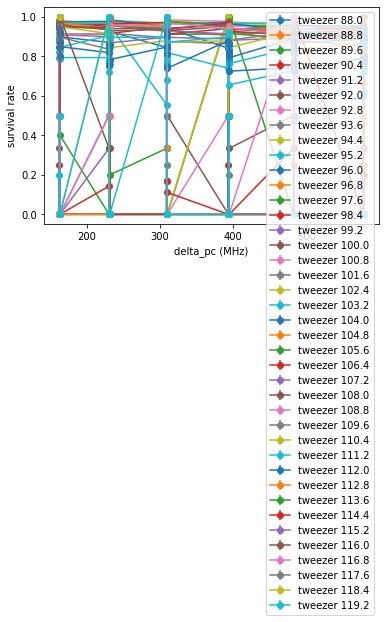

In [163]:
for tweezer in range(num_tweezers):
    plt.errorbar(point_list, point_survival[:,tweezer], point_survival_err[:,tweezer], label=f'tweezer {tweezer_freq_list[tweezer].round(3)}',
                marker='o')


plt.xlabel(point_name_inner)
plt.ylabel('survival rate')
plt.legend()

Text(0, 0.5, 'avg survival rate')

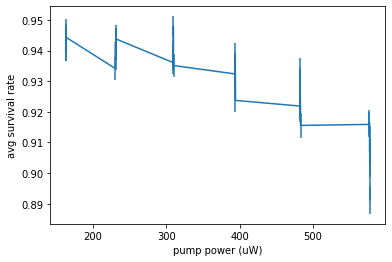

In [164]:
plt.errorbar(point_list, point_survival_1, point_survival_1_err)
plt.xlabel(point_name_outer)
plt.ylabel(f'avg survival rate')

survival rates: [0.06451613 0.18518519 0.11842105 0.13207547 0.04444444 0.07407407
 0.09756098 0.11111111 0.16666667 0.78020833 0.8815534  0.91350965
 0.90358336 0.9212968  0.92757386 0.92806841 0.95746382 0.95931142
 0.96338904 0.96082426 0.95903822 0.95606844 0.95106935 0.93771944
 0.90054795 0.93358105 0.934289   0.89013062 0.89751364 0.86878183
 0.83728814 0.07608696 0.05263158 0.06569343 0.08108108 0.12962963
 0.0862069  0.1        0.03125    0.07246377]
survival error: [0.04412365 0.0747568  0.0370628  0.04650655 0.03072065 0.03563891
 0.0463399  0.03491885 0.06804138 0.01336519 0.00711954 0.00433881
 0.00363705 0.00281335 0.00245242 0.00236573 0.00180453 0.00174763
 0.00165578 0.00171733 0.00175407 0.00182832 0.00194164 0.00220959
 0.00285992 0.00240002 0.00253454 0.00376752 0.00431204 0.00668232
 0.01074499 0.02764246 0.03622354 0.02116632 0.03173091 0.04570959
 0.03685369 0.04242641 0.03075784 0.03121055]


Text(0, 0.5, 'Event Probability')

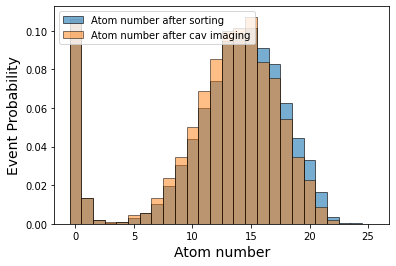

In [165]:
survival = np.zeros(num_tweezers)
survival[:]=np.nan
survival_err = np.zeros(num_tweezers)
survival_err[:]=np.nan

brightness = np.zeros(num_tweezers)
brightness[:]=np.nan
brightness_err = np.zeros(num_tweezers)
brightness_err[:]=np.nan




# atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
# for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
#     for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])



for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
    mask_temp = np.logical_and((atom_existence_array[:, 0, tweezer_counter] == 1),(atom_existence_array[:, 1, tweezer_counter] == 1))
    survival[tweezer_counter] = np.count_nonzero(mask_temp)
    survival[tweezer_counter] = survival[tweezer_counter]/np.sum(atom_existence_array[:,0,tweezer_counter])
    survival_err[tweezer_counter] = np.sqrt(survival[tweezer_counter]*(1-survival[tweezer_counter])/np.sum(atom_existence_array[:,0,tweezer_counter]))
    
    
    brightness[tweezer_counter] = np.nanmean(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    brightness_err[tweezer_counter] = np.nanstd(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    
            
            
print(f'survival rates: {survival}')
print(f'survival error: {survival_err}')

# atom number
atom_number=np.sum(atom_existence_array[:,:,:],axis=2)


hist_atom_edge=np.arange(-0.5,25.5+1)
hist_atom_x=(hist_atom_edge[:-1]+hist_atom_edge[1:])/2

hist_atom_0= np.histogram(atom_number[:,0],bins=hist_atom_edge)[0] 
P_atom_0=hist_atom_0/len(atom_number[:,0])

hist_atom_1= np.histogram(atom_number[:,1],bins=hist_atom_edge)[0] 
P_atom_1=hist_atom_1/len(atom_number[:,1])

plt.bar(hist_atom_x,P_atom_0,1, edgecolor="black",facecolor='C0',alpha=0.6,label='Atom number after sorting')
plt.bar(hist_atom_x,P_atom_1,1, edgecolor="black",facecolor='C1',alpha=0.5,label='Atom number after cav imaging')
plt.legend(fontsize=10,loc=2)
plt.xlabel('Atom number', fontsize=14)
plt.ylabel('Event Probability', fontsize=14)


Twz0 Loading rate 0.00, survival rate 0.06, brightness 455.50
Twz1 Loading rate 0.00, survival rate 0.19, brightness 464.00
Twz2 Loading rate 0.00, survival rate 0.12, brightness 482.33
Twz3 Loading rate 0.00, survival rate 0.13, brightness 437.29
Twz4 Loading rate 0.00, survival rate 0.04, brightness 554.50
Twz5 Loading rate 0.00, survival rate 0.07, brightness 472.50
Twz6 Loading rate 0.00, survival rate 0.10, brightness 442.75
Twz7 Loading rate 0.01, survival rate 0.11, brightness 448.56
Twz8 Loading rate 0.00, survival rate 0.17, brightness 441.60
Twz9 Loading rate 0.06, survival rate 0.78, brightness 692.36
Twz10 Loading rate 0.13, survival rate 0.88, brightness 649.91
Twz11 Loading rate 0.27, survival rate 0.91, brightness 691.92
Twz12 Loading rate 0.43, survival rate 0.90, brightness 672.73
Twz13 Loading rate 0.60, survival rate 0.92, brightness 712.79
Twz14 Loading rate 0.73, survival rate 0.93, brightness 767.20
Twz15 Loading rate 0.77, survival rate 0.93, brightness 715.76
Tw

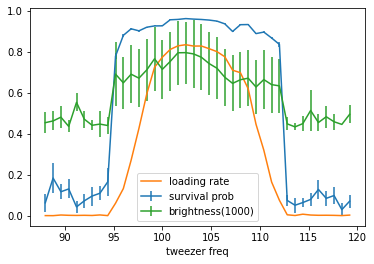

In [166]:
mask_atom_mat = atom_existence_array[:, 0,:]>0.1
mask_atom_survive_mat=np.abs(atom_existence_array[:, 0,:]-1)<0.1

loadingrate_mat=np.sum(mask_atom_mat,axis=0)/mask_atom_mat.shape[0]
for i in range(mask_atom_mat.shape[1]):
    print('''Twz{:.0f} Loading rate {:.2f}, survival rate {:.2f}, brightness {:.2f}'''.format(i,loadingrate_mat[i],survival[i],brightness[i]))
    
# print(f'average survival rate = {np.mean(survival)}')

plt.errorbar(tweezer_freq_list,survival, survival_err, label='survival prob')
plt.plot(tweezer_freq_list, loadingrate_mat, label='loading rate')
plt.errorbar(tweezer_freq_list, brightness/1000,brightness_err/1000, label='brightness(1000)')
plt.xlabel('tweezer freq')
plt.legend()

avg_survival = np.sum(atom_existence_array[:,1,:])/np.sum(atom_existence_array[:,0,:])
avg_survival_err = np.sqrt(avg_survival*(1-avg_survival)/np.sum(atom_existence_array[:,0,:]))
print(f'avg survival rate = {avg_survival} +/- {avg_survival_err}')
mean_brightness = np.sum(survival*loadingrate_mat*brightness)/np.sum(survival*loadingrate_mat)
print(f'average brightness = {mean_brightness}')
print(f'brightness per tweezer: {brightness}')
print(f'Survival rate per tweezer: {survival}')

### Photon count

In [167]:
def software_gate(time_list,t_pre,N,t_probe,t_cycle):
    mask = np.full(len(time_list),False)
    for i in range(N):
        mask = mask | ((time_list>= t_pre+i*t_cycle) & (time_list<= t_pre+i*t_cycle+t_probe))
    return mask



In [168]:
PT_cavity_timestamp_array_raw

array([array([  3184.36142857, 134547.21142857]),
       array([   387.88142857, 134547.21142857, 136702.63142857]),
       array([  1353.28142857,   2459.94142857,   2465.85142857, 134547.20142857,
              134661.75142857, 134970.28142857, 135038.83142857, 135438.51142857,
              135525.21142857, 135697.10142857, 136231.78142857, 136325.05142857,
              136413.68142857, 136481.17142857, 136508.65142857, 136622.56142857,
              136823.97142857, 136864.15142857, 136869.47142857, 137006.98142857,
              137174.65142857, 137180.85142857, 137185.18142857, 137187.86142857,
              137231.92142857, 137403.66142857, 137426.98142857, 137530.36142857,
              137707.56142857, 137775.59142857, 137801.51142857, 138145.18142857,
              138239.86142857, 138254.22142857, 138259.21142857, 138345.12142857,
              138360.22142857, 138426.20142857, 138473.84142857])                ,
       ...,
       array([1.13451429e+02, 3.54011143e+03, 1.34

In [169]:
cavity_photoncount_array=np.zeros((num_shots_sliced,num_frames_cav))

for sliced_i,i in enumerate(range(num_start, num_end)):
    timestamp_temp=PT_cavity_timestamp_array_raw[i]
    for j in range(num_frames_cav):
        mask_temp=(PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & ( PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
        cavity_photoncount_array[sliced_i,j]=np.sum(software_gate(PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],N_cycle,t_probe,t_cycle))
                
cavity_photoncount_array_plot=cavity_photoncount_array


# cavity_photoncount_array_2=np.zeros((num_shots_sliced,num_frames_cav))

# for sliced_i,i in enumerate(range(num_start, num_end)):
#     timestamp_temp=silver_PT_cavity_timestamp_array_raw[i]
#     for j in range(num_frames_cav):
#         mask_temp=(silver_PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & (silver_PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
#         cavity_photoncount_array_2[sliced_i,j]=np.sum(software_gate(silver_PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],N_cycle,t_probe,t_cycle))
                
# cavity_photoncount_array_plot_2=cavity_photoncount_array_2



In [170]:
# make the plot
plot = False

if plot:
    atom_site = []
    for i in range(num_frames):
        atom_site.append(np.arange(len(tweezer_freq_list)))
    C_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bins=50
    for i in range(num_tweezers):
        fig,axs=plt.subplots(ncols=num_frames+1,nrows=1,figsize=[15,6])

        fig.suptitle(f'Tweezer #{i}',fontsize=18)

        plt.sca(axs[0])
        plt.ylabel('Events #',fontsize=12)

        for j in range(num_frames-1):

            plt.sca(axs[j])
            plt.title('Frame {:.0f} Twz Freq = {:.1f}'.format(j,tweezer_freq_list[atom_site[j][i]]),fontsize=15)
            plt.hist(atom_brightness_array[:,j,atom_site[j][i]], alpha=0.75, color=C_cycle[j], bins=bins)
            plt.xlabel('Signal',fontsize=12)
            plt.axvline(upper_threshold_mat[j][i],linestyle='--',color='k')

        plt.sca(axs[-2])

        for j in range(num_frames-1):
            plt.plot(range(atom_brightness_array.shape[0]) , atom_brightness_array[:,j,atom_site[j][i]], marker='.',linestyle='None' ,
                     color=C_cycle[j],alpha=0.8)
            plt.axhline(upper_threshold_mat[j][i],linestyle='--',color=C_cycle[j])

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('camera Signal',fontsize=12)



        plt.sca(axs[-1])

        for j in range(1):
            plt.plot(range(cavity_photoncount_array.shape[0]) , cavity_photoncount_array[:,j], marker='.',linestyle='None' ,
                     color=C_cycle[j],alpha=0.8)

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('spcm Signal',fontsize=12)

        plt.tight_layout()
        plt.show()

### Atom existence and survival

In [171]:
num_shots_jkam

15391

In [172]:
x_val=point_list[E6math.get_point(np.arange(num_start,num_shots_sliced),num_points)]
mask_xval=[np.abs(x_val-n)<0.001 for i,n in enumerate(point_list)]
ind_list=np.arange(len(x_val))

inner_val = point_list_inner[E6math.get_point(np.arange(num_start,num_end),num_points)%num_points_inner]
outer_val = point_list_outer[E6math.get_point(np.arange(num_start,num_end),num_points)//num_points_inner]

mask_innerval=[np.abs(inner_val-n)<0.0001 for i,n in enumerate(point_list_inner)]
mask_outerval=[np.abs(outer_val-n)<0.0001 for i,n in enumerate(point_list_outer)]


In [173]:
len(ind_list)

15391

In [174]:
# create a mask for the same number of even and odd tweezer sites
mask_even_sites = np.zeros(num_tweezers)>1
mask_odd_sites = np.zeros(num_tweezers)>1

# for half-integer spacing
for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
    if tweezer_counter%2 == 0:
        mask_even_sites[tweezer_counter] = True
    else:
        mask_odd_sites[tweezer_counter] = True
        
# for half shifted L/2
# for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
#     if tweezer_counter < int(num_tweezers/2):
#         mask_even_sites[tweezer_counter] = True
#     else:  
#         mask_odd_sites[tweezer_counter] = True

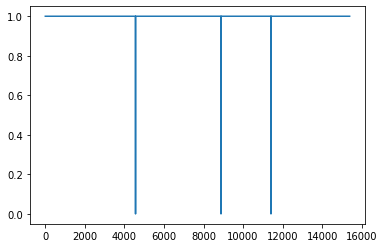

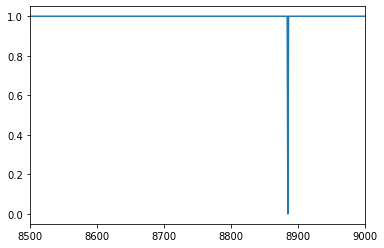

In [175]:
plt.plot(mask_valid_data)
plt.show()

plt.plot(mask_valid_data)
plt.xlim(8500,9000)
plt.show()

## Set atom NUMBER

In [547]:
### a list of mask for atom arrays with 1-N atoms

twz_num_plot=np.array([20])

mask_array_matrix=np.zeros([len(twz_num_plot),len(x_val)])>1

mask_select=mask_valid_data[:num_end] & ((ind_list<5850) | (ind_list>9442)) & (ind_list<14200) # & (ind_list>370) # & ((ind_list<1000) | (ind_list>1220))
side='left'

for i,num in enumerate(twz_num_plot):
    # twz_ind_start=int((num_tweezers-num)/2)
    # twz_ind_end=int((num_tweezers+num)/2)
    # print(twz_ind_start,twz_ind_end)

#     print(twz_ind_start,twz_ind_end)
    # mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,mask_odd_sites],axis=1)[num_start:num_end]==int(num/2))
    #                       & (np.sum(atom_existence_array[:,0,mask_even_sites],axis=1)[num_start:num_end]==int(num/2))
    #                       & (np.sum(atom_existence_array[:,1,mask_odd_sites],axis=1)[num_start:num_end]==int(num/2))
    #                       & (np.sum(atom_existence_array[:,1,mask_even_sites],axis=1)[num_start:num_end]==int(num/2))
    #                       & mask_select[num_start:num_end] & mask_TPF[num_start:num_end])
    mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,:],axis=1)[num_start:num_end]==int(num)) & (np.sum(atom_existence_array[:,1,:]*atom_existence_array[:,0,:], axis=1)[num_start:num_end]==int(num))
                          & mask_select[num_start:num_end] & mask_TPF[num_start:num_end])
    
    # mask_array_matrix[i]=(mask_select[num_start:num_end] & mask_TPF[num_start:num_end])
    
    # mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,:],axis=1)[num_start:num_end]==num)
    #                         & (np.sum(atom_existence_array[:,1,:],axis=1)[num_start:num_end]>=num-1)
    #                       & mask_select[num_start:num_end]) # & mask_TPF[num_start:num_end])
    # mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,mask_odd_sites],axis=1)[num_start:num_end]==(np.sum(atom_existence_array[:,0,mask_even_sites],axis=1)[num_start:num_end]))
    #                       & (np.sum(atom_existence_array[:,1,mask_odd_sites],axis=1)[num_start:num_end]==(np.sum(atom_existence_array[:,1,mask_even_sites],axis=1)[num_start:num_end]))
    #                       & (np.sum(atom_existence_array[:,0,mask_odd_sites],axis=1)[num_start:num_end]==(np.sum(atom_existence_array[:,1,mask_even_sites],axis=1)[num_start:num_end]))
    #                       & mask_select[num_start:num_end] & mask_TPF[num_start:num_end])                    
                        #  & (np.sum(atom_existence_array[:,0,twz_ind_start:twz_ind_end],axis=1)==num)[num_start:num_end]) 
#     mask_array_matrix[i]=((np.sum(atom_existence_array,axis=2)[:,1]>=num) & mask_select)
    # if side=='left':
    #     mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,:20],axis=1)[num_start:num_end]==num) & (np.sum(atom_existence_array[:,1,:20],axis=1)[num_start:num_end]==num)
    #                           & mask_select[num_start:num_end] & mask_TPF[num_start:num_end])
    # elif side=='right':
    #     mask_array_matrix[i]=((np.sum(atom_existence_array[:,0,20:],axis=1)[num_start:num_end]==num) & (np.sum(atom_existence_array[:,1,20:],axis=1)[num_start:num_end]==num) 
    #                           & mask_select[num_start:num_end] & mask_TPF[num_start:num_end])
# 
mask_good_data=np.zeros([len(x_val)])>1

for i in range(len(twz_num_plot)):
    mask_good_data = mask_good_data | mask_array_matrix[i]

Text(0, 0.5, 'photon count')

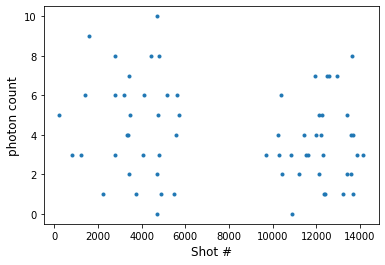

In [548]:
plt.plot(np.arange(len(mask_array_matrix[0]))[mask_array_matrix[0]],cavity_photoncount_array[mask_array_matrix[0],0],'.')
plt.xlabel('Shot #',fontsize=12)
plt.ylabel('photon count',fontsize=12)
# plt.xlim([0,1000])

Text(0, 0.5, 'photon count')

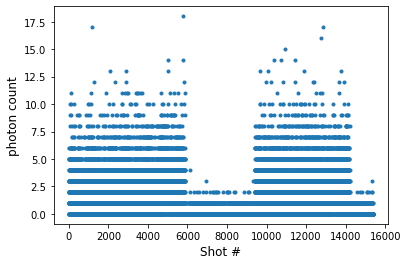

In [549]:
plt.plot(cavity_photoncount_array[:,0],'.')
plt.xlabel('Shot #',fontsize=12)
plt.ylabel('photon count',fontsize=12)
# plt.xlim(5500,6000)

# Heterodyne analysis hello

In [550]:
amp_array = abs(cmplx_amp_array)
phase_array = np.unwrap(np.angle(cmplx_amp_array))
x_quad_array = np.real(cmplx_amp_array)
p_quad_array = np.imag(cmplx_amp_array)
t0_list = timebin_array[:,0]
t1_list = timebin_array[:,1]

time_select=np.array([t_pre+i*t_cav_frame for i in range(N_cycle)])

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


In [551]:

plot_het = False


if plot_het:
    
    fig, axs = plt.subplots(ncols=2*num_segments, nrows=num_points*len(twz_num_plot), sharex=True, figsize=(40,5*num_points*len(twz_num_plot)))
    for point_idx in range(len(point_list)):
        # inner_idx = point_idx%num_points_inner
        # outer_idx = point_idx//num_points_inner
        
        outer_idx, inner_idx = get_outer_inner_point(point_idx, num_points_outer, num_points_inner, parallel=point_parallel)
        ind_x = point_idx
        corr_list = []
        for shot in range(num_shots_sliced):
            rcolor = shot/num_shots_sliced
            for twz_num_ind in range(len(twz_num_plot)):
                if mask_xval[ind_x][shot] & mask_array_matrix[twz_num_ind][shot]:
                    # if ind_x==1:
                    #     print(shot)
                    for frame in range(num_frames_cav):
                        if num_points > 1:
                            plt.sca(axs[ind_x+twz_num_ind*num_points, frame])
                        else:
                            plt.sca(axs[frame])
                        plt.plot(t0_list, amp_array[1,shot,frame],c=(rcolor,0,1-rcolor)) #, label='het')
                        if np.mean(amp_array[1,shot]>100):
                            print(shot)
                        plt.ylabel('amplitude')
                        # for t in time_select:
                            # plt.axvline(t, c='k')
                            # plt.axvline(t+t_probe, c='k',ls="--")
                            # plt.axvline(t+t_probe_het, c='k')
                        plt.title(point_name_outer+'={:.3f}'.format(point_list_outer[outer_idx])+', '+\
                                point_name_inner+'={:.3f}'.format(point_list_inner[inner_idx])+', frame {:.0f}'.format(frame))
                        # plt.ylim(0,60)

                        if num_points > 1:
                            plt.sca(axs[ind_x+twz_num_ind*num_points,num_frames_cav+frame])
                        else:
                            plt.sca(axs[num_frames_cav+frame])

                        plt.plot(t0_list, (np.unwrap(((phase_array[0,shot,frame]*2-phase_array[1,shot,frame])%(2*np.pi)),period=2*np.pi)/np.pi/2),c=(rcolor,0,1-rcolor))
                        plt.title(f'N={twz_num_plot[twz_num_ind]}')
                        corr_shot_temp = []
                        amp_shot_temp = []
                        # for t in time_select:
                            # plt.axvline(t, c='k')
                            # plt.axvline(t+t_probe, c='k',ls="--")
                            # plt.axvline(t+t_probe_het, c='k')


                        plt.xlabel('time [us]')
                        plt.ylabel('phase difference [2pi]')


Text(0, 0.5, 'ch1 phase')

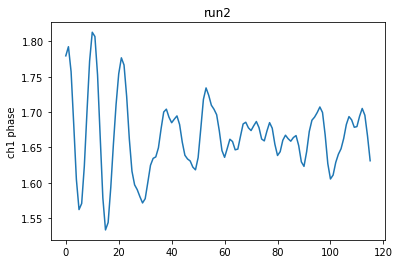

In [552]:
plt.plot(phase_array[0][0][0])
# plt.ylim(1.9,1.95)
plt.title(run_name)
plt.ylabel('ch1 phase')
# plt.xlim(0,1000)

In [553]:
# find average timetrace
amp_avg_timetrace_point_N = []
for twz_num_ind in range(len(twz_num_plot)):
    amp_avg_timetrace_point=np.empty((num_points, num_frames_cav), dtype=object)
    amp_avg_timetrace_point[:]=np.nan

    for ind_x in range(num_points):
        count=0
        amp_avg = np.zeros(len(amp_array[1,0,0]))
        for shot in range(num_shots_sliced):
            if mask_xval[ind_x][shot] & mask_array_matrix[twz_num_ind][shot]:
                count+=1
                for frame in range(num_frames_cav):
                    amp_avg += amp_array[1,shot,frame,:]
                    amp_avg_timetrace_point[ind_x, frame]=amp_avg/count
    amp_avg_timetrace_point_N.append(amp_avg_timetrace_point)

In [554]:
# bin_start=0
plot_true = False
if plot_true:   
    for point in range(num_points):
        outer_ind, inner_ind = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
        fig, axs = plt.subplots(ncols=num_frames_cav, nrows=1, figsize=(20,8))
        plt.suptitle(f'{point_name_outer}={point_list_outer[outer_ind]:.3f}, {point_name_inner}={point_list_inner[inner_ind]:.3f}',fontsize=18)
        for frame in range(num_frames_cav):
            plt.sca(axs[frame])
            try:
                plt.plot(t0_list, amp_avg_timetrace_point[point,frame], 'o-')
            except:
                pass
            plt.xlabel('time (us)')
            plt.ylabel('amplitude')
            plt.title(f'frame {frame}')
            # plt.xlim(0+zoom_into_frame_num*t_cav_frame,3000+zoom_into_frame_num*t_cav_frame)

        # for t in time_select:
        #     plt.axvline(t, c='k')
        #     plt.axvline(t+t_probe, c='k',ls="--")
        #     plt.axvline(t+t_probe_het, c='k')
            # plt.axvline(t+step_time*bin_start, c='k',ls="--")

In [555]:
# PHASE_CORRECTION = 0

# frame_start=time_select
# t_wiggle = 0 #us
# phase_frame_array=[]
# basephase_frame_array=[]
# amp_frame_array=[]
# x_quad_frame_array=[]
# p_quad_frame_array=[]
# for shot in range(num_shots_sliced): 
#     basephase_frame_temp=[]
#     phase_frame_temp=[]
#     amp_frame_temp=[]
#     real_frame_temp=[]
#     imag_frame_temp=[]
#     for i in range(num_frames_cav):
#         phase_array_ch1_temp = np.arctan2(p_quad_array[0,shot],x_quad_array[0,shot])
#         phase_array_ch3_temp = np.arctan2(p_quad_array[1,shot],x_quad_array[1,shot])
#         phase_frame_temp.append((phase_array_ch3_temp)[mask_cycle])
#         basephase_frame_temp.append(list((phase_array_ch1_temp*(2+PHASE_CORRECTION))[mask_cycle]))
#         amp_frame_temp.append(list(np.sqrt(x_quad_array[1,shot][mask_cycle]**2+p_quad_array[1,shot][mask_cycle]**2)))
#         real_frame_temp.append(list(x_quad_array[1,shot][mask_cycle]))
#         imag_frame_temp.append(list(p_quad_array[1,shot][mask_cycle]))
#     basephase_frame_array.append(basephase_frame_temp)
#     phase_frame_array.append(phase_frame_temp)
#     amp_frame_array.append(amp_frame_temp)
#     x_quad_frame_array.append(real_frame_temp)
#     p_quad_frame_array.append(imag_frame_temp)
# basephase_frame_array=np.array(basephase_frame_array)
# phase_frame_array=np.array(phase_frame_array)
# amp_frame_array=np.array(amp_frame_array)
# x_quad_frame_array=np.array(x_quad_frame_array)
# p_quad_frame_array=np.array(p_quad_frame_array)

In [556]:
basephase_frame_array=2*phase_array[0]
amp_frame_array=amp_array[1]
phase_frame_array=phase_array[1]
x_quad_frame_array=x_quad_array[1]
p_quad_frame_array=p_quad_array[1]

In [557]:
bin_start_avg=40
bin_stop_avg=100
amp_frame_array_point = np.empty(num_points, dtype='object')
phase_frame_array_point=np.empty(num_points, dtype='object')
basephase_frame_array_point=np.empty(num_points, dtype='object')
x_quad_frame_array_point = np.empty(num_points, dtype='object')
p_quad_frame_array_point = np.empty(num_points, dtype='object')

for ind_x in range(num_points):
    mask_point = mask_xval[ind_x] & mask_array_matrix[0]
    mask_valid = np.ones(np.sum(mask_point))>0
    for shot in range(np.sum(mask_point)):
        if np.sum(amp_frame_array[:num_shots_sliced][mask_point][shot])==0 or np.isnan(np.sum(amp_frame_array[:num_shots_sliced][mask_point][shot])) or (amp_frame_array[:num_shots_sliced][mask_point][shot][0,0]==1) or (np.mean(amp_frame_array[:num_shots_sliced][mask_point][shot][0])<0.15):
            mask_valid[shot]=False
    amp_frame_array_point[ind_x]=amp_frame_array[:num_shots_sliced][mask_point][mask_valid]
    phase_frame_array_point[ind_x]=phase_frame_array[:num_shots_sliced][mask_point][mask_valid]
    basephase_frame_array_point[ind_x]=basephase_frame_array[:num_shots_sliced][mask_point][mask_valid]
    x_quad_frame_array_point[ind_x]=x_quad_frame_array[:num_shots_sliced][mask_point][mask_valid]
    p_quad_frame_array_point[ind_x]=p_quad_frame_array[:num_shots_sliced][mask_point][mask_valid]

num_masked_loop_list = [len(phase_frame_array_point[point]) for point in range(num_points)]
num_masked_loop_max = max(num_masked_loop_list)
num_masked_loop_min = min(num_masked_loop_list)

amp_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
amp_frame_array_point_avg[:] = np.nan
amp_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
amp_frame_array_point_std[:] = np.nan
phase_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
phase_frame_array_point_avg[:] = np.nan
phase_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
phase_frame_array_point_std[:] = np.nan
x_quad_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
x_quad_frame_array_point_avg[:] = np.nan
x_quad_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
x_quad_frame_array_point_std[:] = np.nan
p_quad_frame_array_point_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
p_quad_frame_array_point_avg[:] = np.nan
p_quad_frame_array_point_std = np.empty((num_points, num_masked_loop_max, num_frames_cav))
p_quad_frame_array_point_std[:] = np.nan

for ind_x in range(num_points):
    amp_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(amp_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    amp_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(amp_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    phase_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(phase_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    phase_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(phase_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    x_quad_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(x_quad_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    x_quad_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(x_quad_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    p_quad_frame_array_point_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(p_quad_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)
    p_quad_frame_array_point_std[ind_x][0:num_masked_loop_list[ind_x]] = np.nanstd(p_quad_frame_array_point[ind_x][:,:,bin_start_avg:bin_stop_avg],axis=-1)

In [558]:
# select the maximum timebin in each shot
amp_frame_array_point_max=np.empty(num_points, dtype=object)
amp_frame_array_point_max[:]=np.nan
for point in range(num_points):
    point_temp=[]
    for shot in range(len(amp_frame_array_point[point])):
        shot_temp=[]
        for frame in range(num_frames_cav):
            argmax=np.argmax(amp_frame_array_point[point][shot][frame])
#             if (argmax-1>=0) & ((argmax+2)<=len(amp_frame_array_point[point][shot][cycle])):
            shot_temp.append(amp_frame_array_point[point][shot][frame][argmax])
        point_temp.append(shot_temp)
    amp_frame_array_point_max[point]=point_temp

In [559]:
amp_frame_array_max_avg=np.empty((num_points, num_frames_cav),dtype=object)
amp_frame_array_max_avg[:]=np.nan
for point in range(num_points):
    for frame in range(num_frames_cav):
        if np.sum(amp_frame_array_point_max[point]) != 0:
            amp_frame_array_max_avg[point][frame]=np.nanmean(amp_frame_array_point_max[point],axis=0)[frame]
        else:
            amp_frame_array_max_avg[point][frame]=np.nan

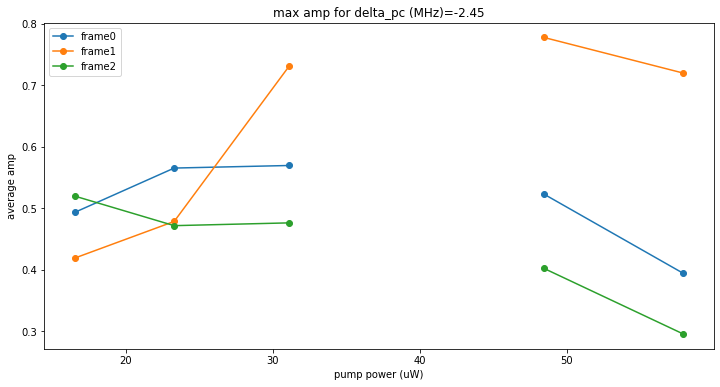

<Figure size 432x288 with 0 Axes>

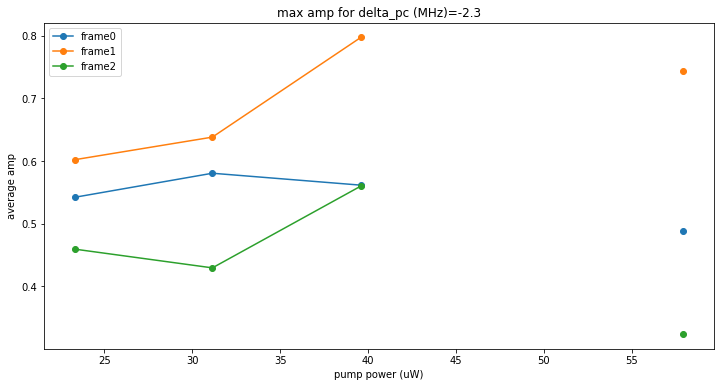

<Figure size 432x288 with 0 Axes>

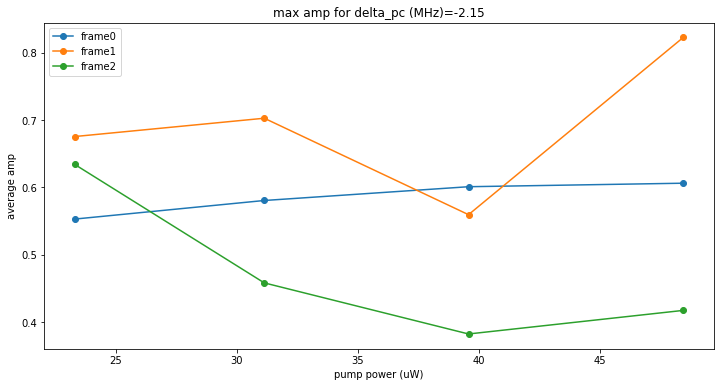

<Figure size 432x288 with 0 Axes>

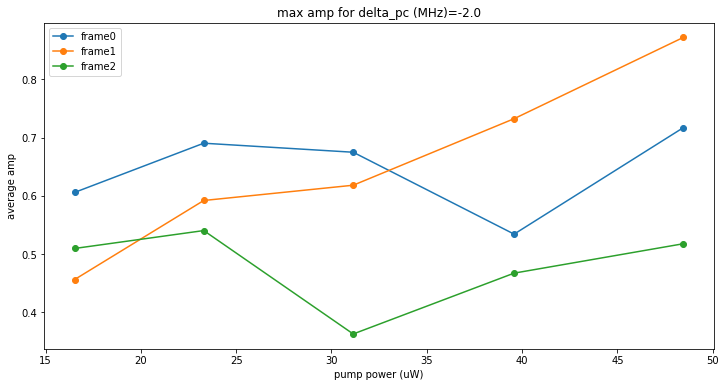

<Figure size 432x288 with 0 Axes>

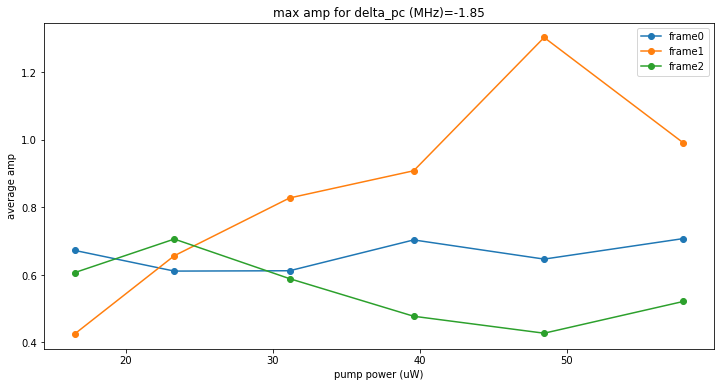

<Figure size 432x288 with 0 Axes>

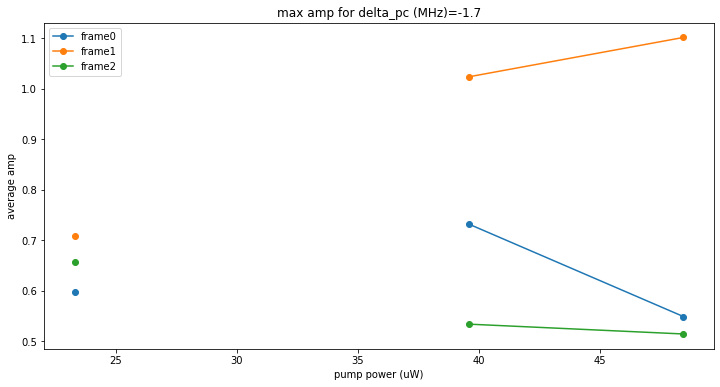

<Figure size 432x288 with 0 Axes>

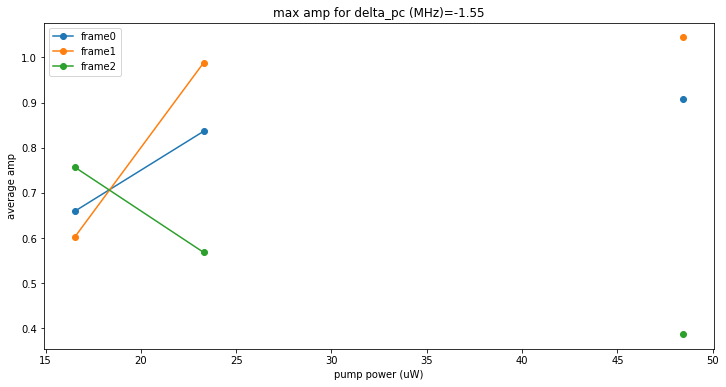

<Figure size 432x288 with 0 Axes>

In [560]:
for inner_point_ind in range(num_points_inner):
    mask_inner_point = np.zeros(num_points)
    mask_inner_point[inner_point_ind::num_points_inner] = 1
    fig,axs=plt.subplots(1,1,figsize=(12,6))
    plt.sca(axs)
    for frame in range(num_frames_cav):  
        if point_parallel:
            for outer_point_ind in range(num_points_outer):  
                if outer_point_ind == 0:
                    label=f'frame{frame}'
                else:
                    label=None   
                mask_outer_point = np.zeros(num_points) 
                mask_outer_point[outer_point_ind::num_points_outer] = 1
                point=np.argmax(mask_inner_point * mask_outer_point)
                plt.plot(point_list_outer[outer_point_ind],amp_frame_array_max_avg[point,frame],'o-',label=label, c=f'C{frame}')
        else:
            plt.plot(point_list_outer,amp_frame_array_max_avg[inner_point_ind::num_points_inner,frame],'o-',label=f'frame{frame}',  c=f'C{frame}')
    plt.title(f'max amp for {point_name_inner}={point_list_inner[inner_point_ind]}')
    plt.legend()
    plt.xlabel(point_name_outer)
    plt.ylabel('average amp')
    plt.figure()

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\Users\CavityQED\AppData\Local\Programs\Pyth

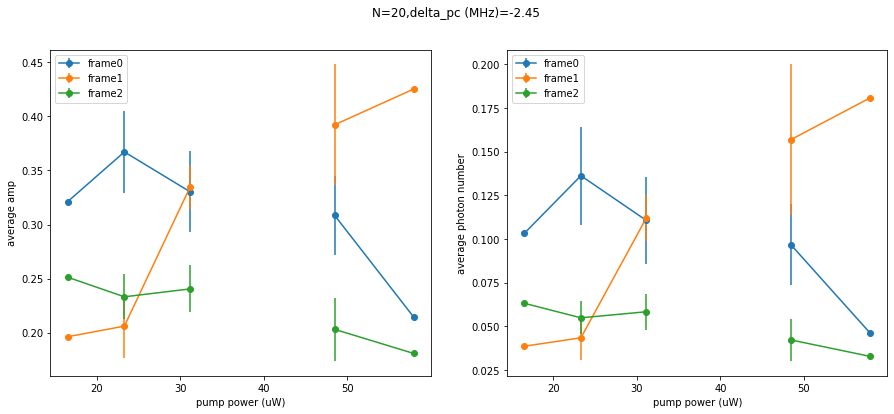

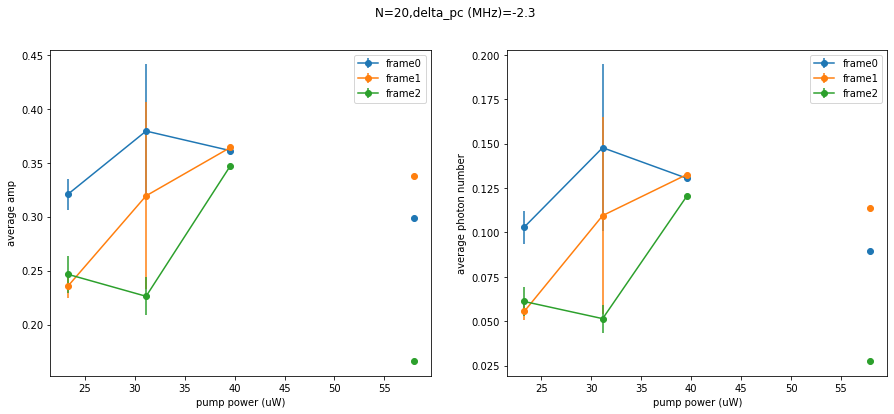

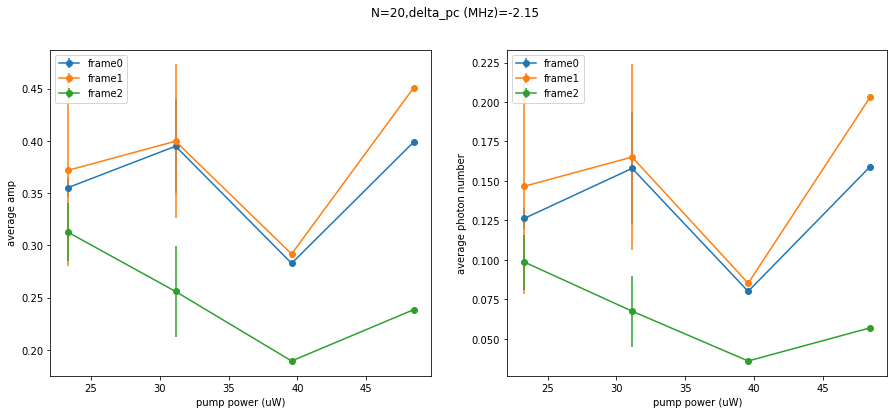

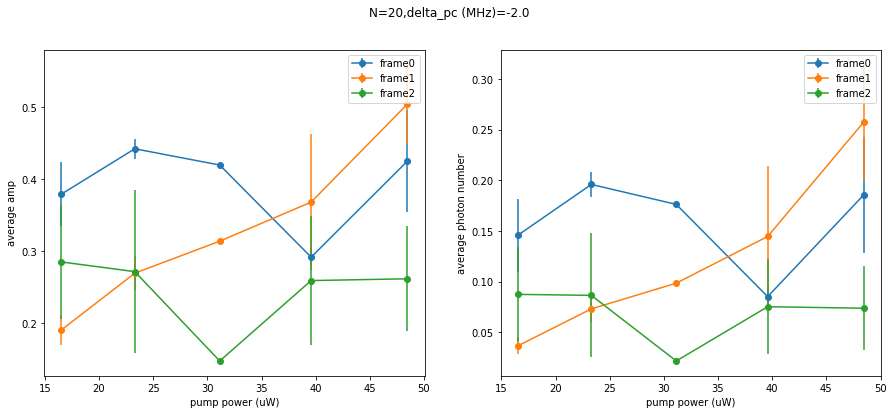

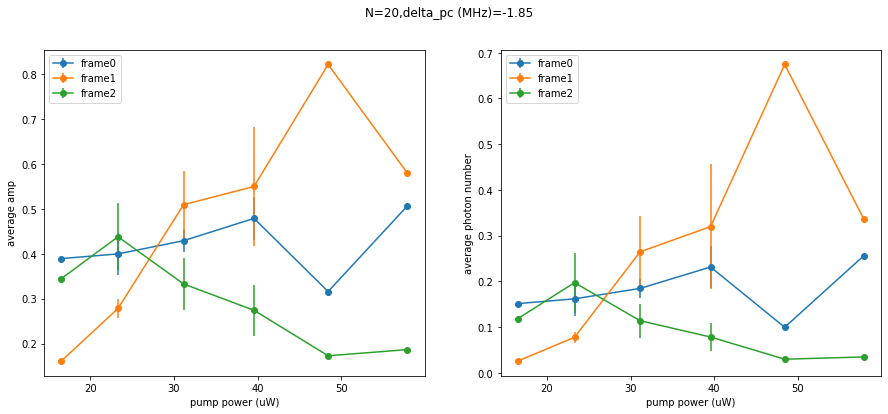

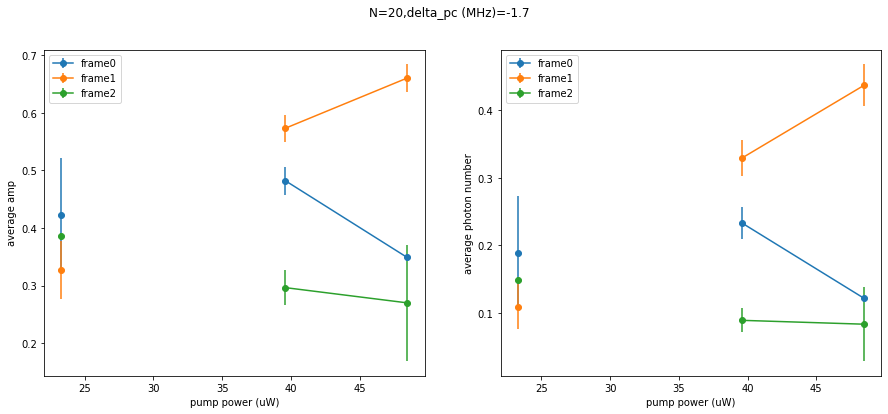

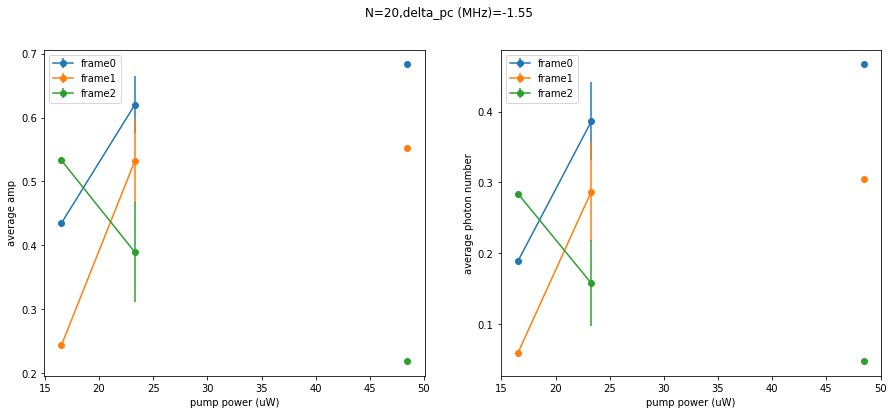

In [561]:
def cos_fit(x,A,k,x0,offset):
    return A*np.cos(k*(x-x0))+offset

count_array = np.zeros(num_points)
count_array[:]=np.nan
for point in range(num_points):
    count_array[point] = np.count_nonzero(amp_frame_array_point_avg[point][:,0])   

for inner_point_ind in range(num_points_inner):
    mask_inner_point = np.zeros(num_points) 
    mask_inner_point[inner_point_ind::num_points_inner] = 1
    
    fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(15,6))
    count = count_array[inner_point_ind::num_points_inner]

    plt.sca(axs[0])
    for frame in range(num_frames_cav):
    #     plt.plot(point_list_outer,np.nanmean(amp_frame_array_point_avg,axis=1)[inner_point_ind::num_points_inner,frame],'o--', label=f'frame{frame}')      
        if point_parallel:
            for outer_point_ind in range(num_points_outer):   
                if outer_point_ind == 0:
                    label=f'frame{frame}'
                else:
                    label=None
                mask_outer_point = np.zeros(num_points) 
                mask_outer_point[outer_point_ind::num_points_outer] = 1
                point=np.argmax(mask_inner_point * mask_outer_point)
                plt.errorbar(point_list_outer[outer_point_ind],np.nanmean(amp_frame_array_point_avg,axis=1)[point,frame],
                             yerr=np.nanstd(amp_frame_array_point_avg,axis=1)[point,frame],marker='o',label=label, c=f'C{frame}')
        else:
            plt.errorbar(point_list_outer,np.nanmean(amp_frame_array_point_avg,axis=1)[inner_point_ind::num_points_inner,frame],
                     yerr=np.nanstd(amp_frame_array_point_avg,axis=1)[inner_point_ind::num_points_inner,frame],marker='o', label=f'frame{frame}')
    plt.legend()
    plt.xlabel(point_name_outer)
    plt.ylabel('average amp')

    plt.sca(axs[1])
    for frame in range(num_frames_cav):
        if point_parallel:
            for outer_point_ind in range(num_points_outer):
                if outer_point_ind == 0:
                    label=f'frame{frame}'
                else:
                    label=None    
                mask_outer_point = np.zeros(num_points) 
                mask_outer_point[outer_point_ind::num_points_outer] = 1
                point=np.argmax(mask_inner_point * mask_outer_point)
                plt.errorbar(point_list_outer[outer_point_ind],np.nanmean(amp_frame_array_point_avg**2,axis=1)[point,frame],
                             yerr=np.nanstd(amp_frame_array_point_avg**2,axis=1)[point,frame],marker='o',label=label, c=f'C{frame}')
        else:
            plt.errorbar(point_list_outer,np.nanmean(amp_frame_array_point_avg**2,axis=1)[inner_point_ind::num_points_inner,frame],
                     yerr=np.nanstd(amp_frame_array_point_avg**2,axis=1)[inner_point_ind::num_points_inner,frame],marker='o', label=f'frame{frame}')
    #     plt.plot(point_list_outer,(np.nanmean(amp_frame_array_point_avg,axis=1)[inner_point_ind::num_points_inner,frame])**2,'o--', label=f'frame{frame}')
        # popt,pcov=curve_fit(cos_fit,point_list_outer,np.nanmean(amp_frame_array_point_avg**2,axis=1)[inner_point_ind::num_points_inner,frame],
        #                     p0=(10,1,-0.2,10),bounds=([0,1,-1,0],[100,20,1,100]))
        # x=np.linspace(np.min(point_list_outer),np.max(point_list_outer),100)
        # plt.plot(x,cos_fit(x,*popt),'--')
        # print(popt[2])
    plt.legend()
    plt.xlabel(point_name_outer)
    plt.ylabel('average photon number')
    plt.suptitle(f'N={twz_num_plot[0]},{point_name_inner}={point_list_inner[inner_point_ind]}')

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


average phase SNR = nan


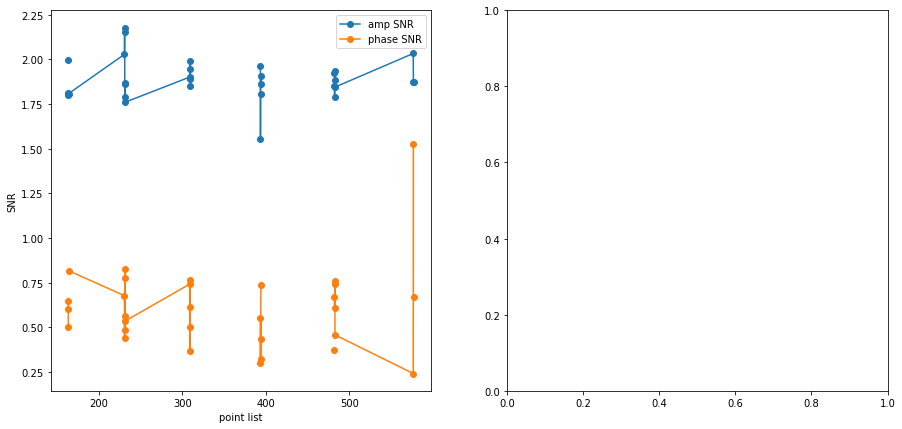

In [562]:
amp_mean_point_frame0 = np.empty(num_points)
amp_sigma_point_frame0 = np.empty(num_points)
phase_sigma_point_frame0 = np.empty(num_points)
frame=0
for point in range(num_points):
    try:
        amp_mean_point_frame0[point]=np.mean(np.concatenate(amp_frame_array_point[point][:,frame]))
        amp_sigma_point_frame0[point]=np.std(np.concatenate(amp_frame_array_point[point][:,frame]))
    except:
        amp_mean_point_frame0[point]=np.nan
        amp_sigma_point_frame0[point]=np.nan
#     phase_sigma_point_frame0[point]=np.mean(np.std(np.unwrap(phase_frame_array_point[point][:,0]),axis=1))*amp_mean_point_frame0[point]
    phase_sigma_point_frame0[point]=np.mean([np.std(np.unwrap(phase_frame_array_point[point][ii,frame]),axis=-1) for ii in range(len(phase_frame_array_point[point]))])
fig,axs=plt.subplots(nrows=1,ncols=2, figsize=[15,7])
plt.sca(axs[0])
# plt.errorbar(point_list_inner, amp_mean_point_frame0**2, yerr=2*amp_mean_point_frame0*amp_err_point_frame0, label='frame0')
# plt.errorbar(point_list_inner, amp_mean_point_frame1**2, yerr=2*amp_mean_point_frame1*amp_err_point_frame1, label='frame1')
print(f"average phase SNR = {np.mean(1/phase_sigma_point_frame0)}")
plt.plot(point_list, amp_mean_point_frame0/amp_sigma_point_frame0, label="amp SNR",marker='o')
plt.plot(point_list, 1/phase_sigma_point_frame0, label="phase SNR",marker='o')
plt.xlabel("point list")
plt.ylabel('SNR')
plt.legend()
plt.show()

In [563]:
# plt.subplots(ncols=1,nrows=1,figsize=(6,6))
# plt.sca(axs[0])
# for point in range(num_points):
#     inner_idx = point%num_points_inner
#     outer_idx = point//num_points_inner
#     mask_temp = mask_xval[point] & mask_array_matrix[0]
#     temp=[]
#     for shot in range(num_shots_sliced):
#         if mask_temp[shot]==True:
#             temp.append(shot)
#     for good_shot in range(len(temp)):
#         if np.sum(amp_frame_array[temp[good_shot]])==0:
#             mask_temp[temp[good_shot]]=False
#     plt.scatter(amp_frame_array_point_avg[point,:num_masked_loop_list[point],0]**2,\
#                 cavity_photoncount_array[mask_temp][:,0],label=f"{point_name_outer}={point_list_outer[outer_idx]:.3f}, {point_name_inner}={point_list_inner[inner_idx]:.3f}",\
#                 color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
# plt.xlabel('het_amp^2')
# # plt.xlim(0,1300)
# # plt.ylim(0,4000)
# plt.ylabel('spcm_count')
# # plt.xlim(0,1500/71*25)
# # plt.ylim(0,500/71*25)
# plt.title("frame0")
# # plt.legend(loc=(1,0))
# # plt.show()






In [564]:
# # plt.figure(figsize=(8,8))
# num_shots_masked = len(amp_frame_array_point_avg[0])
# for group in range(1+(num_shots_masked-1)//6):
#     plt.figure(figsize=(6,6))
#     for i in range(group*6,min(group*6+6,num_shots_masked)):
#         plt.scatter(amp_frame_array_point_avg[point,i,0:5]**2,cavity_photoncount_array[mask_array_matrix[0]][i,0:5],label=f"{i}-th valid shot")
    
#     plt.xlabel('het_amp^2')
#     plt.ylabel('spcm_count')
#     plt.xlim(0,1300/3)
#     plt.ylim(0,400/3)
#     plt.title("Former 5 frames (low 26mV)")
#     plt.legend()
#     plt.show()

In [565]:
bin_start=35
bin_end=100

begin_frame = 0
end_frame = 2

projected_amp_point_list=[]
for point in range(num_points):
    projected_amp_point=[]
    for i in range(num_masked_loop_list[point]): 
        projected_amp_frame=[]
        theta_frame_list=[]
        for frame in range(num_frames_cav): 
            x = x_quad_frame_array_point[point][i,frame]
            y = p_quad_frame_array_point[point][i,frame]
            
            theta0 = basephase_frame_array_point[point][i,frame]
            theta_begin = np.mean(np.unwrap(phase_frame_array_point[point][i,begin_frame]\
                                            - basephase_frame_array_point[point][i,begin_frame])[bin_start:bin_end])
            theta_end = np.mean(np.unwrap(phase_frame_array_point[point][i,end_frame]\
                                         - basephase_frame_array_point[point][i,end_frame])[bin_start:bin_end])
            theta_middle = np.mean(np.unwrap(phase_frame_array_point[point][i,1]\
                                         - basephase_frame_array_point[point][i,1])[bin_start:bin_end])
            while (theta_end-theta_begin > np.pi): theta_end -= 2*np.pi
            while (theta_end-theta_begin < -np.pi): theta_end += 2*np.pi
            theta_interpo = theta_begin + (theta_end-theta_begin)*(frame-begin_frame)/(end_frame-begin_frame)

            x_rotated = x[bin_start:bin_end]*np.cos(theta0)[bin_start:bin_end]+y[bin_start:bin_end]*np.sin(theta0)[bin_start:bin_end]
            y_rotated = -x[bin_start:bin_end]*np.sin(theta0)[bin_start:bin_end]+y[bin_start:bin_end]*np.cos(theta0)[bin_start:bin_end]
        
            cov_temp = np.array([[x_rotated@x_rotated,x_rotated@y_rotated],[x_rotated@y_rotated,y_rotated@y_rotated]])
            # print(point,cov_temp)
            eigenValues, eigenVectors = np.linalg.eig(cov_temp)
            idx = eigenValues.argmax()
            direction = eigenVectors[:,idx]
            direction = direction / np.linalg.norm(direction)
            
            theta_frame = np.arctan2(direction[1],direction[0])
            if frame==0:
                theta_dir = np.arctan2(direction[1],direction[0])
                # print(theta_dir, theta_begin)
                while theta_dir-theta_begin<=-np.pi/2:
                    theta_dir += np.pi
                while theta_dir-theta_begin>np.pi/2:
                    theta_dir -= np.pi
                theta_frame=theta_dir
            else:
                if (theta_dir < 0) & (theta_frame < 0):
                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                if (theta_dir > 0) & (theta_frame < 0):
                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                if (theta_dir > 0) & (theta_frame > 0):
                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                if (theta_dir < 0) & (theta_frame > 0):
                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                # print(theta_dir, theta_frame)    
            theta_frame_list.append(theta_frame)
        
        x0=x_quad_frame_array_point[point][i,0]    
        y0 = p_quad_frame_array_point[point][i,0]
        theta00 = basephase_frame_array_point[point][i,0]
        x0_rotated = x0*np.cos(theta00)+y0*np.sin(theta00)
        y0_rotated = -x0*np.sin(theta00)+y0*np.cos(theta00)
        
        if np.mean(x0_rotated*np.cos(theta_dir)+y0_rotated*np.sin(theta_dir))<0:
            theta_dir += np.pi
            for frame in range(num_frames_cav):
                theta_frame_list[frame]+=np.pi       
        for frame in range(num_frames_cav):
            x = x_quad_frame_array_point[point][i,frame]
            y = p_quad_frame_array_point[point][i,frame]
            theta0 = basephase_frame_array_point[point][i,frame]

            x_rotated = x*np.cos(theta0)+y*np.sin(theta0)
            y_rotated = -x*np.sin(theta0)+y*np.cos(theta0)
            cov_temp = np.array([[x_rotated@x_rotated,x_rotated@y_rotated],[x_rotated@y_rotated,y_rotated@y_rotated]])
            eigenValues, eigenVectors = np.linalg.eig(cov_temp)
            idx = eigenValues.argmax()
            direction = eigenVectors[:,idx]
            direction = direction / np.linalg.norm(direction)
            # print('theta_frame',frame,theta_frame_list[frame])
            
            theta_frame=theta_frame_list[frame]
            theta_final=theta_frame_list[end_frame]    
            theta_interp=theta_dir + (theta_final-theta_dir)*frame/(end_frame-begin_frame)           
            # print(theta_dir, theta_frame) 
            projected_amp = x_rotated*np.cos(theta_interp)+y_rotated*np.sin(theta_interp)
                       
            projected_amp_frame.append(projected_amp) 
        projected_amp_point.append(projected_amp_frame)
    projected_amp_point_list.append(projected_amp_point)

In [566]:
num_bins_het_plot = 20
projected_amp_mean_list_frame=[]
projected_amp_mean_list_frame_init=[]
for frame in range(num_frames_cav):
    projected_amp_mean_list= [] # contains the mean of the projected amplitude for each shot
    projected_amp_mean_list_init= [] # initial 100us
    projected_amp_abs_mean_list= [] # this one will correspond to what is shown in the average amp plot above, but this is not a physical quantity
    for point in range(num_points):
        projected_amp_point_temp = []
        projected_amp_point_init_temp = []
        projected_amp_point_abs_temp = []
        for i in range(num_masked_loop_list[point]): 
            projected_amp_point_temp.append(np.mean(np.array(projected_amp_point_list[point])[i,frame]))
            projected_amp_point_init_temp.append(np.mean(np.array(projected_amp_point_list[point])[i,frame][bin_start:bin_start+num_bins_het_plot]))
            projected_amp_point_abs_temp.append(np.mean(np.abs(np.array(projected_amp_point_list[point])[i,frame])))
        projected_amp_mean_list.append(projected_amp_point_temp)
        projected_amp_mean_list_init.append(projected_amp_point_init_temp)
        projected_amp_abs_mean_list.append(np.array(projected_amp_point_abs_temp))
    projected_amp_mean_list_frame.append(projected_amp_mean_list)
    projected_amp_mean_list_frame_init.append(projected_amp_mean_list_init)

In [567]:
len(projected_amp_mean_list_frame[0])

42

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:1

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

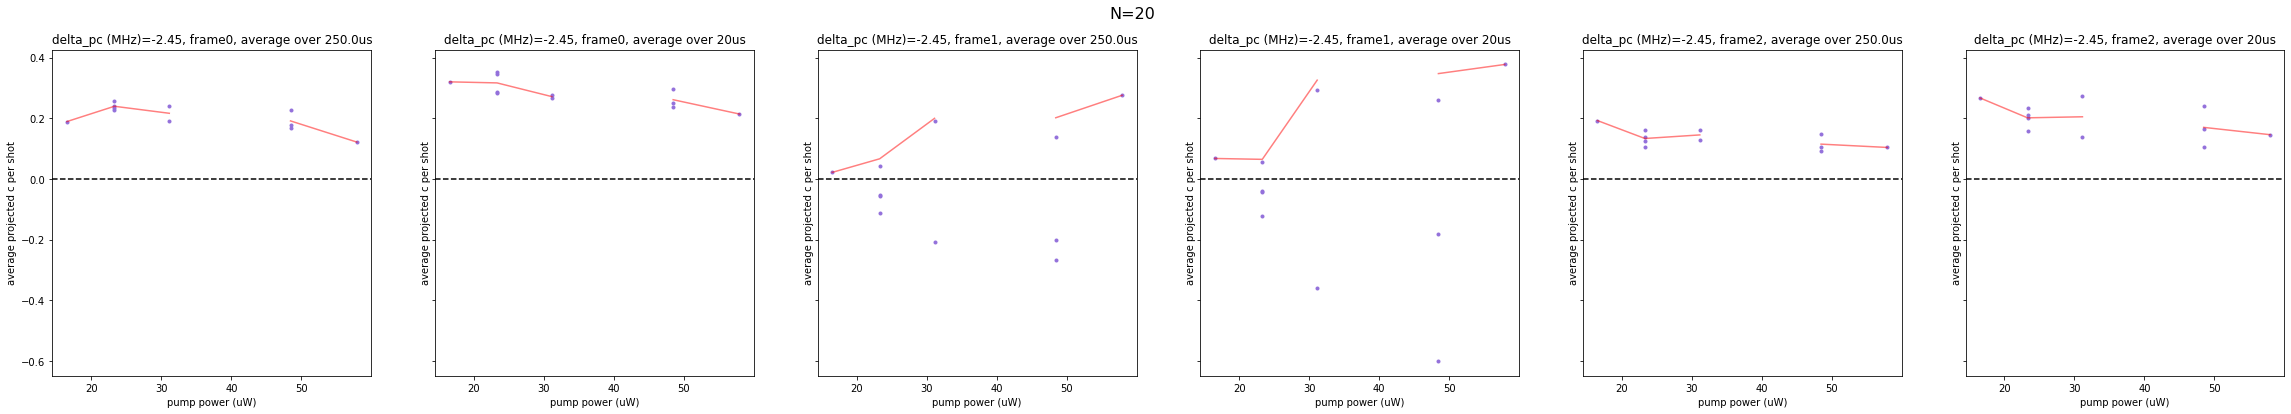

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

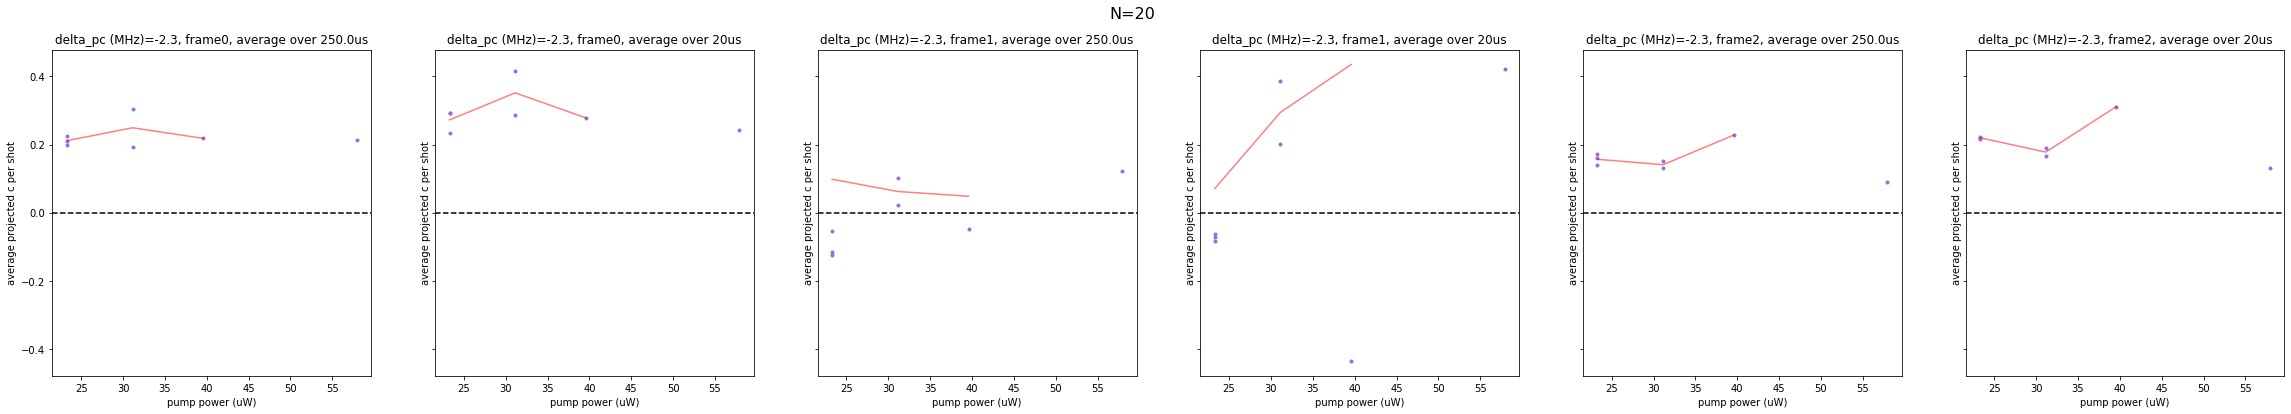

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

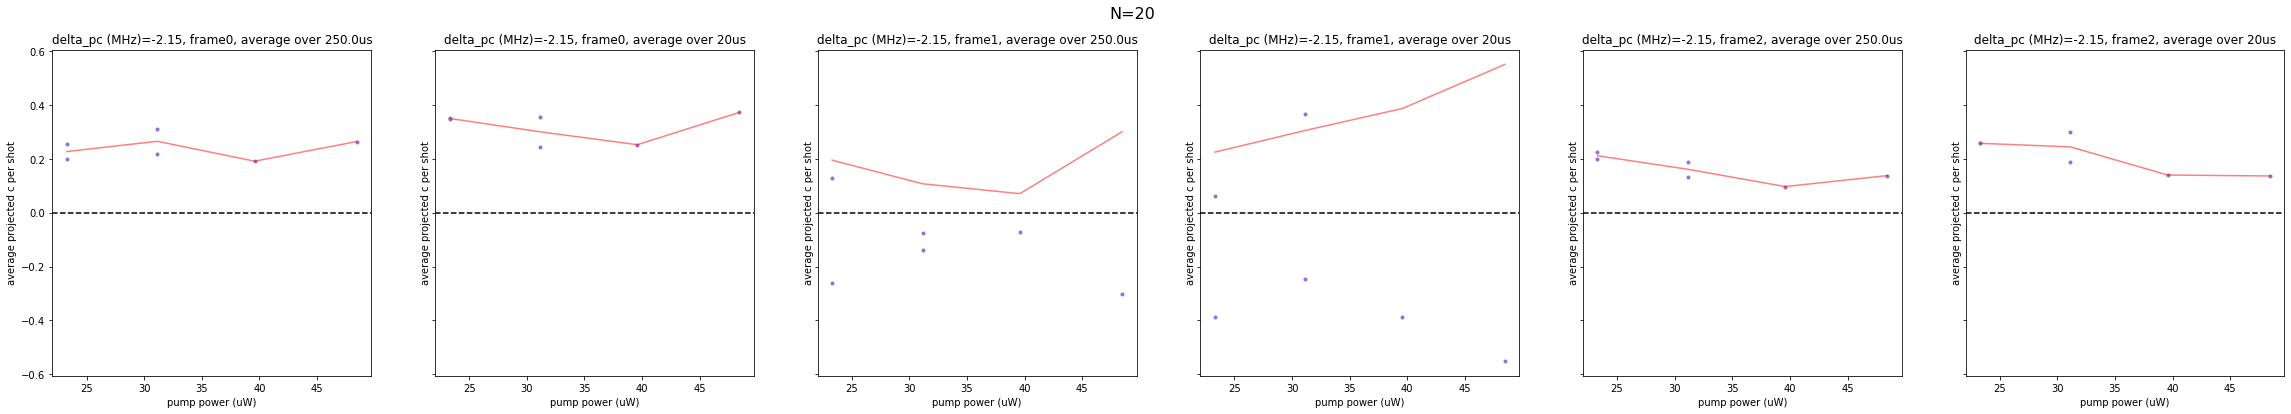

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

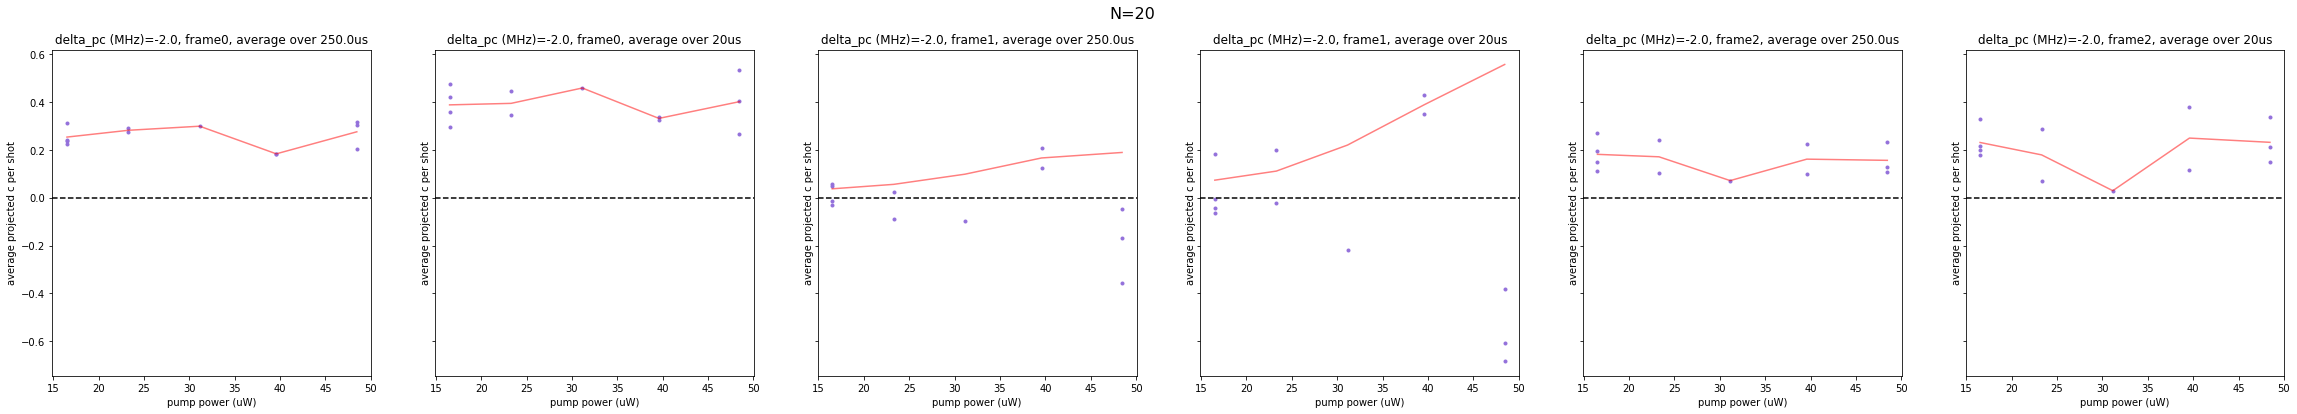

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

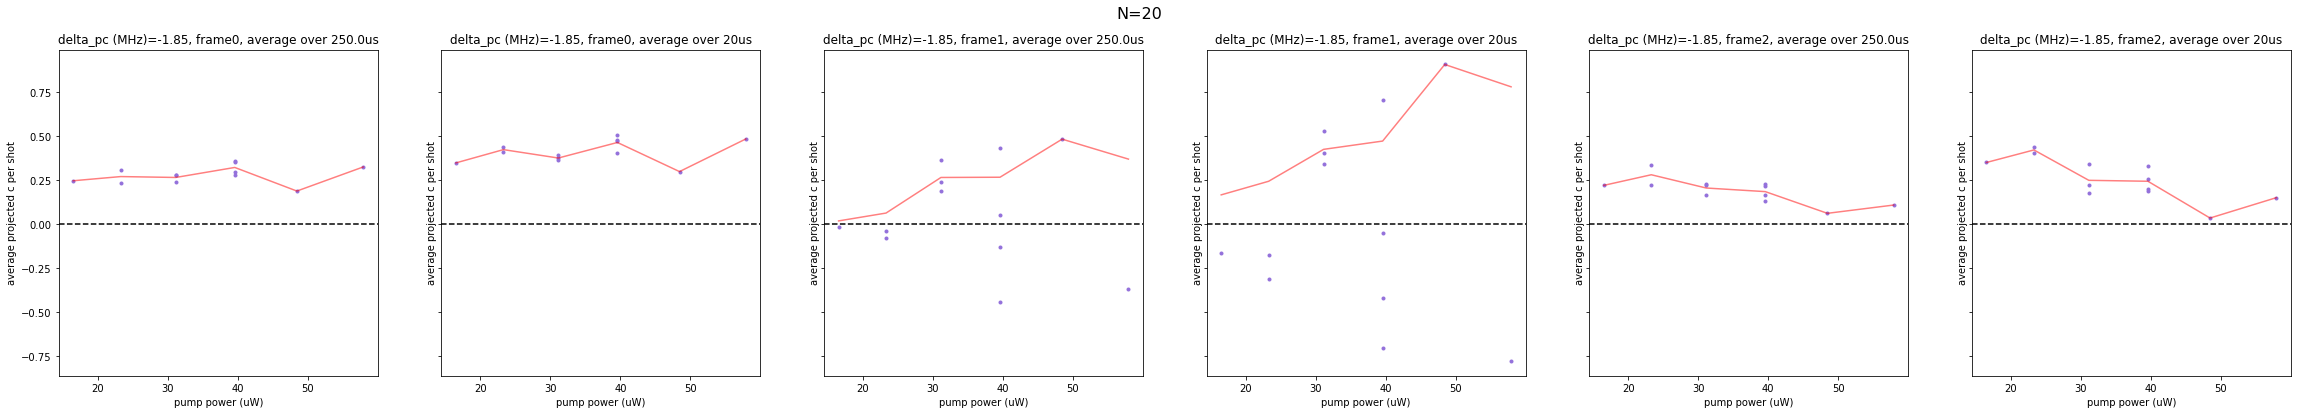

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

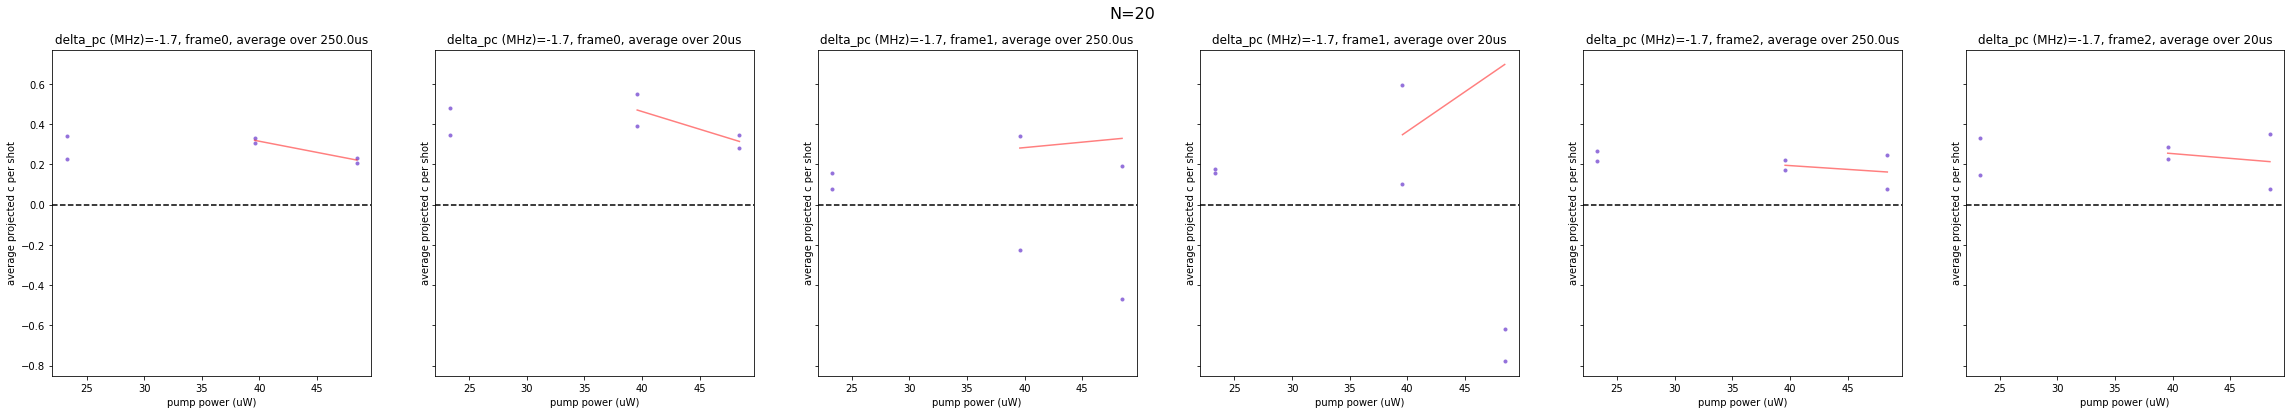

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

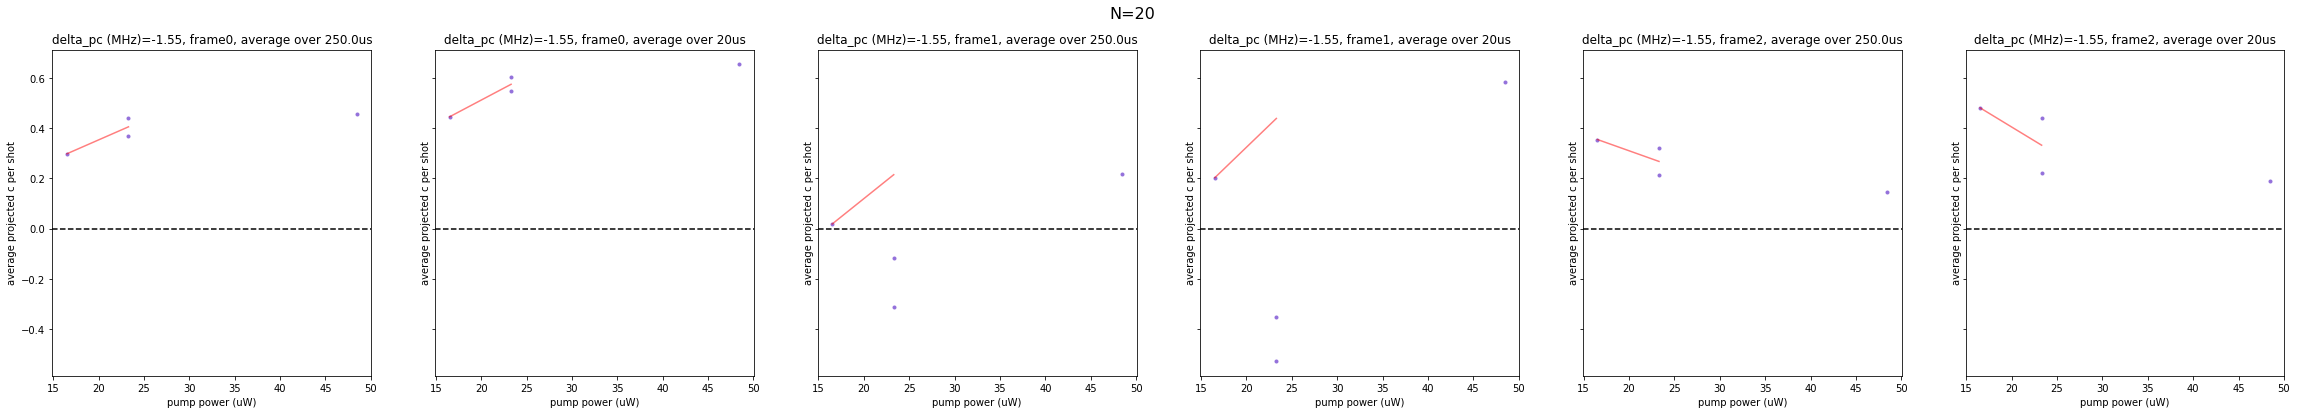

<Figure size 432x288 with 0 Axes>

In [568]:
mean_amp_array = np.empty((num_points_inner, num_points_outer, num_frames_cav))
mean_amp_array_init = np.empty((num_points_inner, num_points_outer, num_frames_cav))

for inner_idx in range(num_points_inner):
    fig,axs=plt.subplots(nrows=1,ncols=2*num_frames_cav, figsize=(40,6), sharey=True)
    plt.suptitle(f'N={twz_num_plot[0]}', fontsize=16)
    for frame in range(num_frames_cav):
        plt.sca(axs[2*frame])
        mean_plot=np.zeros(num_points_outer)
        mean_plot[:]=np.nan
        for outer_idx in range(num_points_outer):
            # if point_parallel:    
            #     mask_inner_point = np.zeros(num_points)
            #     mask_inner_point[inner_idx::num_points_inner] = 1
            #     mask_outer_point = np.zeros(num_points) 
            #     mask_outer_point[outer_idx::num_points_outer] = 1
            #     point = np.argmax(mask_inner_point*mask_outer_point)
            # else:
            #     point = outer_idx*num_points_inner + inner_idx
            
            ii = np.nan
            for ii in range(num_points):
                if get_outer_inner_point(ii, num_points_outer, num_points_inner, parallel=point_parallel) == (outer_idx, inner_idx):
                    point = ii
                
            
            y = projected_amp_mean_list_frame[frame][point]
            y_abs = np.abs(projected_amp_mean_list_frame[frame][point])
            plt.plot(point_list_outer[outer_idx]*np.ones(len(y)),y,'.',c='mediumpurple') 
            y_abs_mean_1 = np.mean(y_abs)
            # plt.plot(point_list_outer[outer_idx], y_abs_mean_1,'o-',c='red',label='average')
            mean_plot[outer_idx]=y_abs_mean_1
        mean_amp_array[inner_idx,:,frame] = mean_plot
        plt.plot(point_list_outer,mean_plot,'-',alpha=0.5,c='red',label='average')
        plt.axhline(0, c='k', ls='--')

        plt.xlabel(point_name_outer)
        plt.ylabel('average projected c per shot')
        plt.title(f'{point_name_inner}={np.round(point_list_inner[inner_idx],2)}, frame{frame}, average over {t_cav_expo}us')
        # plt.legend()
        plt.figure()
        
        plt.sca(axs[2*frame+1])
        mean_plot_init=np.zeros(num_points_outer)
        mean_plot_init[:]=np.nan
        for outer_idx in range(num_points_outer):
            if point_parallel:    
                mask_inner_point = np.zeros(num_points)
                mask_inner_point[inner_idx::num_points_inner] = 1
                mask_outer_point = np.zeros(num_points) 
                mask_outer_point[outer_idx::num_points_outer] = 1
                point = np.argmax(mask_inner_point*mask_outer_point)
            else:
                point = outer_idx*num_points_inner + inner_idx
            y = projected_amp_mean_list_frame_init[frame][point]
            y_abs = np.abs(projected_amp_mean_list_frame_init[frame][point])
            plt.plot(point_list_outer[outer_idx]*np.ones(len(y)),y,'.',c='mediumpurple') 
            y_abs_mean_1 = np.mean(y_abs)
            # plt.plot(point_list_outer[outer_idx], y_abs_mean_1,'o-',c='red',label='average')
            mean_plot_init[outer_idx]=y_abs_mean_1
        mean_amp_array_init[inner_idx,:,frame] = mean_plot_init
        plt.plot(point_list_outer,mean_plot_init,'-',c='red',alpha=0.5,label='average')
        plt.axhline(0, c='k', ls='--')

        plt.xlabel(point_name_outer)
        plt.ylabel('average projected c per shot')
        plt.title(f'{point_name_inner}={np.round(point_list_inner[inner_idx],2)}, frame{frame}, average over {num_bins_het_plot*step_time}us')
        # plt.legend()
        plt.figure()

In [569]:
point_list_outer

array([16.52119977, 23.29980949, 31.14173054, 39.58176421, 48.45376811,
       57.92388463])

In [570]:
# measure the phase correlation between node frames. Corr of 0.5 means there is no correlation.
# corr_point=[]
# corr_std_point=[]
# for point in range(num_points_outer):
#     corr_list = []
#     for shot in range(len(projected_amp_point_list[point])):
#         if np.mean(projected_amp_point_list[point][shot][1][:])*np.mean(projected_amp_point_list[point][shot][2][:])>0:
#             corr_list.append(1)
#         elif np.mean(projected_amp_point_list[point][shot][1][:])*np.mean(projected_amp_point_list[point][shot][2][:])<0:
#             corr_list.append(0)

#     corr_meas=np.mean(corr_list)
#     corr_std=np.sqrt(corr_meas*(1-corr_meas)/len(corr_list))
#     corr_point.append(corr_meas)
#     corr_std_point.append(corr_std)
#     print(f'{point_name_outer}={np.round(point_list_outer[point],2)} correlation measurement for N={twz_num_plot[0]} : {corr_meas} +/- {corr_std}')

In [571]:
# plt.plot(corr_list)

In [572]:
# # determine the switching rate

# switch_bin_list_point=[]
# threshold=7
# n_stay=1

# for point in range(num_points):
#     switch_bin_list_temp=[]
#     for shot in range(len(projected_amp_point_list[point])):
#         # switch_bin_list=[]
#         for frame_switch in [1]:
#             switch_bin_list_frame=[]
#             for bin in range(n_stay,len(projected_amp_point_list[point][shot][frame_switch][bin_start:])-n_stay):
#                 if (projected_amp_point_list[point][shot][frame_switch][bin+bin_start]*projected_amp_point_list[point][shot][frame_switch][bin+bin_start+n_stay]<0) & \
#                 (np.abs(np.mean(projected_amp_point_list[point][shot][frame_switch][bin+bin_start-n_stay+1:bin+bin_start+1]))>threshold) & \
#                 (np.abs(np.mean(projected_amp_point_list[point][shot][frame_switch][bin+bin_start+1:bin+bin_start+n_stay+1]))>threshold):
#                     switch_bin_list_frame.append(bin)
#             switch_bin_list_temp.append(switch_bin_list_frame)
#     switch_bin_list_point.append(switch_bin_list_temp)

In [573]:
# determine switching events by dividing the amplitude into bins

switch_bin_list_point=[]
threshold=0.2

for point in range(num_points):
    switch_bin_list_temp=[]
    for shot in range(len(projected_amp_point_list[point])):
        # switch_bin_list=[]
        for frame_switch in [1]:
            projected_amp_temp=projected_amp_point_list[point][shot][frame_switch]
            mask_valid=np.zeros(len(projected_amp_temp))>1
            amp_bin_valid=[]
            switch_bin_list_frame=[]
            for bin in range(len(projected_amp_temp[bin_start:])):
                if np.abs(projected_amp_temp[bin+bin_start])>threshold:
                    amp_bin_valid.append(bin+bin_start)
            for bin_valid in amp_bin_valid:
                mask_valid[bin_valid]=True
            
            # find the switch points
            projected_amp_filtered=projected_amp_temp[mask_valid]
            for bin in range(0,len(projected_amp_filtered)-1):
                if (projected_amp_filtered[bin]*projected_amp_filtered[bin+1]<0):
                    switch_bin_list_frame.append(np.mean([amp_bin_valid[bin], amp_bin_valid[bin+1]]))                   
        switch_bin_list_temp.append(np.sort(switch_bin_list_frame))
    switch_bin_list_point.append(switch_bin_list_temp)

In [574]:
switch_num_list_point=[]
for point in range(num_points):
    switch_num_list_temp=[]
    for i in range(len(switch_bin_list_point[point])):
        switch_num_list_temp.append(len(switch_bin_list_point[point][i]))
    switch_num_list_point.append(np.concatenate([switch_num_list_temp]))

In [575]:
residence_time_list=[]
zero_count=0
for point in range(num_points):
    residence_time_list_temp=[]
    for shot in range(len(projected_amp_point_list[point])):
        total_bins=len(projected_amp_point_list[point][shot][1])
        try:
            start_ind=np.arange(total_bins)[np.abs(projected_amp_point_list[point][shot][1])>threshold][0]
        except:
            start_ind=bin_start
        # start_ind=bin_start
        switch_temp=np.concatenate((np.array([start_ind]), switch_bin_list_point[point][shot]))
        if len(np.diff(switch_temp))==0:
            zero_count += 1
            switch_temp=np.array([start_ind, 100])
        residence_time_list_temp.append(np.diff(switch_temp))
        
    try:
        residence_time_list.append(np.concatenate(residence_time_list_temp))
    except:
        residence_time_list.append(np.array([np.nan]))
    
residence_time_array=np.array(residence_time_list)

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [576]:
bin_end

100

In [577]:
def poisson_dist(x,r): 
    t=1 #t_cav_expo/1000
    dist=np.exp(-r*t)*((r*t)**x)
    x_factorial=np.ones(len(x))
    for i in range(len(x)):
        x_factorial[i]=math.gamma(x[i]+1)
    return dist/x_factorial

In [578]:
def exponential(x,tau):
    return 1/tau*np.exp(-x/tau)

In [579]:

plot_true = False
if plot_true:   


    fig,axs=plt.subplots(nrows=num_points_inner,ncols=num_points_outer, figsize=(5*num_points_outer,5*num_points_inner), sharex=True)
    plt.suptitle(f'N={twz_num_plot[0]}', fontsize=16)
    t_switch_fit=[]
    for point in range(num_points):
        if num_points==1:
            plt.sca(axs)
        elif num_points_inner==1:
            plt.sca(axs[point])
            outer_idx, inner_idx = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
        else:
            outer_idx, inner_idx = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
            plt.sca(axs[inner_idx, outer_idx])
        num_bins_hist=20
        try:
            data=step_time*residence_time_array[point]
            hist, bins_hist = np.histogram(data,bins=np.arange(np.min(data),np.max(data),5), density=True)
            plt.bar((bins_hist[1:]+bins_hist[:-1])/2,hist,width=(bins_hist[1]-bins_hist[0])) 

        
            popt,pcov=curve_fit(exponential,(bins_hist[1:]+bins_hist[:-1])[1:]/2,hist[1:],p0=(50),maxfev=1000) #, sigma=1/bins_hist[1:])
            t_switch_fit.append(popt[0])
            x=np.linspace(np.min((bins_hist[1:]+bins_hist[:-1])/2),np.max((bins_hist[1:]+bins_hist[:-1])/2),100)
            plt.plot(x,exponential(x, *popt),'--',c='r',label=f'exponential fit, t_switch={popt[0]:.2f}')
            plt.xlabel('residence time [us]')
            plt.title(f'{point_name_outer}= {np.round(point_list_outer[outer_idx],2)}')
            plt.legend()
        except:
            t_switch_fit.append(np.nan)
            popt=[np.nan]
        

In [580]:

plot_true = False
if plot_true:   


    # plot histogram of switch number
    fig,axs=plt.subplots(nrows=num_points_inner,ncols=num_points_outer, figsize=(5*num_points_outer,5*num_points_inner), sharex=True)
    plt.suptitle(f'N={twz_num_plot[0]} Poisson fit', fontsize=16)
    for point in range(num_points):
        if num_points==1:
            plt.sca(axs)
        elif num_points_inner==1:
            plt.sca(axs[point])
            outer_idx=point
        else:
            outer_idx, inner_idx = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
            plt.sca(axs[inner_idx, outer_idx])
        try:
            num_bins_hist=np.max(switch_num_list_point[point])
        except:
            num_bins_hist=20
        try:
            hist, bins_hist = np.histogram(switch_num_list_point[point],bins=num_bins_hist, density=True) 
            plt.bar(bins_hist[:-1],hist,width=(bins_hist[1]-bins_hist[0])) 
            popt, pcov = curve_fit(poisson_dist, bins_hist[:-1], hist, p0=(4), maxfev=1000)
            x=np.linspace(np.min(bins_hist),np.max(bins_hist),100)
            plt.plot(x, poisson_dist(x, t_cav_expo/t_switch_fit[point]), '--', c='r', label=f'exp fit, t_switch={t_switch_fit[point]:.2f}')
            plt.plot(x, poisson_dist(x, *popt), '--', c='g', label=f'Poisson fit, t_switch={t_cav_expo/popt[0]:.2f}')
            plt.xlabel('number of switches')
            plt.title(f'{point_name_outer}= {np.round(point_list_outer[outer_idx],2)}')
            plt.legend()
        except:
            pass

In [581]:
# measure the lifetime by looking at <c^2>

photon_number_point_list=[]
for point in range(num_points):
    photon_number_point_list.append(np.array(projected_amp_point_list[point])**2)
    
photon_number_mean_point_list=[]
for point in range(num_points):
    photon_number_mean_point_list.append(np.mean(photon_number_point_list[point],axis=0))

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

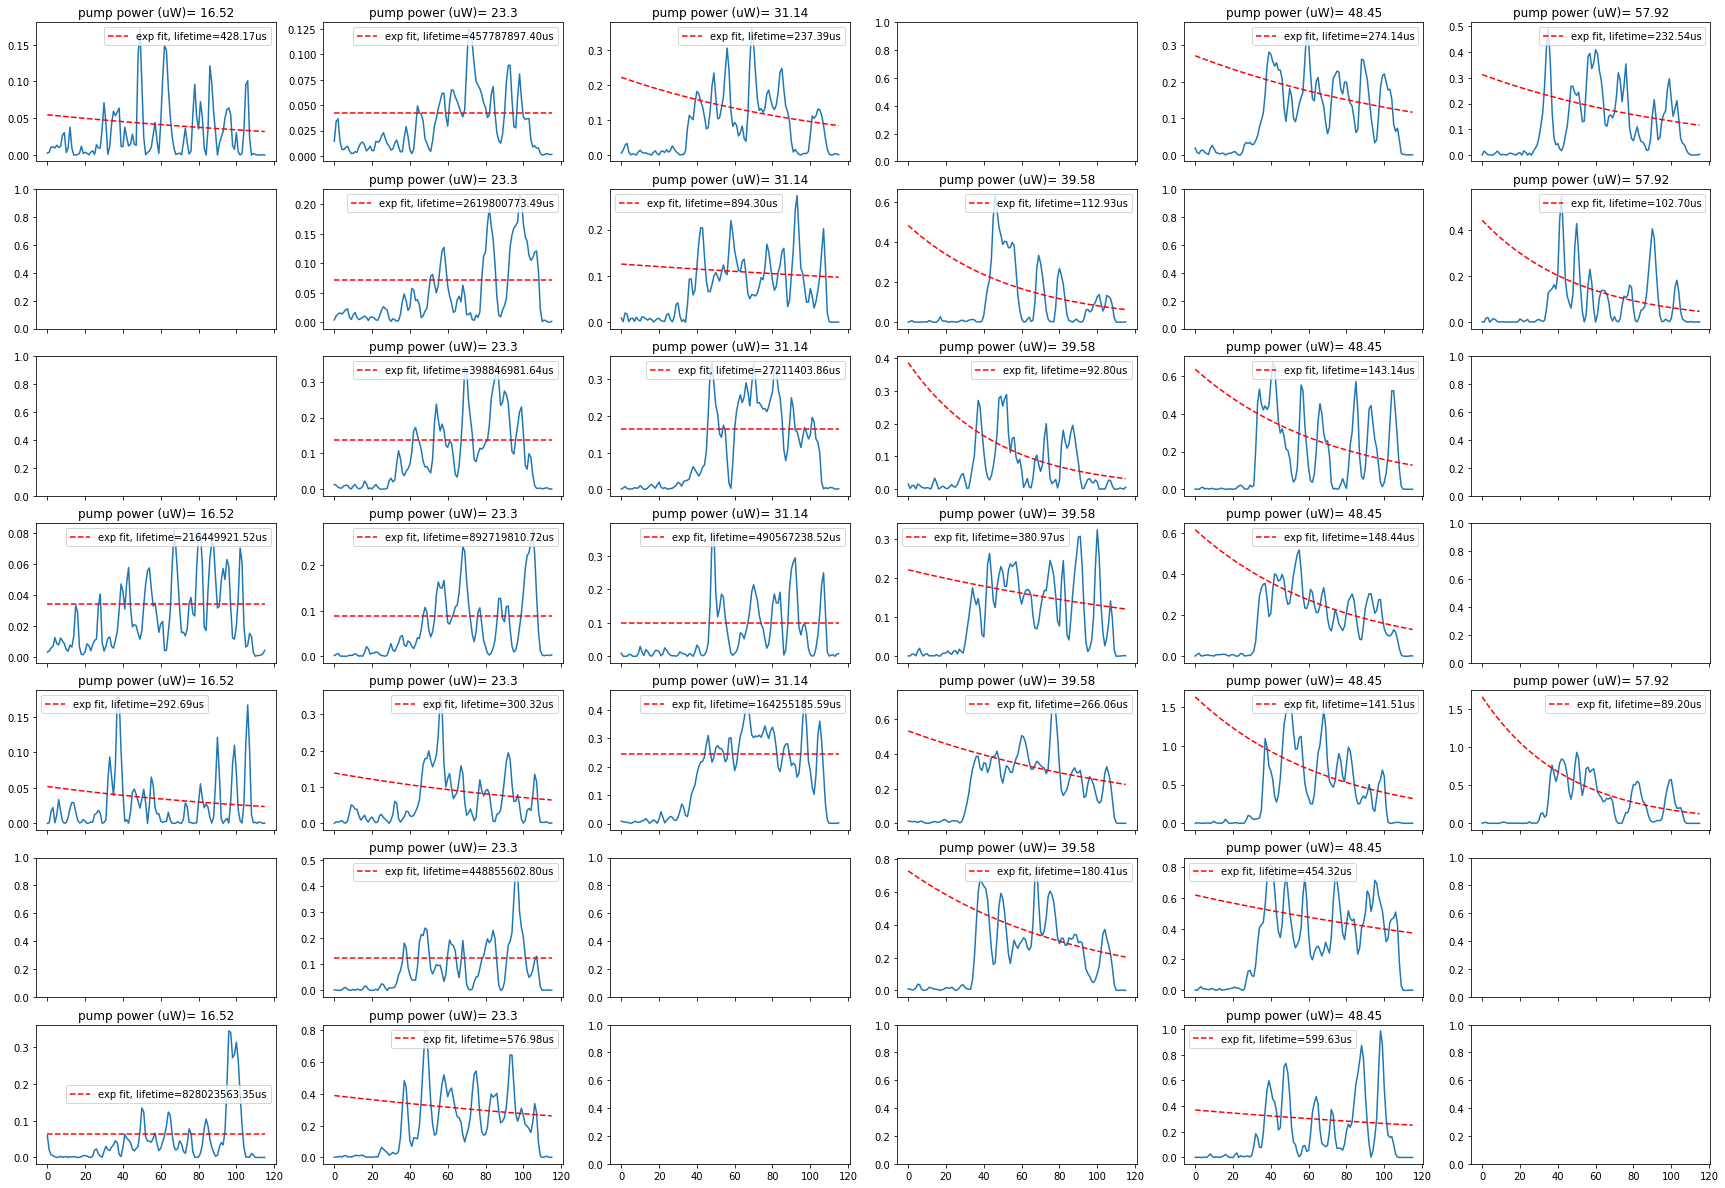

In [582]:
def exp_fit(x,A,t):
    return A*np.exp(-2*x/t)

fig,axs=plt.subplots(nrows=num_points_inner,ncols=num_points_outer, figsize=(5*num_points_outer,3*num_points_inner), sharex=True)
for point in range(num_points):
    if num_points==1:
        plt.sca(axs)
    elif num_points_inner==1:
        plt.sca(axs[point])
        outer_idx=point
    else:
        outer_idx, inner_idx = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
        plt.sca(axs[inner_idx, outer_idx])
    try:
        x = step_time*np.arange(len(photon_number_mean_point_list[point][1]))
        plt.plot(x, photon_number_mean_point_list[point][1])
        popt, pcov=curve_fit(exp_fit, x[bin_start:-5], photon_number_mean_point_list[point][1][bin_start:-5], p0=(1,100), maxfev=1000)
        plt.plot(x, exp_fit(x, *popt), '--', c='r', label=f'exp fit, lifetime={popt[1]:.2f}us')
        plt.title(f'{point_name_outer}= {np.round(point_list_outer[outer_idx],2)}') #, {point_name_inner}= {np.round(point_list_inner[inner_idx],2)}')
        plt.legend()
        plt.figure()
    except:
        pass

# Saving the projected time traces

In [583]:
df=pd.DataFrame(columns=['InnerPoint', 'OuterPoint', 'ProjectionArray1'],index=np.arange(num_points))

try:
    len_time=len(np.array(projected_amp_point_list[0])[0,0])
except:
    len_time=len(np.array(projected_amp_point_list[-1])[0,0])

for point in range(num_points):
    array_temp=np.zeros([num_masked_loop_list[point],len_time])
    outer_inx, inner_inx = get_outer_inner_point(point, num_points_outer, num_points_inner, parallel=point_parallel)
    
    df.OuterPoint[point] = point_list_outer[outer_inx]
    df.InnerPoint[point] = point_list_inner[inner_inx]
    try:
        df.ProjectionArray1[point]= np.array(np.array(projected_amp_point_list[point])[:,1])
        # df.ProjectionArray2[point]= np.array(np.array(projected_amp_point_list[point])[:,2])
    except:
        pass

In [584]:
df.to_pickle(f'field_data_N{twz_num_plot[0]}_{run_name}.pkl')

In [585]:
ssssstop = stop_now

NameError: name 'stop_now' is not defined

In [ ]:
def uniquebin(x, y):
    xbin = np.unique(np.array(x).astype('float'))
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    ybinmean_err = xbin * 0;
    for i in range(0, len(xbin)):
        ytemplist = y[x == xbin[i]]
        ybin[i] = np.nanmean(ytemplist)
        ybinerr[i] = np.nanstd(ytemplist)
        ybinmean_err[i] = ybinerr[i]/np.sqrt(np.sum(x == xbin[i]))
    return xbin, ybin, ybinerr,ybinmean_err

In [ ]:
df_N=pd.read_pickle(f'field_data_N{twz_num_plot[0]}_{run_name}.pkl')

In [ ]:
df=df_N.copy()

bin_init=35
bin_num=25
bin_time=step_time # in unit of us

field_list_all=[]
for inner_idx in range(num_points_inner):
    inner_point_plot=point_list_inner[inner_idx]
    mask_inner=np.abs(df['InnerPoint']-inner_point_plot)<0.01

    plot_index=df[mask_inner].index

    outer_array=np.zeros(len(plot_index))
    field_list=[]
    field_int=np.zeros(len(plot_index))
    field_int_err=np.zeros(len(plot_index))

    for n,i in enumerate(plot_index):
        try:
            outer_array[n]=df.OuterPoint[i]
        except:
            pass
        
    outer_array=np.sort(outer_array)    
    for n,i in enumerate(outer_array):
        try:
            mask_point=plot_index[np.argmax(np.abs(df['OuterPoint'][mask_inner]-i)<0.01)]
            c_array=np.ndarray.flatten(df.ProjectionArray1[mask_point][:,bin_init:bin_init+bin_num])
            # print(mask_point)
            field_list.append(c_array)
            field_int[n]=np.mean(c_array**2)
            field_int_err[n]=np.std(c_array**2)
        except:
            pass
    field_list_all.append(field_list)

In [ ]:
field_bin_hist_all=[]
field_bin_edge_all=[]
field_bin_center_all=[]
field_bin_width_all=[]


for inner_idx in range(num_points_inner):
    field_bin_edge=[]
    field_bin_center=[]
    field_bin_hist=[]
    field_bin_width=[]


    for i,p in enumerate(outer_array):
        try:
            hist_temp,bin_edge_temp=np.histogram(field_list_all[inner_idx][i],bins=20,range=(np.min(field_list_all[inner_idx][i])*1.2,np.max(field_list_all[inner_idx][i])*1.2))
            bin_temp=(bin_edge_temp[:-1]+bin_edge_temp[1:])/2
            bin_width_temp=(bin_edge_temp[1:]-bin_edge_temp[:-1])
            
            field_bin_hist.append(hist_temp)
            field_bin_edge.append(bin_edge_temp)
            field_bin_center.append(bin_temp)
            field_bin_width.append(bin_width_temp)
        except:
            pass
    field_bin_hist_all.append(field_bin_hist)
    field_bin_center_all.append(field_bin_center)
    field_bin_edge_all.append(field_bin_edge)
    field_bin_width_all.append(field_bin_width)

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

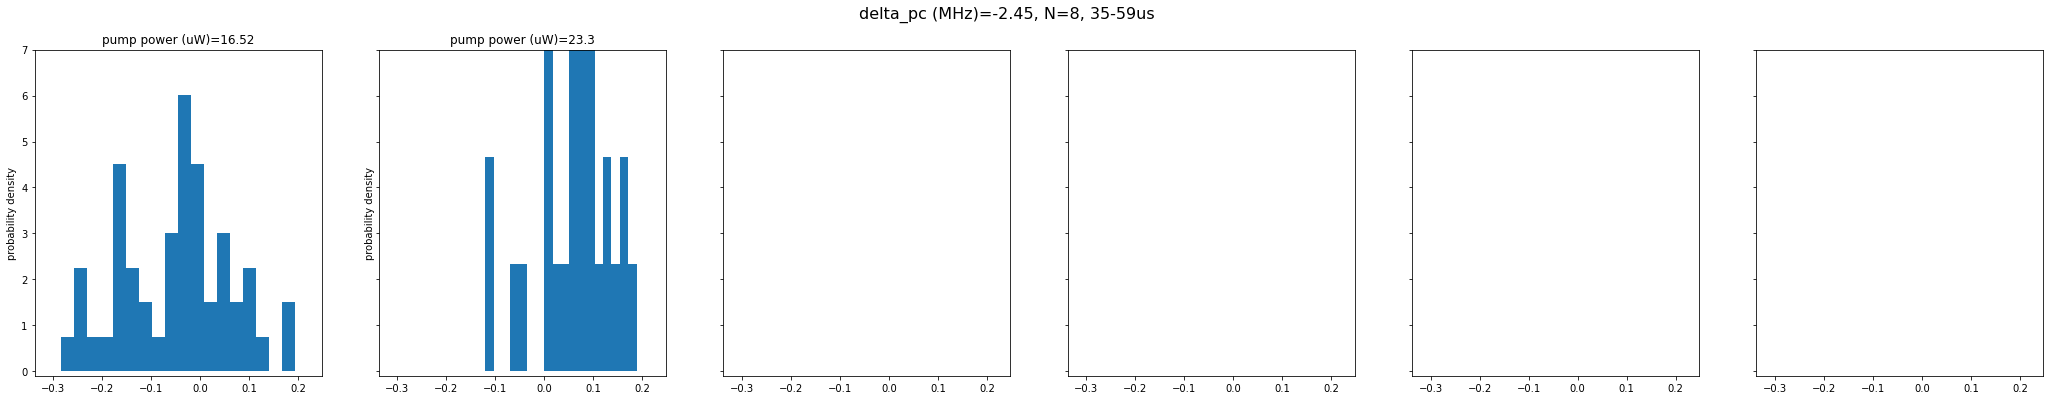

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

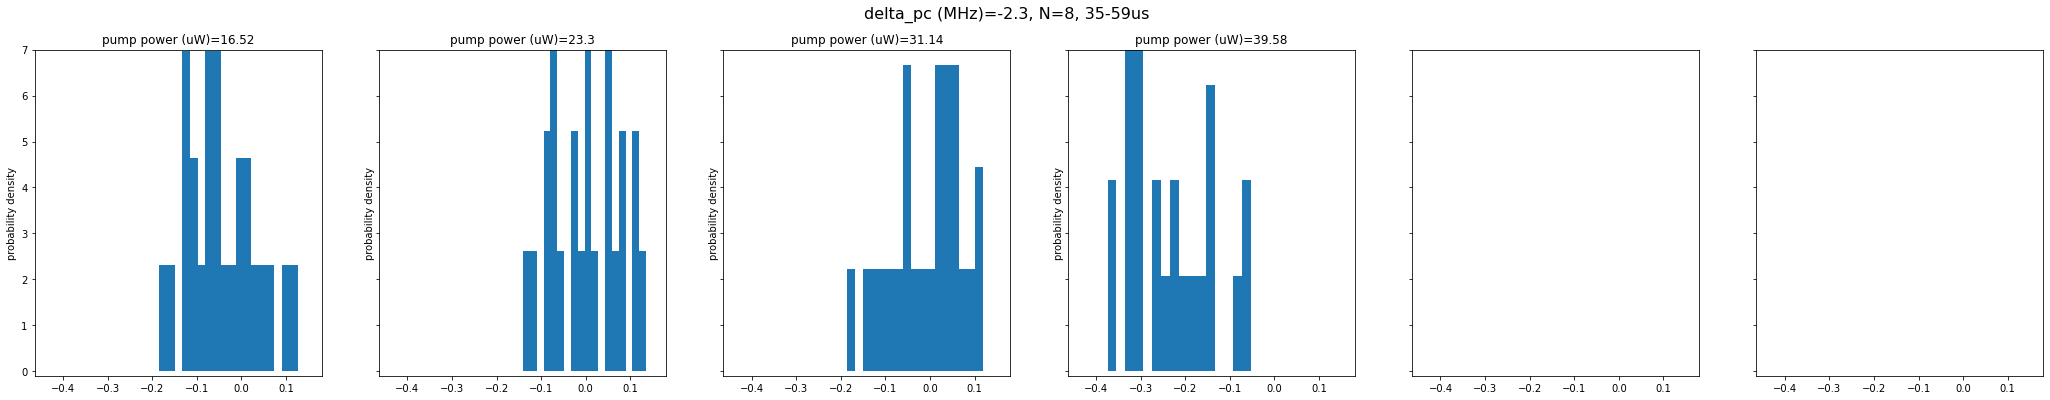

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

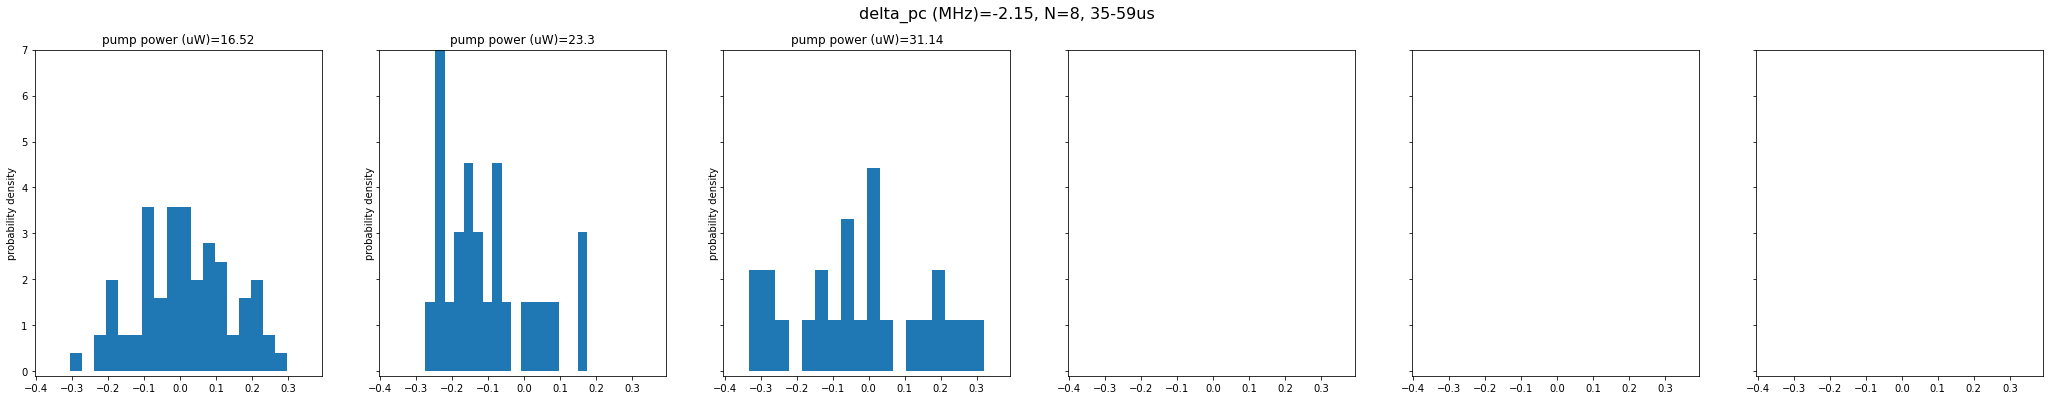

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

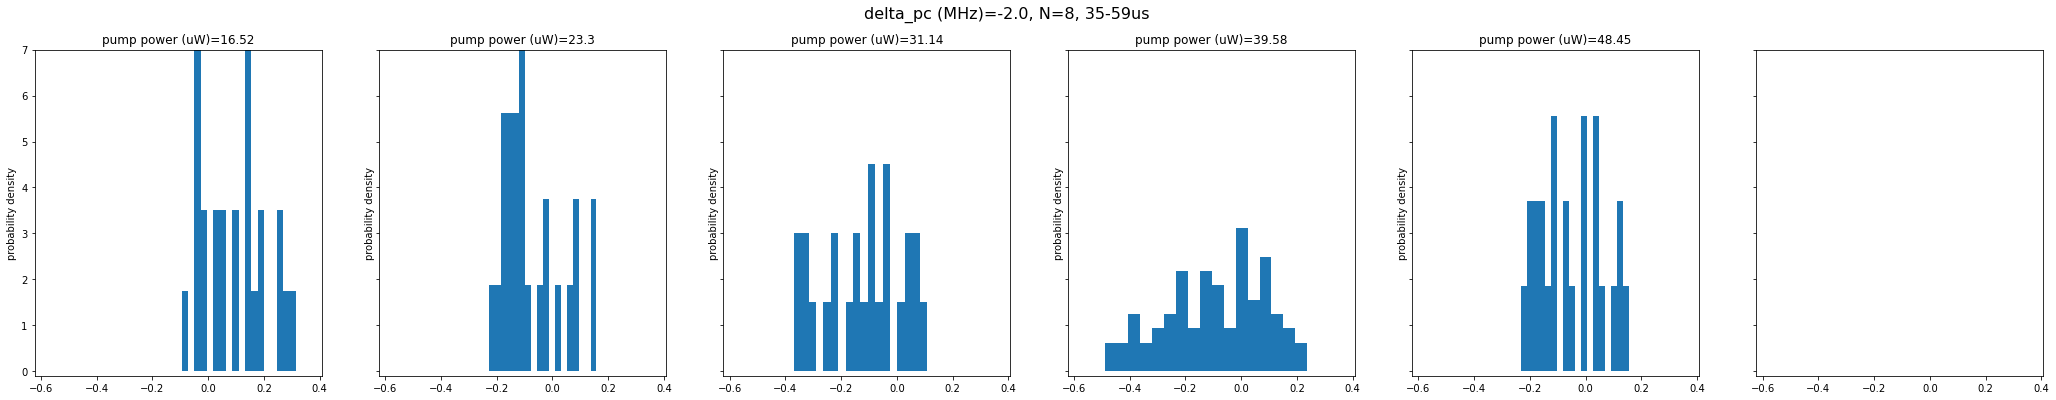

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

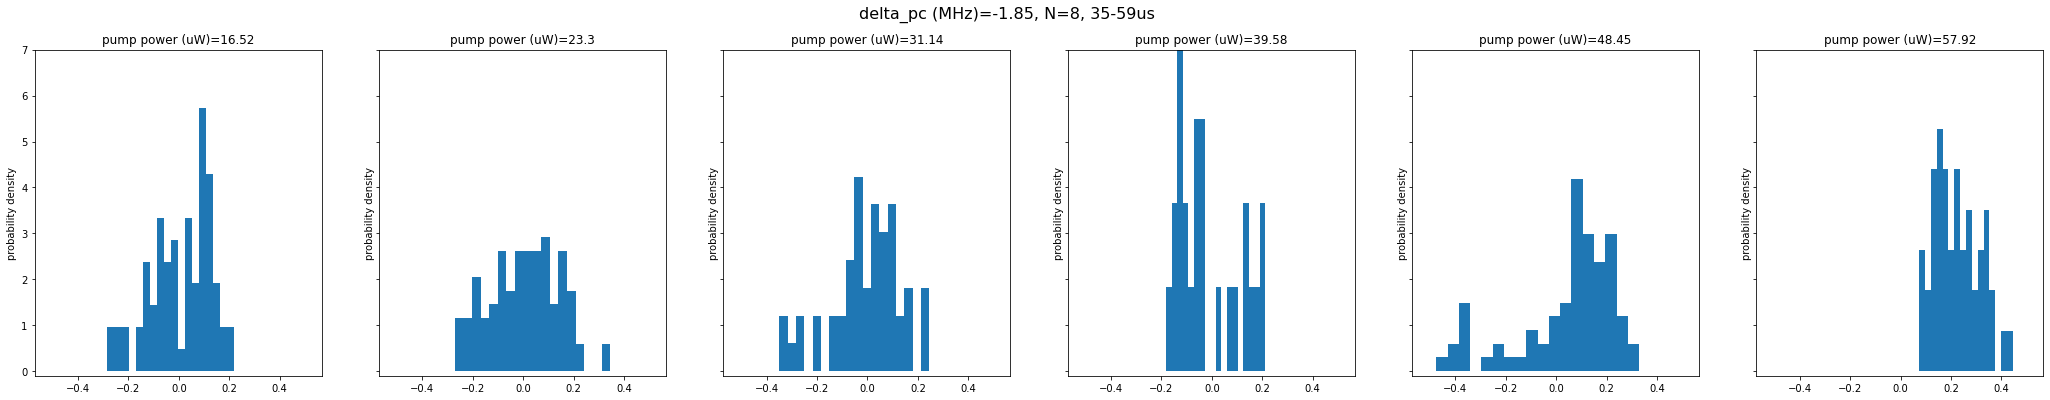

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

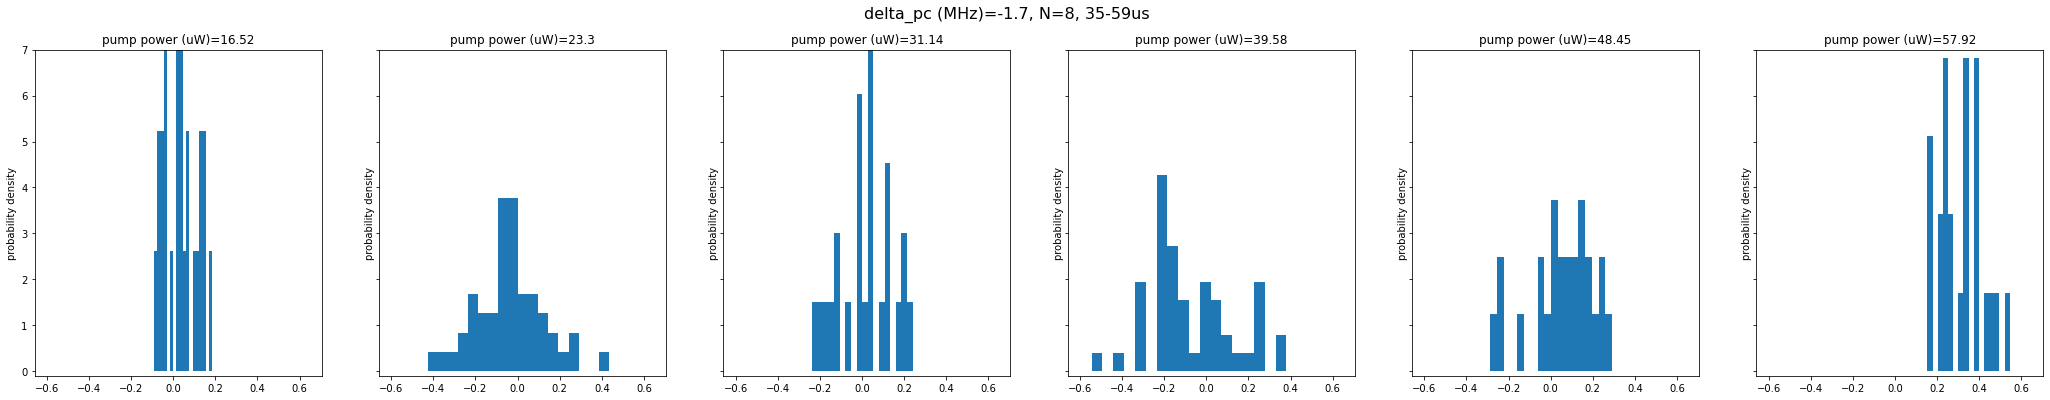

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

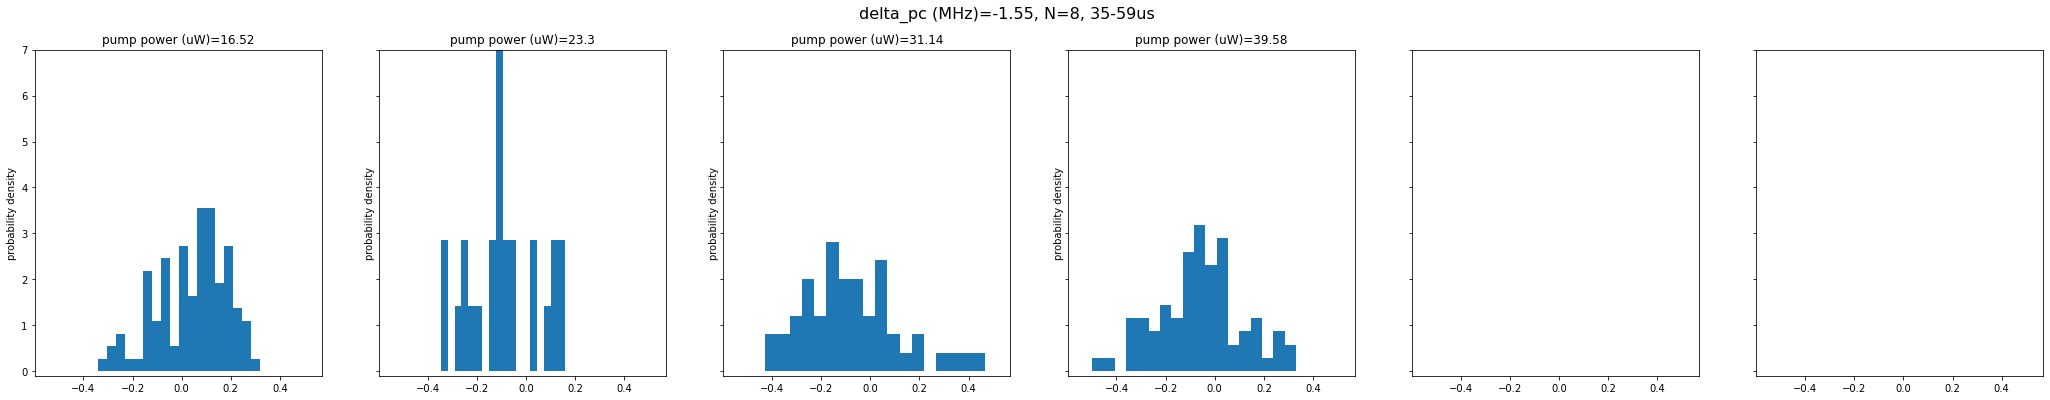

In [ ]:
for inner_idx in range(num_points_inner):
    fig,axs=plt.subplots(nrows=1,ncols=num_points_outer,figsize=(6*num_points_outer,6),sharey=True, sharex=True)
    plt.suptitle(f'{point_name_inner}={point_list_inner[inner_idx]}, N={twz_num_plot[0]}, {bin_init*step_time}-{(bin_init+bin_num-1)*step_time}us', fontsize=16)
    for k in range(len(point_list_outer)):
        if len(outer_array)==1:
            plt.sca(axs)
        else:
            plt.sca(axs[k])
        try:
            plt.bar(field_bin_center_all[inner_idx][k],field_bin_hist_all[inner_idx][k]/np.sum(field_bin_hist_all[inner_idx][k])/field_bin_width_all[inner_idx][k],width=field_bin_width_all[inner_idx][k])
            plt.title(f'{point_name_outer}={np.round(outer_array[k],2)}')
            plt.ylabel('probability density')
            plt.ylim(-0.1,7)
            plt.figure()
        except:
            pass

In [ ]:
num_points_inner

7

In [ ]:
# g1(t1,t2) = <c(t1)c(t2)>/sqrt(<c(t1)^2><c(t2)^2>), where brackets mean ensemble average

def g1(timetrace_array):
    num_timesteps=len(timetrace_array[0])
    t_list=bin_time*np.arange(num_timesteps)
    c1c2_avg=np.zeros((num_timesteps, num_timesteps))
    c_sq_avg=np.zeros(num_timesteps)
    for shot in range(len(timetrace_array)):
        c1c2=np.zeros((num_timesteps, num_timesteps))
        c_sq=timetrace_array[shot]**2
        c_sq_avg+=c_sq
        for t1 in range(num_timesteps):
            for t2 in range(num_timesteps):
                c1c2[t1,t2]=timetrace_array[shot][t1]*timetrace_array[shot][t2]
        c1c2_avg+=c1c2
    c1c2_avg=c1c2_avg/len(timetrace_array)
    c_sq_avg=c_sq_avg/len(timetrace_array)
    c1_sq, c2_sq=np.meshgrid(c_sq_avg, c_sq_avg)
    g1_arr=c1c2_avg/np.sqrt(c1_sq*c2_sq)
    return g1_arr, t_list

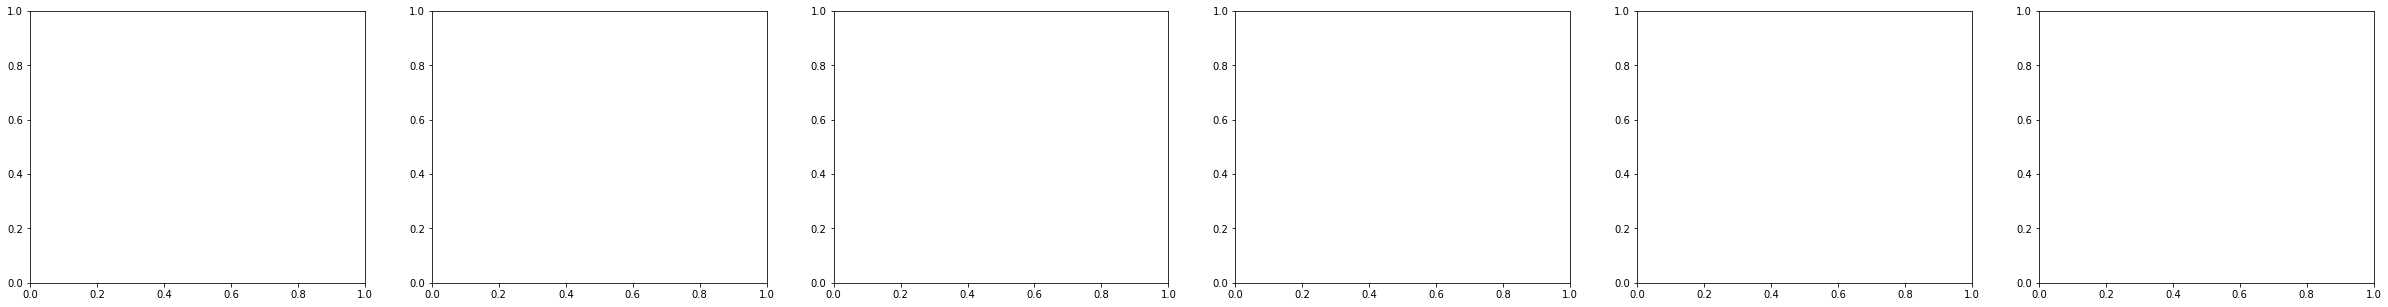

In [ ]:
if twz_num_plot[0] == 12:
    point_inner = 5
elif twz_num_plot[0] == 14:
    point_inner = 4
elif twz_num_plot[0] == 16:
    point_inner = 3
elif twz_num_plot[0] == 18:
    point_inner = 2
elif twz_num_plot[0] == 20:
    point_inner = 1
else:
    point_inner = 1000
fig,axs=plt.subplots(nrows=1,ncols=num_points_outer, figsize=(7*num_points_outer,5))
for point_ind_plot in range(len(point_list_outer)):
    point_idx = num_points_inner*point_ind_plot + point_inner
    if len(point_list_outer)==1:
        plt.sca(axs)
    else:
        plt.sca(axs[point_ind_plot])
    try:
        g1_arr, t_list = g1(df.ProjectionArray1[point_idx])
        plt.suptitle(f'{point_name_inner}={point_list_inner[point_inner]}, N={twz_num_plot[0]}', fontsize=26)
        plt.pcolormesh(t_list, t_list, g1_arr, shading='auto', cmap='bwr')
        plt.clim([-1,1])
        plt.colorbar()
        plt.xlabel('time (us)')
        plt.ylabel('time (us)')
        plt.title(f'g1(t1,t2) for {point_name_outer}={np.round(point_list_outer[point_ind_plot],2)}')
    except:
        pass

In [ ]:
# time-averaged g1: g1(tau)=<c(t)c(t+tau)>/<c(t)^2> where brackets are time average. Also do ensemble average at the end.

def g1_time_avg(timetrace_array):
    num_timesteps=len(timetrace_array[0])
    t_list=bin_time*np.arange(num_timesteps)
    g1_avg=np.zeros(num_timesteps)
    for shot in range(len(timetrace_array)):
        c1c2=np.zeros((num_timesteps, num_timesteps))
        c_sq=timetrace_array[shot]**2
        for t1 in range(num_timesteps):
            for t2 in range(num_timesteps):
                c1c2[t1,t2]=timetrace_array[shot][t1]*timetrace_array[shot][t2]
        # now do the time average over a single trace
        c1c2_1d=np.zeros(num_timesteps)
        for t in range(num_timesteps):
            c1c2_1d+=np.concatenate((c1c2[t,t:],np.zeros(t)))
        c1c2_1d=c1c2_1d/np.flip(np.arange(1,num_timesteps+1))
        g1_shot=c1c2_1d/np.mean(c_sq)
        g1_avg+=g1_shot
    g1_avg=g1_avg/len(timetrace_array)
    return g1_avg, t_list

In [ ]:
len(t0_list)

116

In [ ]:
t1=bin_start
t2=100

g1_time0_arr_N = []
g1_t_avg_arr_N = []
outer_array_N = []
inner_array_N=[]


outer_plot=df.OuterPoint[0]
mask_outer=np.abs(df['OuterPoint']-outer_plot)<0.1


inner_plot=df.InnerPoint[0]
mask_inner=np.abs(df['InnerPoint']-inner_plot)<0.1

plot_index=df[mask_inner].index
power_array=np.zeros(len(plot_index))

for n,i in enumerate(plot_index):
    power_array[n]=df.OuterPoint[i]

plot_index=df[mask_outer].index
inner_array=np.zeros(len(plot_index))

for n,i in enumerate(plot_index):
    inner_array[n]=df.InnerPoint[i]

num_points=df.ProjectionArray1.shape[0]
g1_time0_arr=np.zeros((len(inner_array),len(outer_array),len(df.ProjectionArray1[0][0][t1:t2])))
g1_time0_arr[:]=np.nan
g1_t_avg_arr=np.zeros((len(inner_array),len(outer_array),len(df.ProjectionArray1[0][0][t1:t2])))
g1_t_avg_arr[:]=np.nan
for i in range(num_points):
    inner_ind = i % len(inner_array)
    power_ind = int(np.round(i-inner_ind)/len(inner_array))
    try:
        g1_time0_arr[inner_ind,power_ind]=g1(df.ProjectionArray1[i][:,t1:t2])[0][0]
        g1_t_avg_arr[inner_ind,power_ind]=g1_time_avg(df.ProjectionArray1[i][:,t1:t2])[0]
    except:
        print(f'error at inner_ind={inner_ind}, outer_ind={power_ind}')
g1_time0_arr_N.append(g1_time0_arr)
g1_t_avg_arr_N.append(g1_t_avg_arr)
outer_array_N.append(outer_array)
inner_array_N.append(inner_array)

error at inner_ind=1, outer_ind=0
error at inner_ind=6, outer_ind=0
error at inner_ind=0, outer_ind=1
error at inner_ind=2, outer_ind=1
error at inner_ind=3, outer_ind=1
error at inner_ind=6, outer_ind=1
error at inner_ind=0, outer_ind=2
error at inner_ind=2, outer_ind=2
error at inner_ind=0, outer_ind=4
error at inner_ind=1, outer_ind=4
error at inner_ind=0, outer_ind=5
error at inner_ind=2, outer_ind=5


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

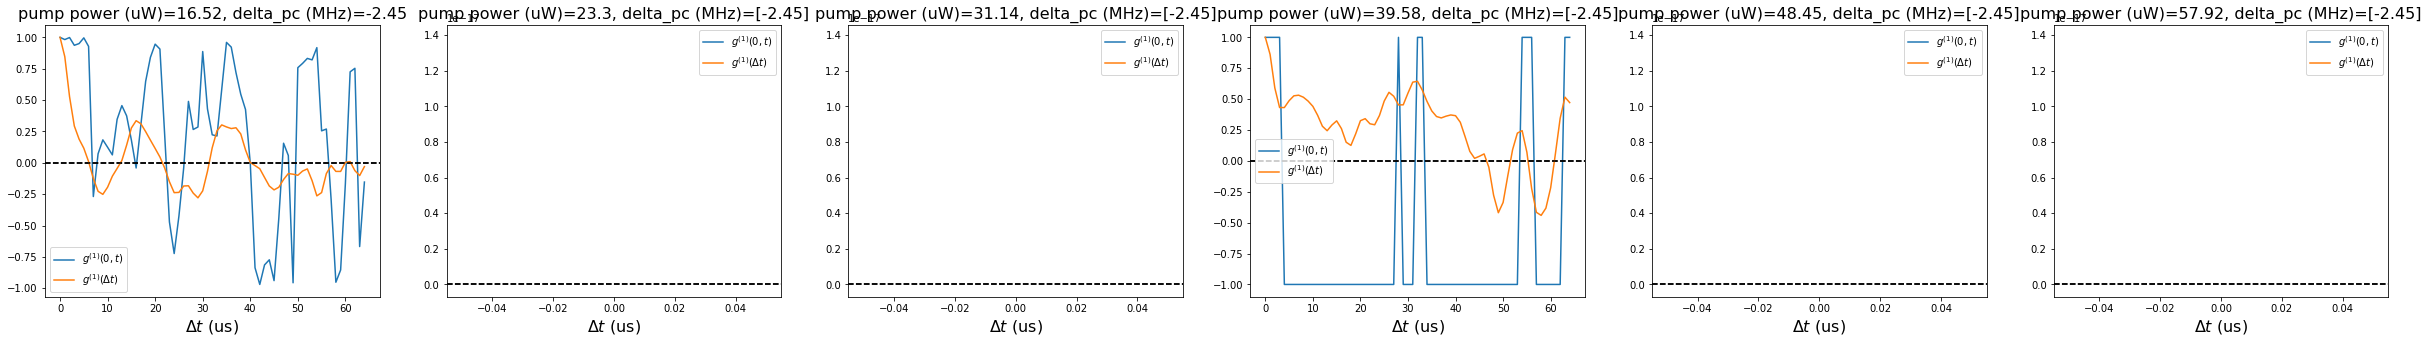

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

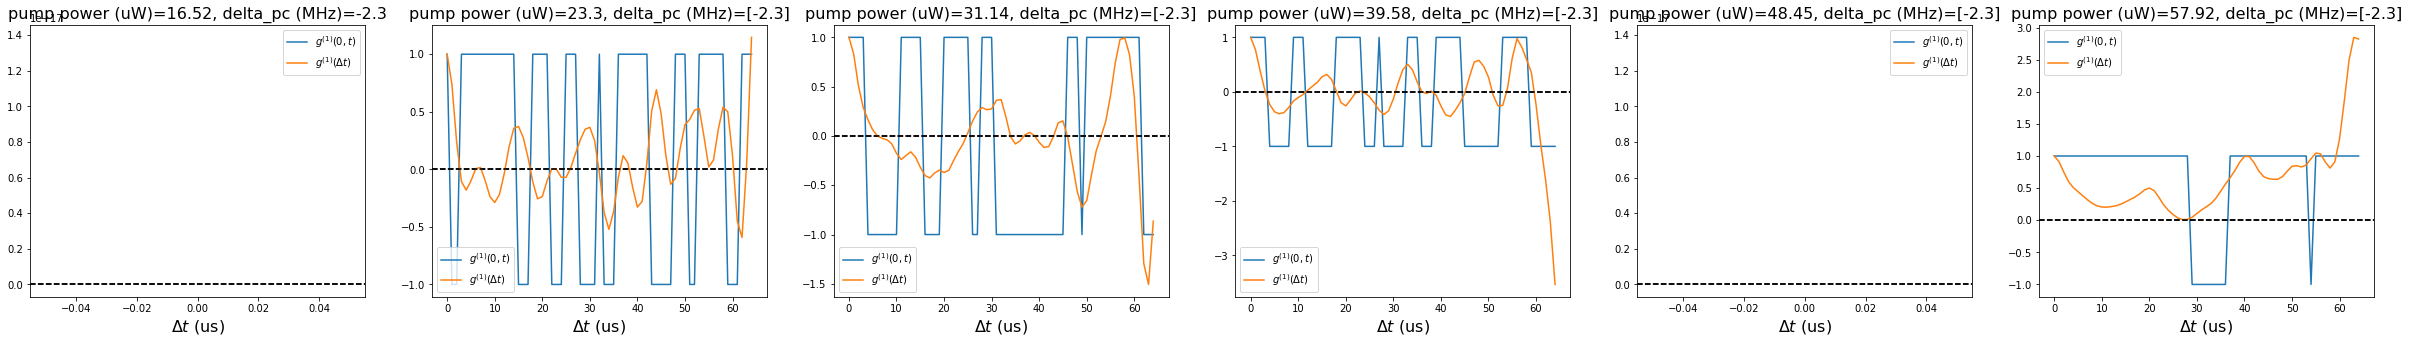

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

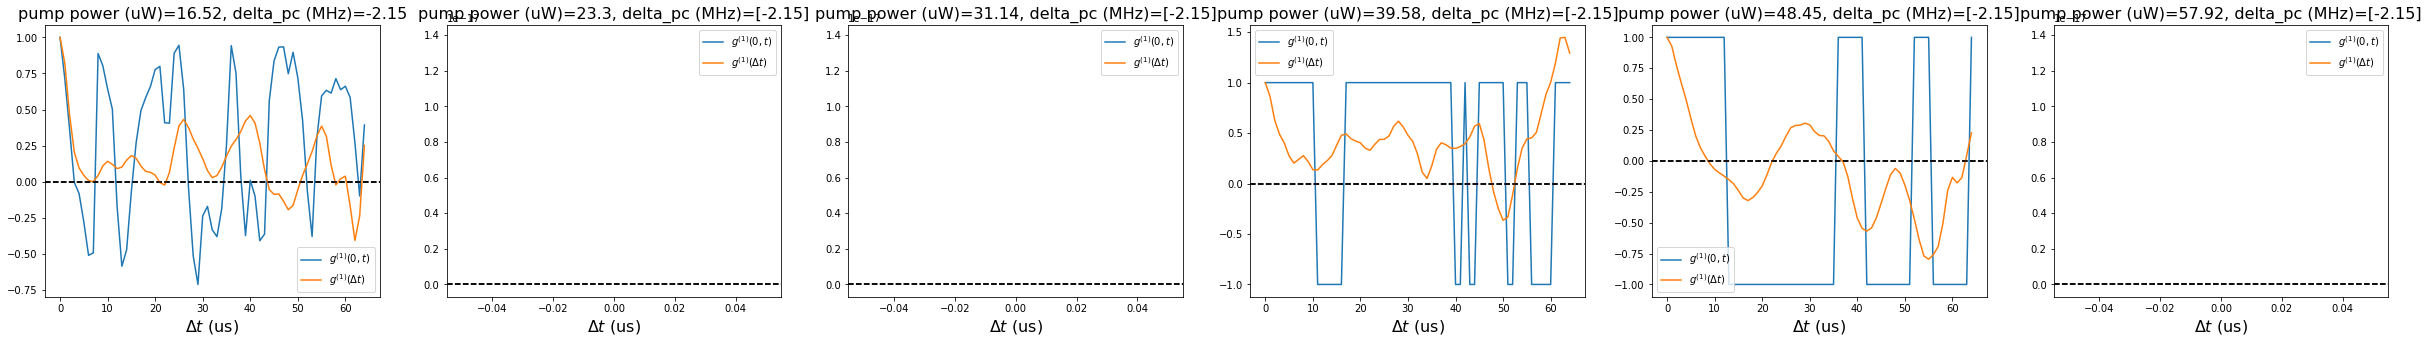

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

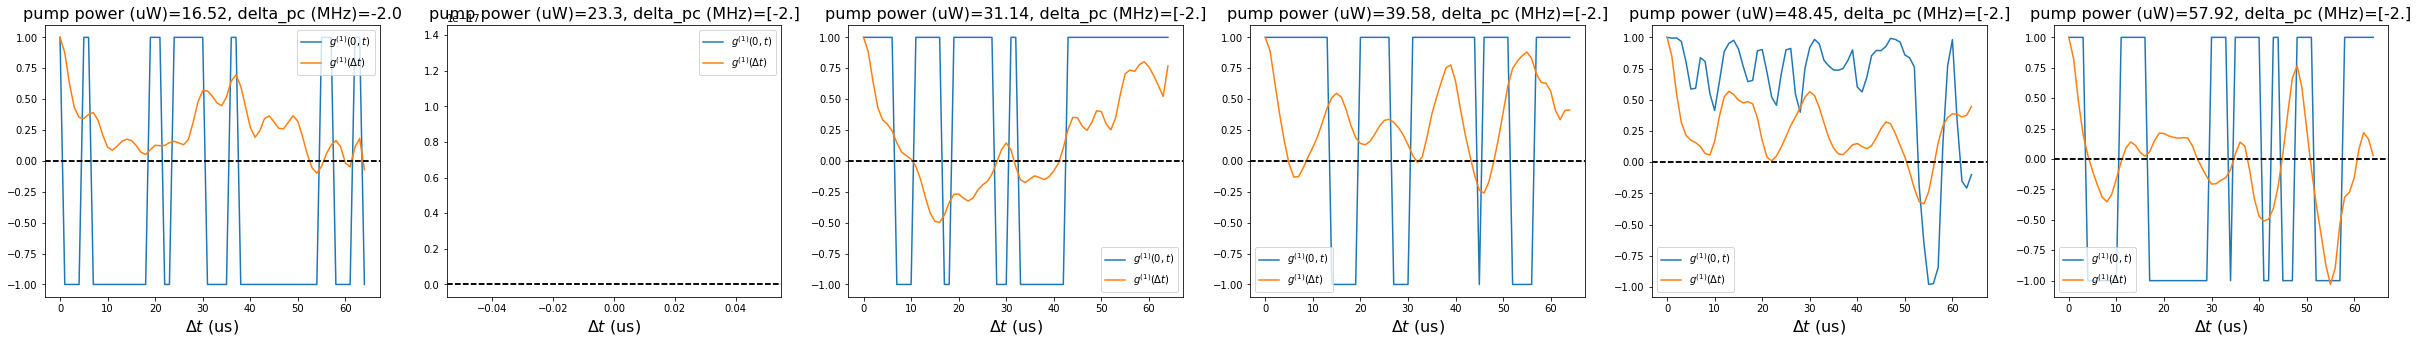

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

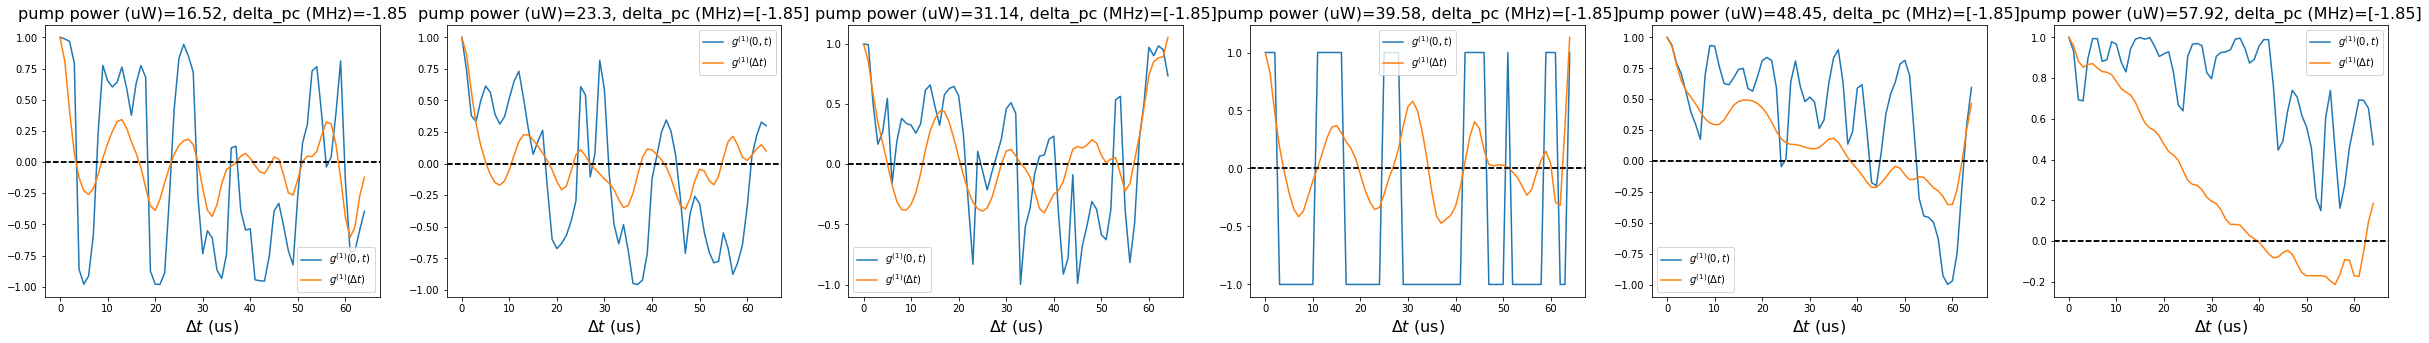

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

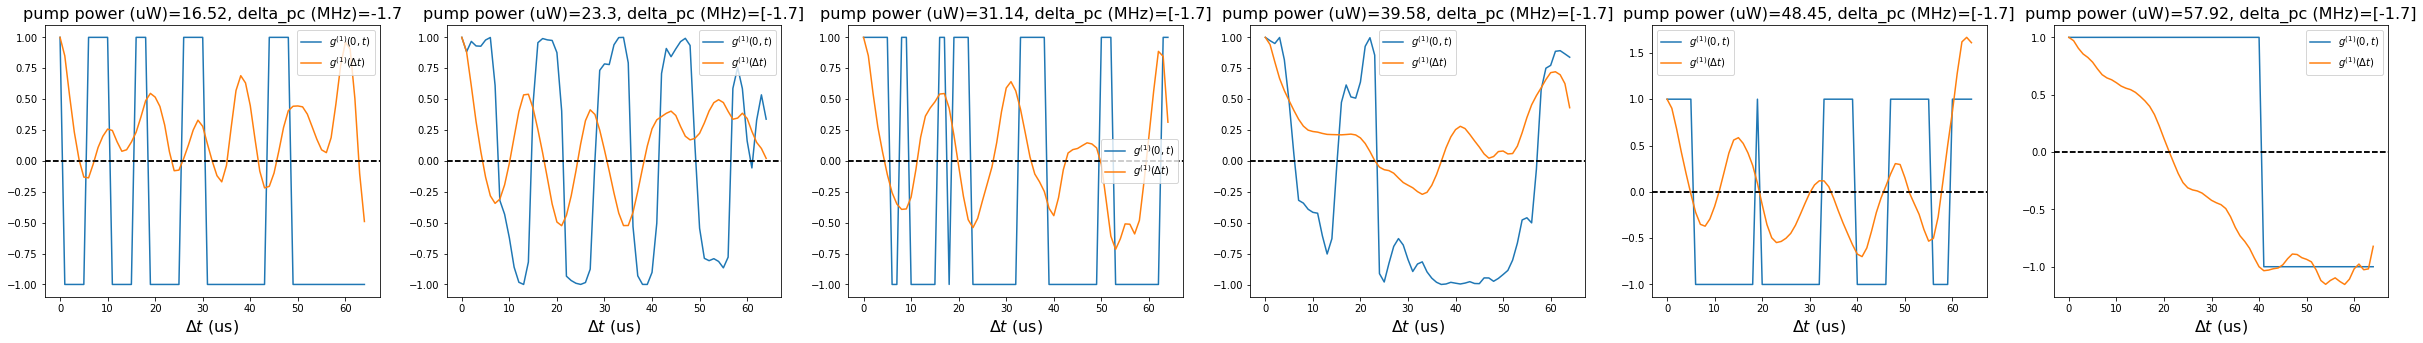

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

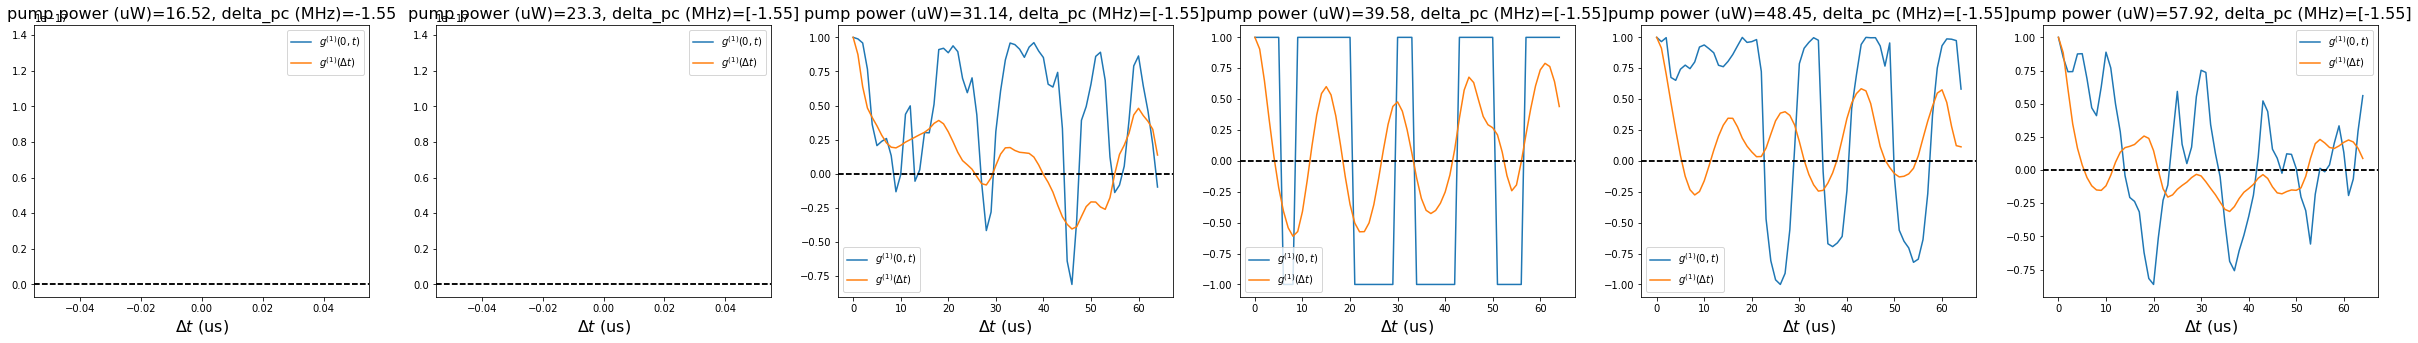

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot g1_time0 vs N, fixed detuning and sideprobe power
for inner_ind in range(num_points_inner):

    fig,axs=plt.subplots(nrows=1,ncols=num_points_outer, figsize=(7*num_points_outer,5))
    for point in range(num_points_outer):
        if num_points==1:
            plt.sca(axs)
        else:
            plt.sca(axs[point])
        inner_plot=np.round(point_list_inner[inner_ind],2)
        outer_plot=np.round(point_list_outer[point],2)
        for num_ind in range(1): #range(len(num_array)):
            inner_ind = np.where(np.round(inner_array_N[num_ind]-inner_plot,2)==0)
            outer_ind = np.where(np.round(outer_array_N[num_ind]-outer_plot,2)==0)
            plt.plot(bin_time*np.arange(t2-t1), g1_time0_arr_N[num_ind][inner_ind,outer_ind][0][0],
                    label='$g^{(1)}(0,t)$')
        plt.legend()
        plt.axhline(0, c='k', ls='--')
        plt.xlabel('t (us)', fontsize=16)
        plt.title(f'{point_name_outer}={outer_plot}, {point_name_inner}={inner_plot}',fontsize=16)
        plt.figure()

        # plot g1_t_avg vs N, fixed detuning and sideprobe power
        if num_points==1:
            plt.sca(axs)
        else:
            plt.sca(axs[point])
        for num_ind in range(1): #range(len(num_array)):
            # detuning_ind = np.where((inner_array_N[num_ind]-inner_plot)==0)
            # power_ind = np.where(np.round(outer_array_N[num_ind]-outer_plot)==0)
            plt.plot(bin_time*np.arange(t2-t1), g1_t_avg_arr_N[num_ind][inner_ind,outer_ind][0][0],
                    label='$g^{(1)}(\Delta t)$')
        plt.legend()
        plt.axhline(0, c='k', ls='--')
        plt.xlabel('$\Delta t$ (us)', fontsize=16)
        plt.title(f'{point_name_outer}={outer_plot}, {point_name_inner}={inner_plot}',fontsize=16)
        plt.figure()

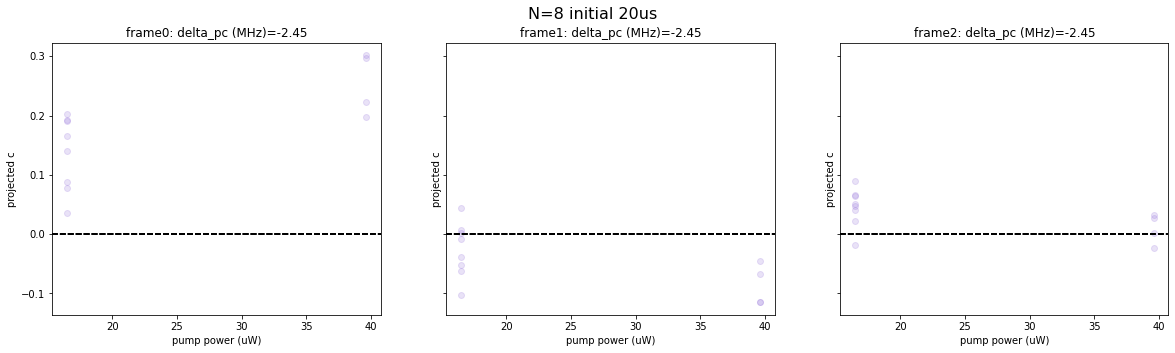

<Figure size 432x288 with 0 Axes>

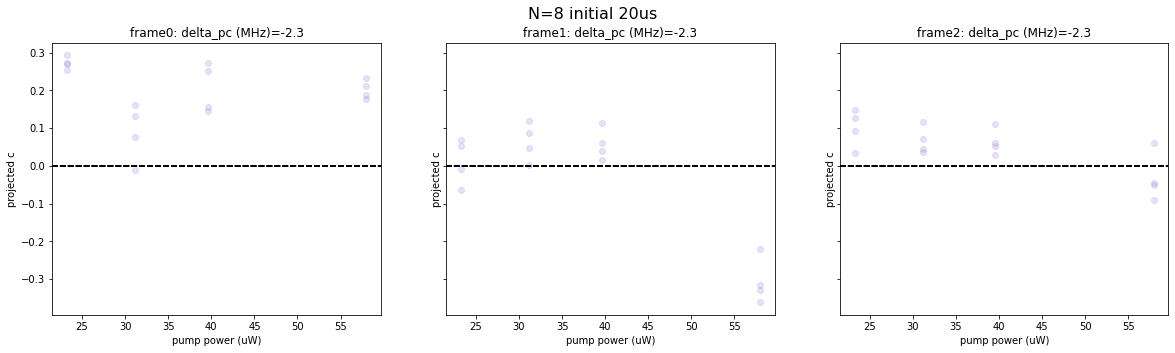

<Figure size 432x288 with 0 Axes>

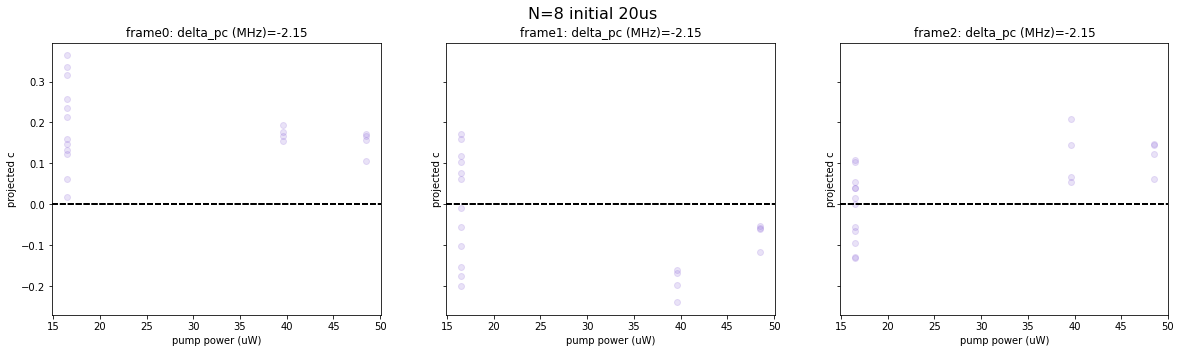

<Figure size 432x288 with 0 Axes>

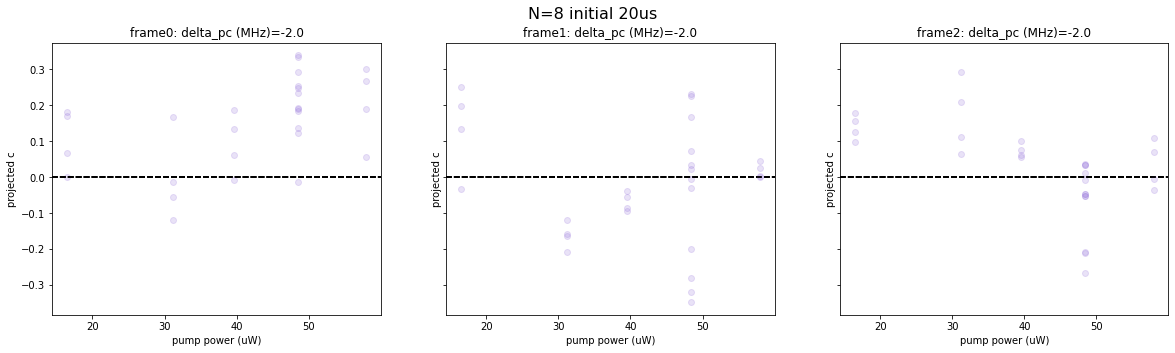

<Figure size 432x288 with 0 Axes>

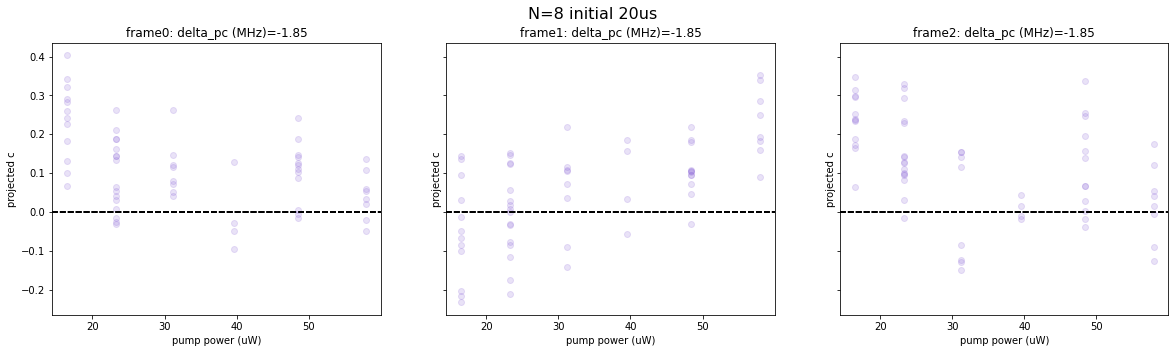

<Figure size 432x288 with 0 Axes>

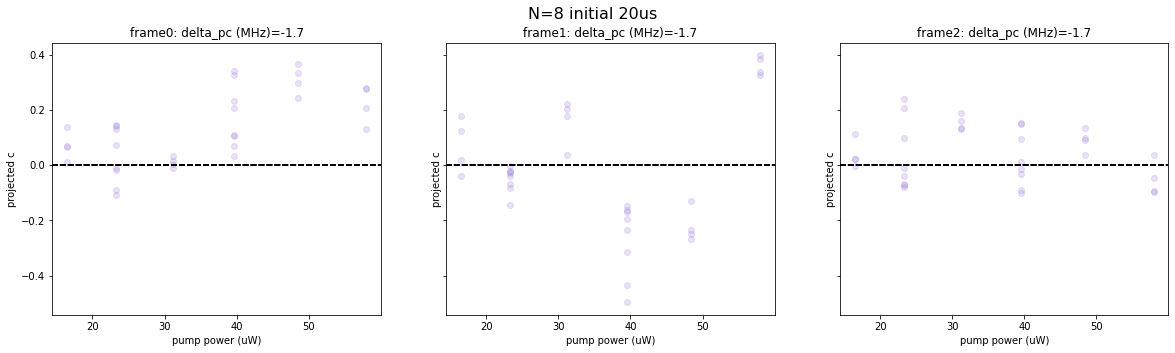

<Figure size 432x288 with 0 Axes>

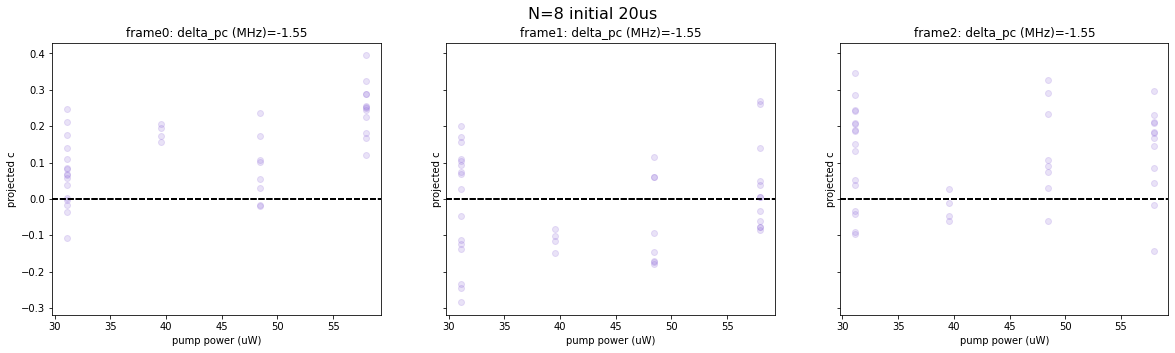

<Figure size 432x288 with 0 Axes>

In [ ]:
num_bins_plot = 4 
for inner_point_ind in range(num_points_inner):
    fig,axs=plt.subplots(ncols=num_frames_cav, nrows=1,figsize=(20,5), sharey=True)
    plt.suptitle(f'N={twz_num_plot[0]} initial {num_bins_plot*filter_time}us', fontsize=16)

    for frame in range(num_frames_cav):
        plt.sca(axs[frame])
        for point in range(num_points)[inner_point_ind::num_points_inner]:
            if len(np.array(projected_amp_point_list[point]))!=0:
                y =  np.concatenate(np.array(projected_amp_point_list[point])[:,frame][:,bin_start:bin_start+num_bins_plot]) #np.concatenate(np.array(projected_amp_point_list[point])[:,frame]) 
                x = point_list_outer[int((point-inner_point_ind)/num_points_inner)]*np.ones(len(y))
                # print(point_list_outer[int((point-inner_point_ind)/num_points_inner)])
                plt.plot(x,y,'o',alpha=0.2,c='mediumpurple')
            plt.title(f'frame{frame}: {point_name_inner}={np.round(point_list_inner[inner_point_ind],2)}')
            plt.ylabel('projected c')
            plt.xlabel(f'{point_name_outer}')
            plt.axhline(0, c='k', ls='--')
    # plt.sca(axs[-1])
    # for frame in range(num_frames_cav):
    #     for point in range(num_points)[inner_point_ind::num_points_inner]:
    #         if len(np.array(projected_amp_point_list[point]))!=0:
    #             y = np.concatenate(np.array(projected_amp_point_list[point])[:,frame]) 
    #             x = point_list_outer[int((point-inner_point_ind)/num_points_inner)]*np.ones(len(y))
    #             plt.plot(x,y,'o',alpha=0.1,c='mediumpurple',label=f'{point_name_inner}={point_list_inner[inner_point_ind]}')
    #     plt.title(f'all frames: {point_name_inner}={np.round(point_list_inner[inner_point_ind],2)}')
    #     plt.ylabel('projected c')
    #     plt.xlabel(f'{point_name_outer}')
    plt.figure()
    
    
    

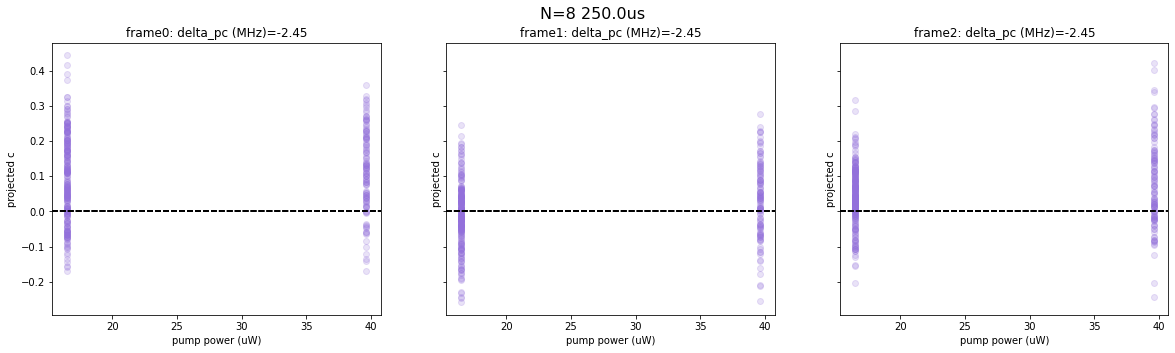

<Figure size 432x288 with 0 Axes>

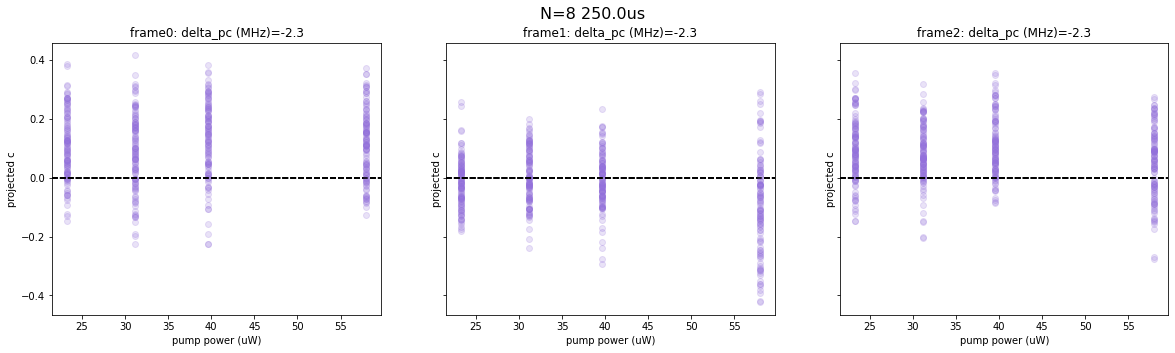

<Figure size 432x288 with 0 Axes>

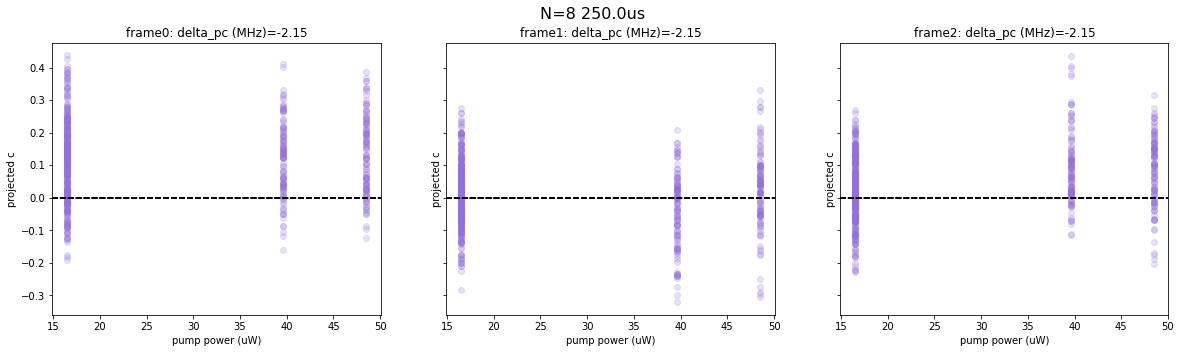

<Figure size 432x288 with 0 Axes>

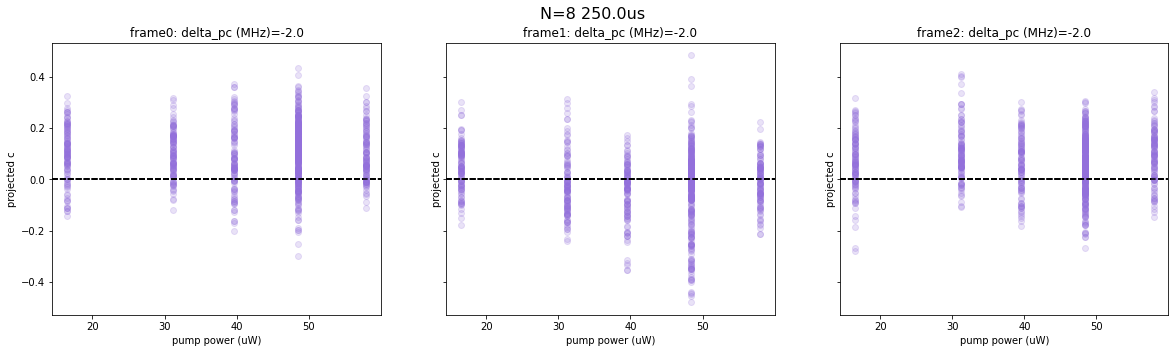

<Figure size 432x288 with 0 Axes>

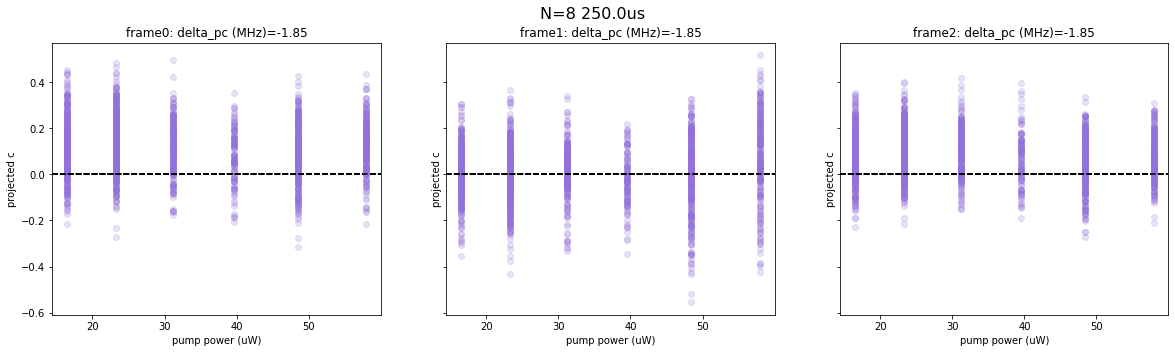

<Figure size 432x288 with 0 Axes>

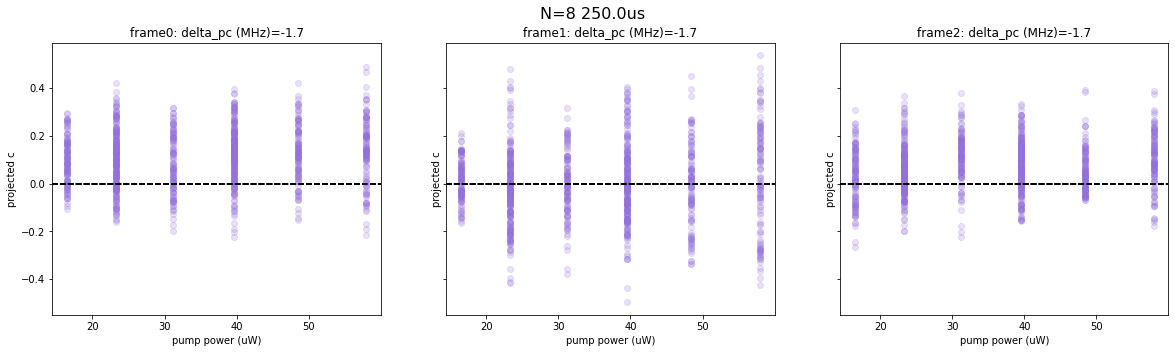

<Figure size 432x288 with 0 Axes>

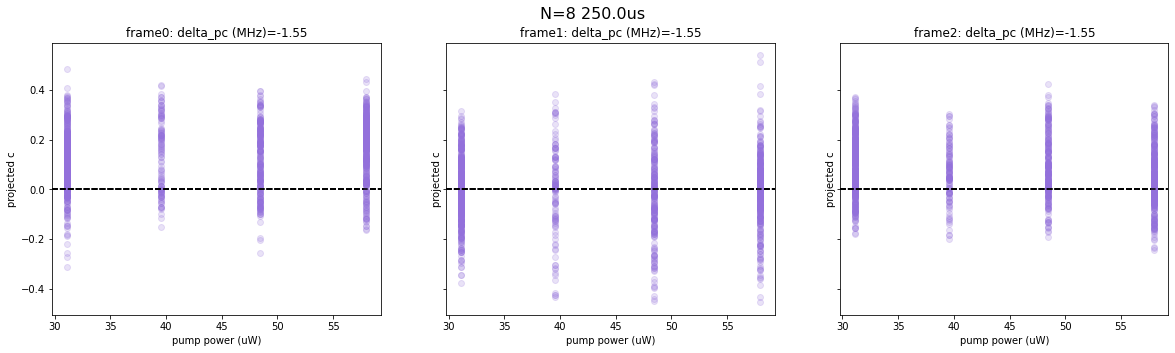

<Figure size 432x288 with 0 Axes>

In [ ]:
for inner_point_ind in range(num_points_inner):
    fig,axs=plt.subplots(ncols=num_frames_cav, nrows=1,figsize=(20,5), sharey=True)
    plt.suptitle(f'N={twz_num_plot[0]} {t_cav_expo}us', fontsize=16)

    for frame in range(num_frames_cav):
        plt.sca(axs[frame])
        for point in range(num_points)[inner_point_ind::num_points_inner]:
            if len(np.array(projected_amp_point_list[point]))!=0:
                y =  np.concatenate(np.array(projected_amp_point_list[point])[:,frame][:,:]) #np.concatenate(np.array(projected_amp_point_list[point])[:,frame]) 
                x = point_list_outer[int((point-inner_point_ind)/num_points_inner)]*np.ones(len(y))
                # print(point_list_outer[int((point-inner_point_ind)/num_points_inner)])
                plt.plot(x,y,'o',alpha=0.2,c='mediumpurple')
            plt.title(f'frame{frame}: {point_name_inner}={np.round(point_list_inner[inner_point_ind],2)}')
            plt.ylabel('projected c')
            plt.xlabel(f'{point_name_outer}')
            plt.axhline(0, c='k', ls='--')
    # plt.sca(axs[-1])
    # for frame in range(num_frames_cav):
    #     for point in range(num_points)[inner_point_ind::num_points_inner]:
    #         if len(np.array(projected_amp_point_list[point]))!=0:
    #             y = np.concatenate(np.array(projected_amp_point_list[point])[:,frame]) 
    #             x = point_list_outer[int((point-inner_point_ind)/num_points_inner)]*np.ones(len(y))
    #             plt.plot(x,y,'o',alpha=0.1,c='mediumpurple',label=f'{point_name_inner}={point_list_inner[inner_point_ind]}')
    #     plt.title(f'all frames: {point_name_inner}={np.round(point_list_inner[inner_point_ind],2)}')
    #     plt.ylabel('projected c')
    #     plt.xlabel(f'{point_name_outer}')
    plt.figure()
    
    
    

# Time traces

theta_begin 1.6082095893247514
theta_dir 3.0774011290536123
theta_diff (deg) -64.26234730673168
181.3814076681446 deg here2
1.3814076681445995 deg here3
rotation angle (deg) 359.3092961659277


<Figure size 1152x576 with 0 Axes>

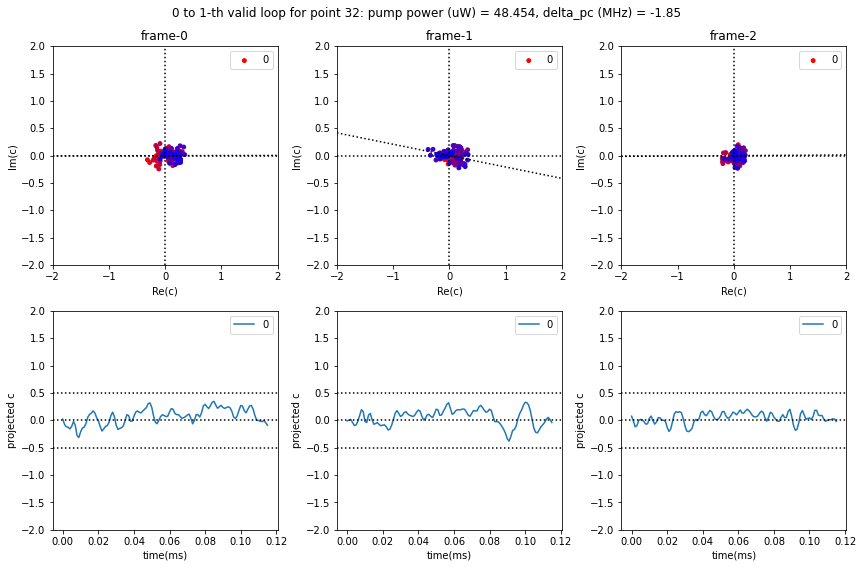

theta_begin -2.1680850168497328
theta_dir -2.2159383730372295
theta_diff (deg) -39.23990277835625
5.054734028209899 deg here1
rotation angle (deg) 357.4726329858951


<Figure size 1152x576 with 0 Axes>

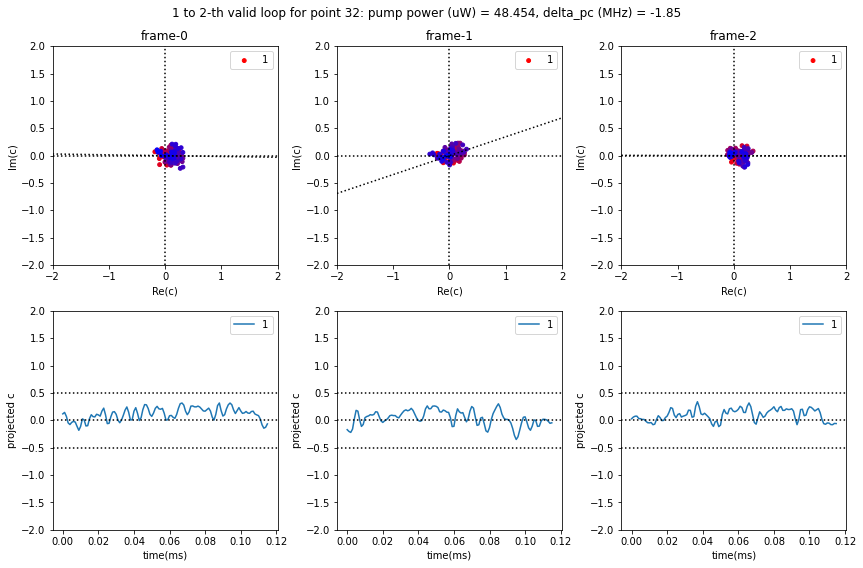

theta_begin -8.005115546175556
theta_dir -7.11927127768492
theta_diff (deg) 124.93540389910581
-381.0035232749717 deg here1
rotation angle (deg) 10.501761637485851


<Figure size 1152x576 with 0 Axes>

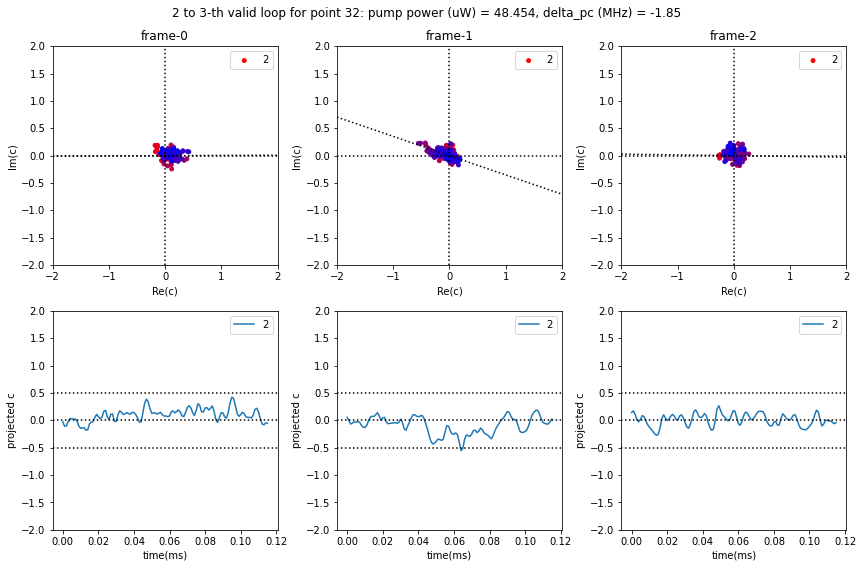

<Figure size 1152x576 with 0 Axes>

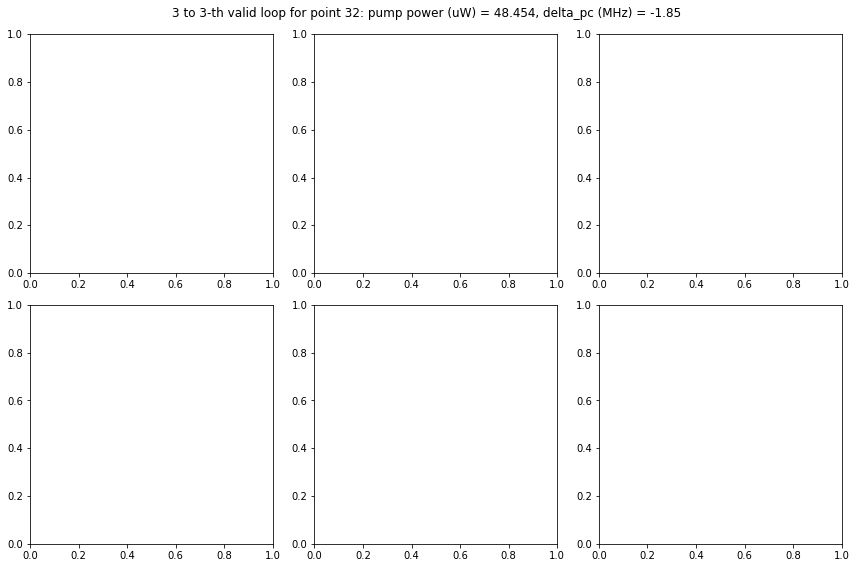

In [ ]:
begin_frame = 0
end_frame = 2

group_loop_num = 1

outer_idx = 4

inner_idx = 4

if point_parallel:    
    mask_inner_point = np.zeros(num_points)
    mask_inner_point[inner_idx::num_points_inner] = 1
    mask_outer_point = np.zeros(num_points) 
    mask_outer_point[outer_idx::num_points_outer] = 1
    point = np.argmax(mask_inner_point*mask_outer_point)
else:
    point = outer_idx*num_points_inner + inner_idx
num_masked_loop_point=len(x_quad_frame_array_point[point])
for loop_group in range(num_masked_loop_point//group_loop_num+1):
    
    plt.figure(figsize=(16,8))
    fig,axes = plt.subplots(nrows=2, ncols=num_frames_cav,figsize=(4*num_frames_cav,8))
            

        
    for i in range(loop_group*group_loop_num, min((loop_group+1)*group_loop_num, num_masked_loop_point)): #range(num_masked_loop_max-10,num_masked_loop_max):
        theta_frame_list = []
        for frame in range(num_frames_cav):

            x = x_quad_frame_array_point[point][i,frame][0:110]
            y = p_quad_frame_array_point[point][i,frame][0:110]
            
            theta0 = basephase_frame_array_point[point][i,frame]
            theta_print = np.mean(np.unwrap(phase_frame_array_point[point][i,frame]-theta0))
            theta_begin = np.mean(np.unwrap(phase_frame_array_point[point][i,begin_frame]\
                                            - basephase_frame_array_point[point][i,begin_frame])[bin_start:60])
            theta_end = np.mean(np.unwrap(phase_frame_array_point[point][i,end_frame]\
                                         - basephase_frame_array_point[point][i,end_frame])[bin_start:60])
            theta_middle = np.mean(np.unwrap(phase_frame_array_point[point][i,1]\
                                         - basephase_frame_array_point[point][i,1])[bin_start:60])
            while (theta_end-theta_begin > np.pi): theta_end -= 2*np.pi
            while (theta_end-theta_begin < -np.pi): theta_end += 2*np.pi
            # theta_interp = theta_begin + (theta_end-theta_begin)*(frame-begin_frame)/(end_frame-begin_frame)
#             
            x_rotated = x*np.cos(theta0)[0:110]+y*np.sin(theta0)[0:110]
            y_rotated = -x*np.sin(theta0)[0:110]+y*np.cos(theta0)[0:110]
        
            cov_temp = np.array([[x_rotated@x_rotated,x_rotated@y_rotated],[x_rotated@y_rotated,y_rotated@y_rotated]])
            eigenValues, eigenVectors = np.linalg.eig(cov_temp)
            idx = eigenValues.argmax()
            direction = eigenVectors[:,idx]
            direction = direction / np.linalg.norm(direction)
            
            theta_frame = np.arctan2(direction[1],direction[0])
            if frame==0:
                theta_dir = np.arctan2(direction[1],direction[0])
                # print(theta_dir, theta_begin)
                while theta_dir-theta_begin<-np.pi/2:
                    theta_dir += np.pi
                while theta_dir-theta_begin>np.pi/2:
                    theta_dir -= np.pi
                theta_frame=theta_dir
                print('theta_begin', theta_begin)
                print('theta_dir', theta_dir)
                print('theta_diff (deg)', (theta_begin-theta_end)*180/np.pi)

            # elif frame==2:
            #     theta_2 = np.arctan2(direction[1],direction[0])
            #     print('theta_end', theta_end)
            #     while theta_2-theta_end<-np.pi/2:
            #         theta_2 += np.pi
            #     while theta_2-theta_end>np.pi/2:
            #         theta_2 -= np.pi
            #     theta_frame=theta_2
            #     print('theta_2', theta_2)
            else:
                if (theta_dir < 0) & (theta_frame < 0):
                    if frame==2: print((theta_dir-theta_frame)*180/np.pi, 'deg', 'here1')
                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                if (theta_dir > 0) & (theta_frame < 0):
                    if frame==2: print((theta_dir-theta_frame)*180/np.pi, 'deg', 'here2')

                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                if (theta_dir > 0) & (theta_frame > 0):
                    if frame==2: print((theta_dir-theta_frame)*180/np.pi, 'deg', 'here3')

                    while theta_dir-theta_frame>np.pi/2:
                        theta_frame += np.pi
                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                if (theta_dir < 0) & (theta_frame > 0):
                    if frame==2: print((theta_dir-theta_frame)*180/np.pi, 'deg', 'here4')

                    while theta_dir-theta_frame<-np.pi/2:
                        theta_frame -= np.pi
                # print(theta_dir, theta_frame)    
            theta_frame_list.append(theta_frame)
            
        x0=x_quad_frame_array_point[point][i,0]    
        y0 = p_quad_frame_array_point[point][i,0]
        theta00 = basephase_frame_array_point[point][i,0]
        x0_rotated = x0*np.cos(theta00)+y0*np.sin(theta00)
        y0_rotated = -x0*np.sin(theta00)+y0*np.cos(theta00)
        
        if np.mean(x0_rotated*np.cos(theta_dir)+y0_rotated*np.sin(theta_dir))<0:
            theta_dir += np.pi
            for frame in range(num_frames_cav):
                theta_frame_list[frame]+=np.pi        
        for frame in range(num_frames_cav):
            x = x_quad_frame_array_point[point][i,frame]
            y = p_quad_frame_array_point[point][i,frame]
            theta0 = basephase_frame_array_point[point][i,frame]

            x_rotated = x*np.cos(theta0)+y*np.sin(theta0)
            y_rotated = -x*np.sin(theta0)+y*np.cos(theta0)
            cov_temp = np.array([[x_rotated@x_rotated,x_rotated@y_rotated],[x_rotated@y_rotated,y_rotated@y_rotated]])
            eigenValues, eigenVectors = np.linalg.eig(cov_temp)
            idx = eigenValues.argmax()
            direction = eigenVectors[:,idx]
            direction = direction / np.linalg.norm(direction)
        #     # print('theta_frame',frame,theta_frame_list[frame])
            
            theta_frame=theta_frame_list[frame]
            theta_final=theta_frame_list[end_frame]    
            theta_interp=theta_dir + (theta_final-theta_dir)*frame/(end_frame-begin_frame)
            if frame==1:
                print('rotation angle (deg)', ((theta_final-theta_dir)/2*180/np.pi)%360)
            
            # print(x_rotated*np.cos(theta_interp)+y_rotated*np.sin(theta_interp))
            axes[0,frame].scatter(x_rotated*np.cos(theta_interp)+y_rotated*np.sin(theta_interp),\
                                  -x_rotated*np.sin(theta_interp)+y_rotated*np.cos(theta_interp), s=15, label=f'{i}',color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]))
            axes[0,frame].axline((0, 0), [direction[0]*np.cos(theta_interp)+direction[1]*np.sin(theta_interp),-direction[0]*np.sin(theta_interp)+direction[1]*np.cos(theta_interp)], ls=":", color='k')
            projected_amp =  x_rotated*np.cos(theta_interp) + y_rotated*np.sin(theta_interp) #x_rotated*direction[0]+y_rotated*direction[1] 
            axes[1,frame].plot(step_time*np.arange(len(x))/1000, projected_amp, label=f'{i}')
#             axes[frame].scatter(x*np.cos(theta0+theta_interpo)+y*np.sin(theta0+theta_interpo),\
#                                            -x*np.sin(theta0+theta_interpo)+y*np.cos(theta0+theta_interpo), \
#                                 color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]),\
#                                 label=f'{i},', s=4)
#         plt.figure()
            axes[0,frame].axhline(0,ls=":",c='k')
            axes[0,frame].axvline(0,ls=":",c='k')
            axes[0,frame].set_xlabel('Re(c)')
            axes[0,frame].set_ylabel('Im(c)')
        #     plt.gca().set_aspect('equal')
            axes[0,frame].set_xlim(-2,2)
            axes[0,frame].set_ylim(-2,2)
    #         axes[row_num,col_num].legend()
            axes[0,frame].set_title(f"frame-{frame}")
            axes[0,frame].legend()
            axes[1,frame].axhline(0,ls=":",c='k')
            axes[1,frame].axhline(0.5,ls=":",c='k')             
            axes[1,frame].axhline(-0.5,ls=":",c='k')
            axes[1,frame].set_ylabel('projected c')
            axes[1,frame].set_xlabel('time(ms)')
            axes[1,frame].set_ylim(-2,2)
    #         axes[row_num,col_num].legend()
            axes[1,frame].legend()


#     plt.xlabel('time(us)')
#     plt.ylabel('photon count')
    plt.suptitle(f"{loop_group*group_loop_num} to {min((loop_group+1)*group_loop_num, num_masked_loop_point)}-th valid loop for point {point}: {point_name_outer} = {point_list_outer[outer_idx]:.3f}, {point_name_inner} = {point_list_inner[inner_idx]} ")
    plt.tight_layout()
    plt.show()

In [ ]:
theta_interp

-3.611097988427608

In [ ]:
# begin_frame = 0
# end_frame = 2

# group_loop_num = 1

# for loop_group in range(num_masked_loop_max//group_loop_num+1):
#     point = 1
#     plt.figure(figsize=(16,8))
#     fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(21,7))
            
#     for frame in range(3):
# #         row_num=frame%2
# #         col_num=frame//2
#         num_masked_loop_point=len(x_quad_frame_array_point[point])
#         for i in range(loop_group*group_loop_num, min((loop_group+1)*group_loop_num, num_masked_loop_point)): #range(num_masked_loop_max-10,num_masked_loop_max):
#             x = x_quad_frame_array_point[point][i,frame]
#             y = p_quad_frame_array_point[point][i,frame]
            
#             theta0 = basephase_frame_array_point[point][i,frame]
#             theta_print = np.mean(np.unwrap(phase_frame_array_point[point][i,frame]-theta0))
#             theta_begin = np.mean(np.unwrap(phase_frame_array_point[point][i,begin_frame]\
#                                             - basephase_frame_array_point[point][i,begin_frame])[-10:])
#             theta_end = np.mean(np.unwrap(phase_frame_array_point[point][i,end_frame]\
#                                          - basephase_frame_array_point[point][i,end_frame])[-10:])
#             while (theta_end-theta_begin > np.pi): theta_end -= 2*np.pi
#             while (theta_end-theta_begin < -np.pi): theta_end += 2*np.pi
#             theta_interpo = theta_begin + (theta_end-theta_begin)*(frame-begin_frame)/(end_frame-begin_frame)
# #             if frame==2 and loop_group==0: plt.plot(np.unwrap(phase_frame_array_point[point][i,end_frame]\
# #                                          - basephase_frame_array_point[point][i,end_frame]))
# #             np.set_printoptions(precision=2)
# #             print(np.arctan2(y,x), np.array(theta))
# #             print("____________________________________")
#             ln = len(theta0)
#             axes[frame].scatter(x*np.cos(theta0)+y*np.sin(theta0), -x*np.sin(theta0)+y*np.cos(theta0), c=[(j/ln,0,1-j/ln) for j in range(ln)], s=15, label=f'{i}')
# #             axes[frame].scatter(x*np.cos(theta0+theta_interpo)+y*np.sin(theta0+theta_interpo),\
# #                                            -x*np.sin(theta0+theta_interpo)+y*np.cos(theta0+theta_interpo), \
# #                                 color=np.array([(1-ii/len(y),0,ii/len(y)) for ii in range(len(y))]),\
# #                                 label=f'{i},', s=15)
# #         plt.figure()
#         axes[frame].axhline(0,ls=":",c='k')
#         axes[frame].axvline(0,ls=":",c='k')
#         axes[frame].set_xlabel('Re(c)')
#         axes[frame].set_ylabel('Im(c)')
#     #     plt.gca().set_aspect('equal')
#         axes[frame].set_xlim(-20,20)
#         axes[frame].set_ylim(-20,20)
# #         axes[row_num,col_num].legend()
#         axes[frame].set_title(f"frame-{frame}")


#     plt.xlabel('time(us)')
#     plt.ylabel('photon count')
#     plt.suptitle(f"{loop_group*group_loop_num} to {min((loop_group+1)*group_loop_num, num_masked_loop_max)}-th valid loop for point {point}")
#     plt.show()

In [ ]:
# # plt.figure(figsize=(8,8))
# num_shots_masked = len(amp_frame_array_point_avg[0])
# for group in range(1+(num_shots_masked-1)//6):
#     plt.figure(figsize=(6,6))
#     for i in range(group*6,min(group*6+6,num_shots_masked)):
#         plt.scatter(amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav],label=f"{i}-th valid shot")
    
#     plt.xlabel('het_amp^2')
#     plt.ylabel('spcm_count')
#     plt.xlim(0,1300)
#     plt.ylim(0,400)
#     plt.title("Latter 5 frames (high 70mV)")
#     plt.legend()
#     plt.show()

In [ ]:

# for point in range(num_points):
# #     plt.figure(figsize=(16,8))
#     for i in range(len(phase_frame_array_point[point])):
#         fig,axes = plt.subplots(nrows=1, ncols=4,figsize=(16,4))
#         for frame in range(5,num_frames_cav):
#             x0 = x_quad_frame_array_point[point][i,frame]
#             y0 = p_quad_frame_array_point[point][i,frame]
#             theta = basephase_frame_array_point[point][i,frame]
#             ln = len(theta)
#     #         plt.scatter(x0*np.cos(theta)+y0*np.sin(theta), -x0*np.sin(theta)+y0*np.cos(theta), c=[(j/ln,0,1-j/ln) for j in range(ln)], s=10, label=f'{i}')
#             axes[0].scatter(x0*np.cos(theta)+y0*np.sin(theta), -x0*np.sin(theta)+y0*np.cos(theta),  label=f'{i}', s=4)
# #         plt.figure()
#         axes[0].axhline(0,ls=":",c='k')
#         axes[0].axvline(0,ls=":",c='k')
#         axes[0].set_xlabel('Re(c)')
#         axes[0].set_ylabel('Im(c)')
#     #     plt.gca().set_aspect('equal')
#         axes[0].set_xlim(-40,40)
#         axes[0].set_ylim(-40,40)
#         #################################################
# #         axes[1].plot(amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,marker="*")
#         axes[1].bar(np.arange(5,10), amp_frame_array_point_avg[point,i,5:num_frames_cav]**2,color=['C0','C1','C2','C3','C4'])
#         axes[1].set_ylim(0,1300)
# #         axes[2].plot(cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav],marker="*")
#         axes[2].bar(np.arange(5,10),cavity_photoncount_array[mask_array_matrix[0]][i,5:num_frames_cav])
#         axes[2].set_ylim(0,400)
        
# #         mask_time = PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i]>7000
#         axes[3].plot(PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i],np.arange(len(PT_cavity_timestamp_array_raw[mask_array_matrix[0]][i])),'.:',markersize=5,linewidth=0.5)
#         axes[3].set_xlim(7000,14000)
#         plt.xlabel('time(us)')
#         plt.ylabel('photon count')
#         plt.suptitle(f"{i}-th valid shot")
#         plt.show()

In [ ]:
# amp_1 = np.mean(amp_frame_array[:,0,:],axis=1)
# amp_2 = np.mean(amp_frame_array[:,1,:],axis=1)
# plt.plot(amp_1,amp_2,'o')
# plt.plot([0,1e6],[0,1e6],'k--')

# print(np.sum(amp_1>amp_2)/len(amp_1))

# Cavity timetrace plot

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


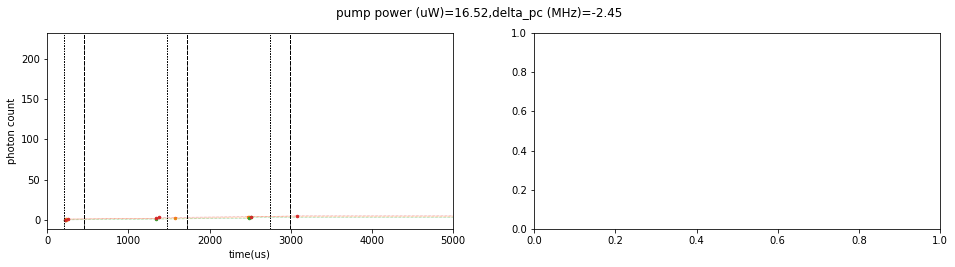

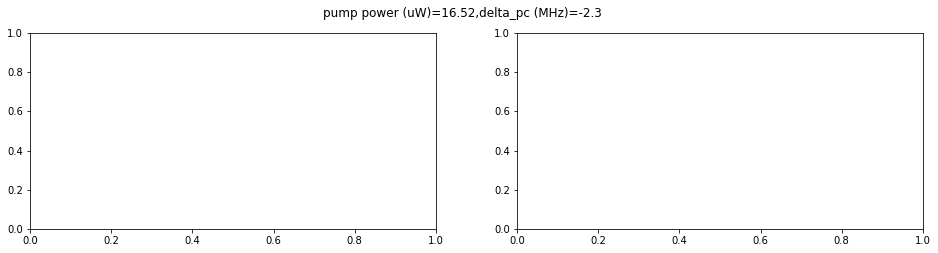

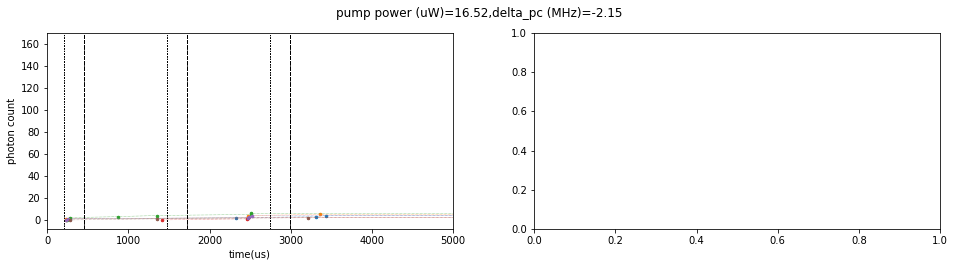

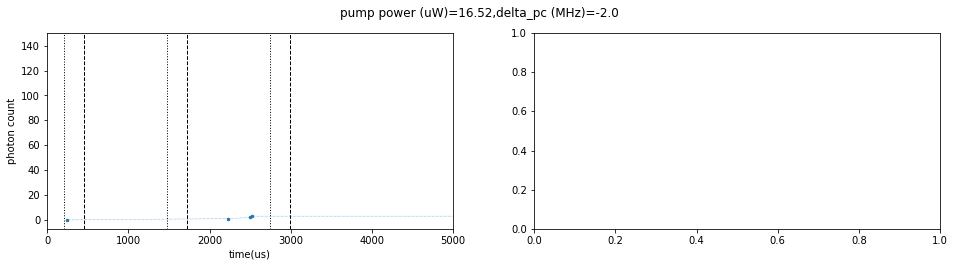

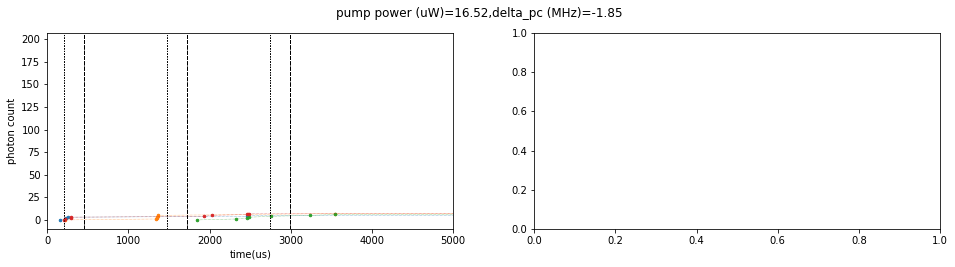

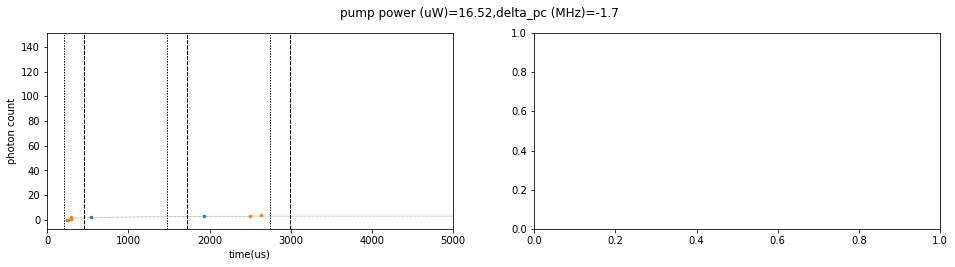

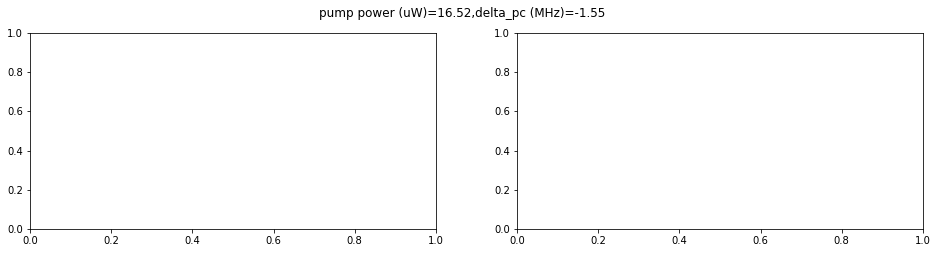

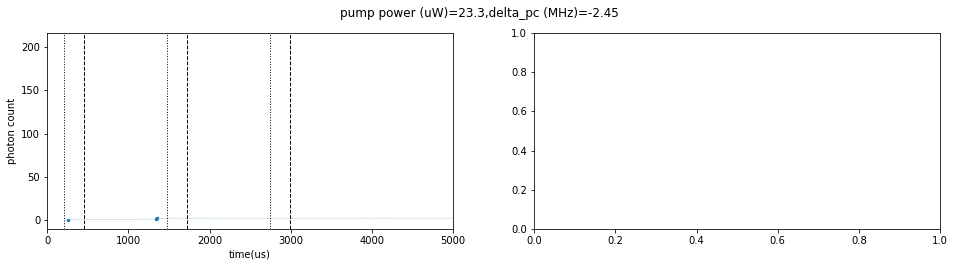

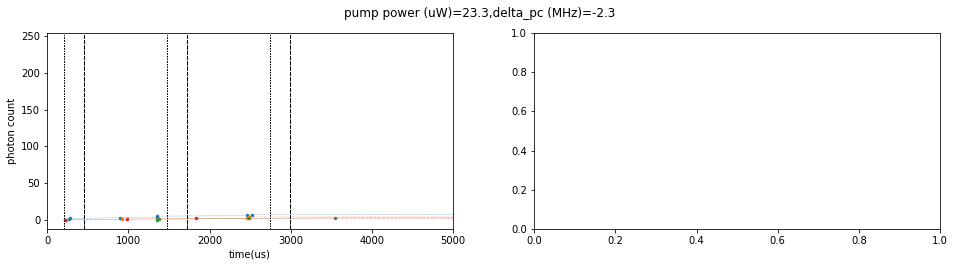

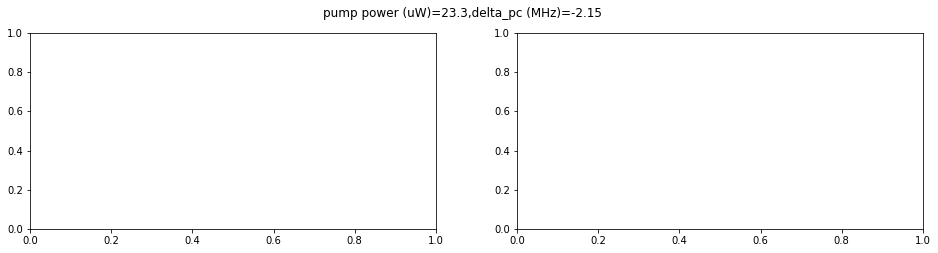

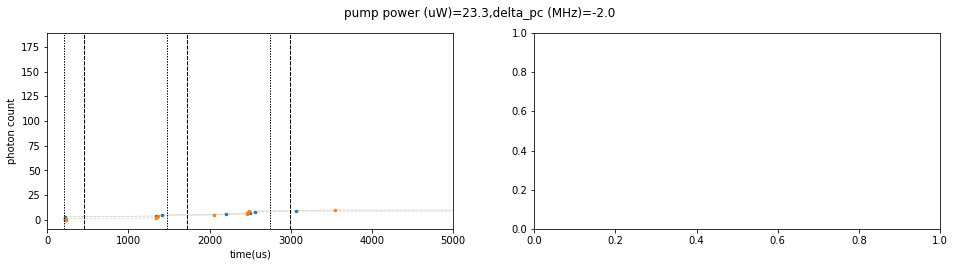

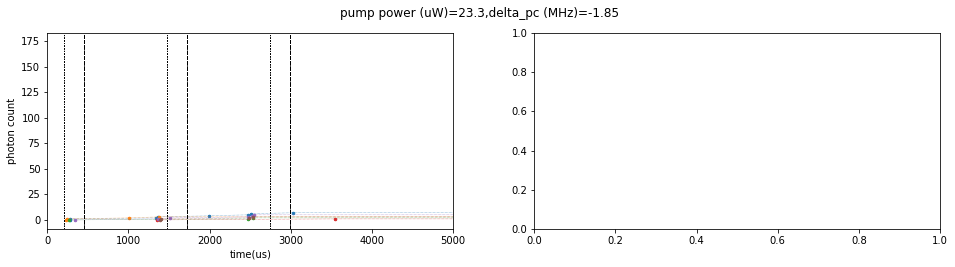

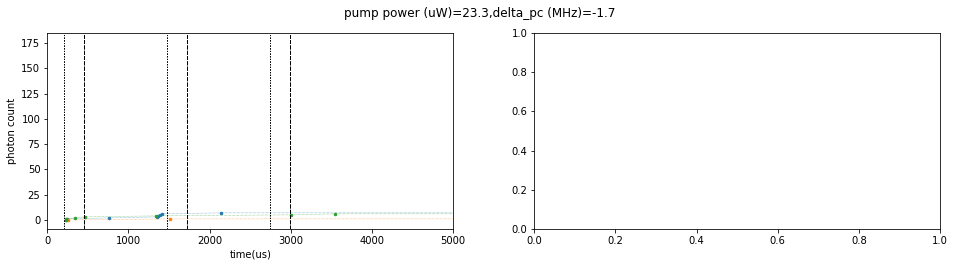

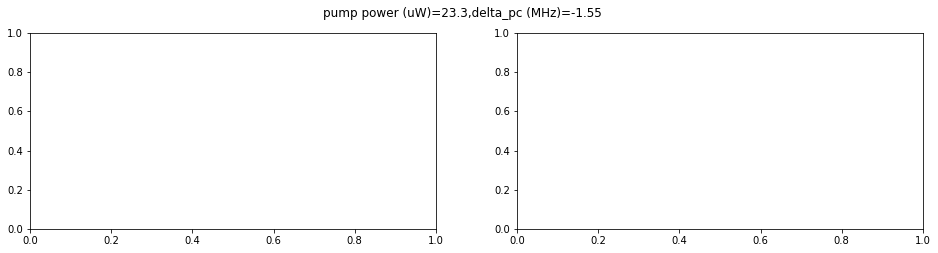

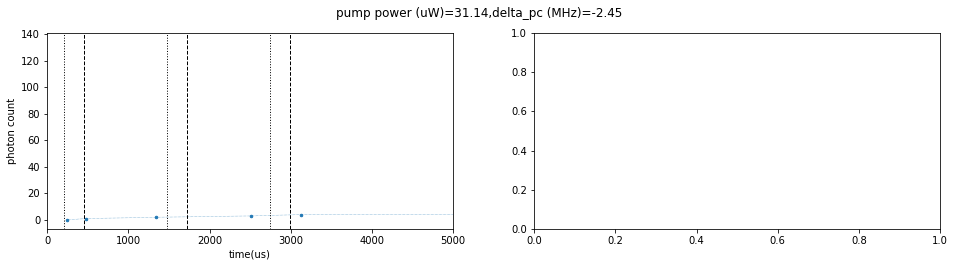

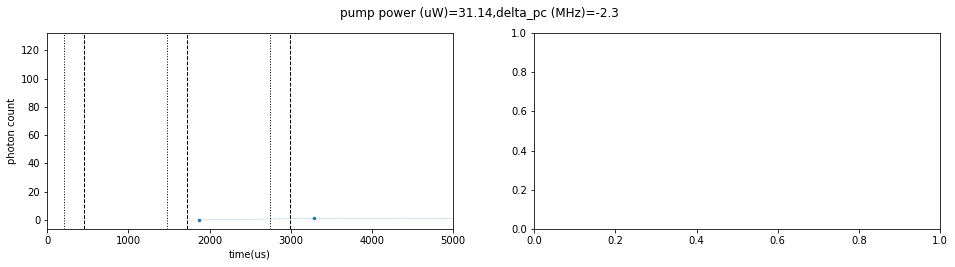

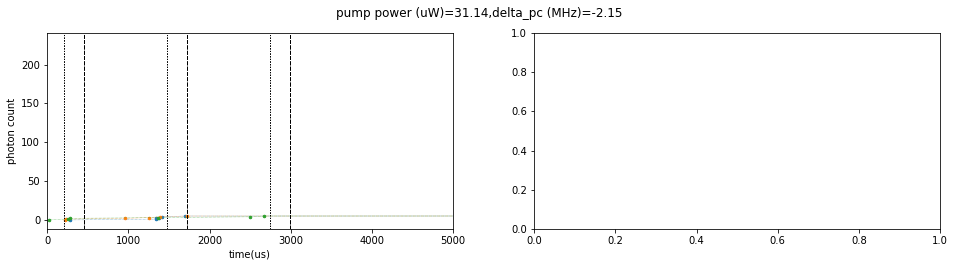

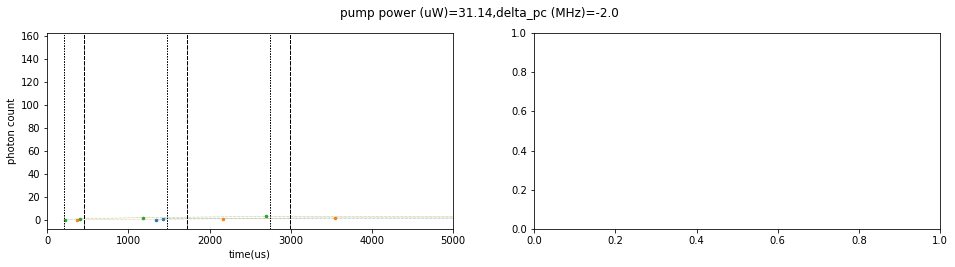

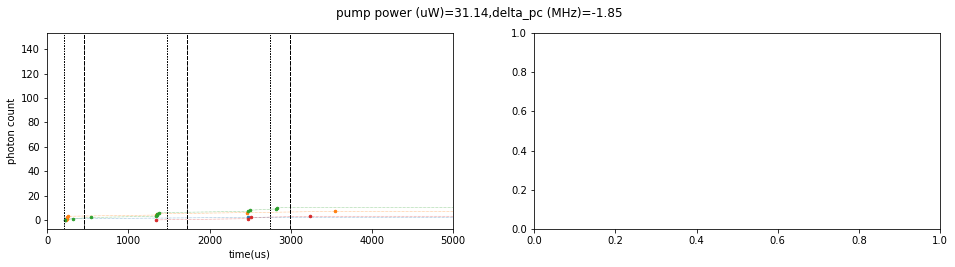

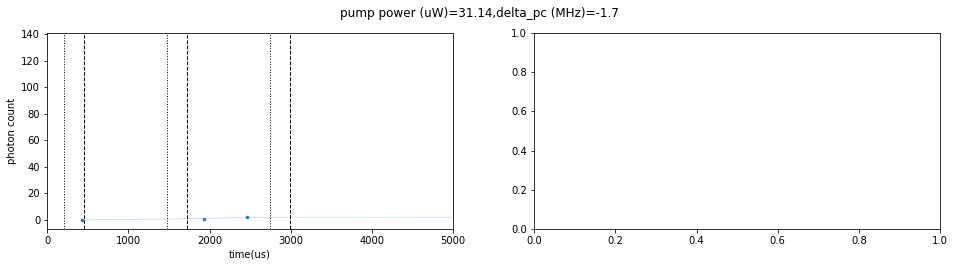

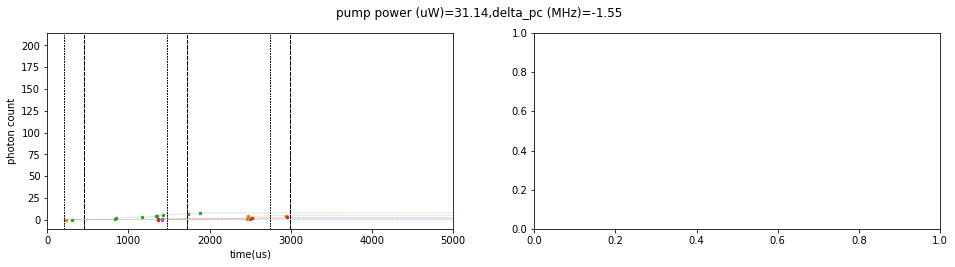

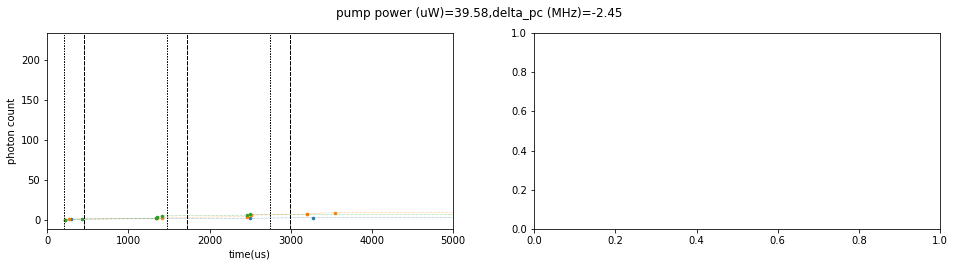

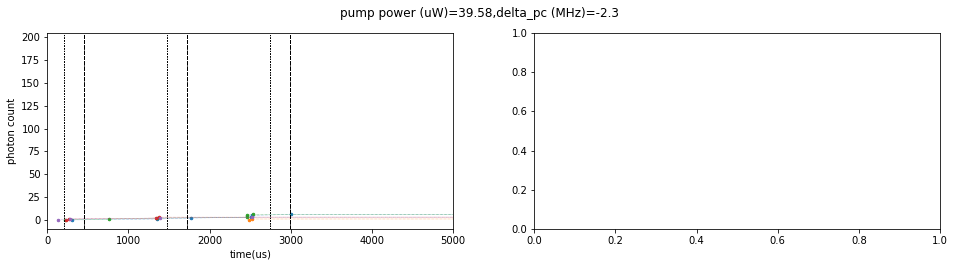

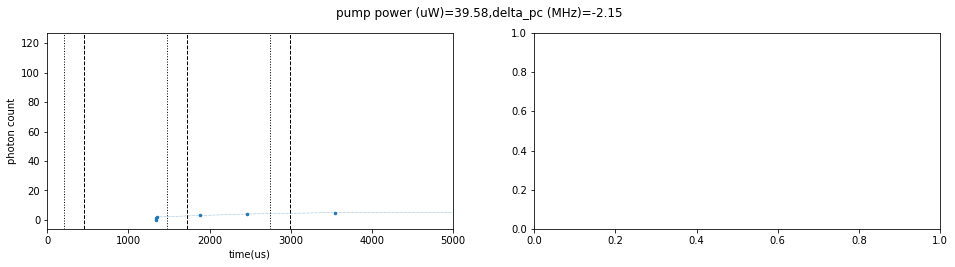

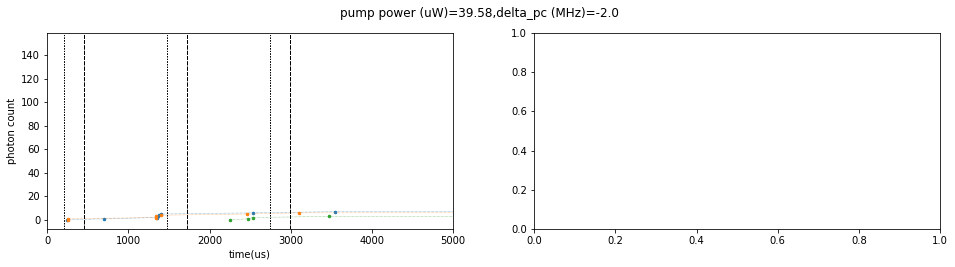

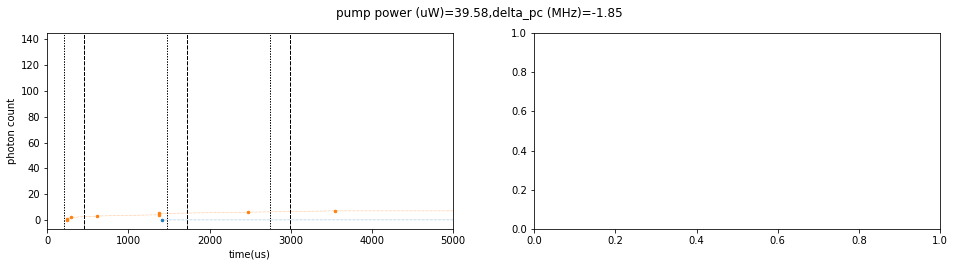

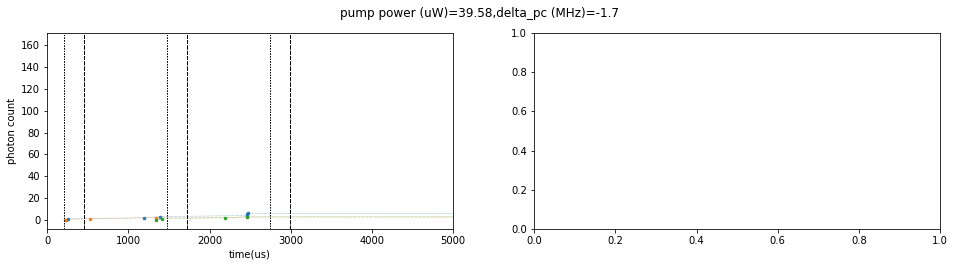

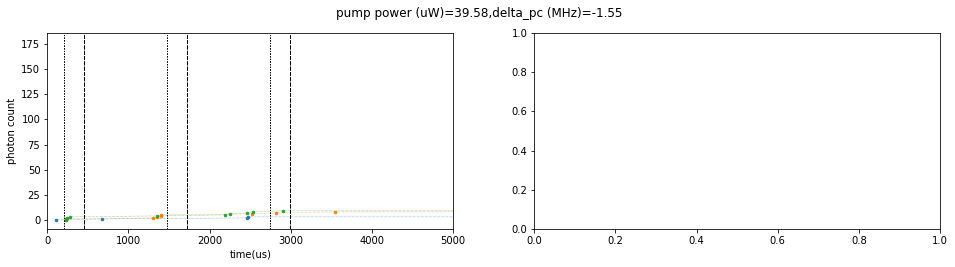

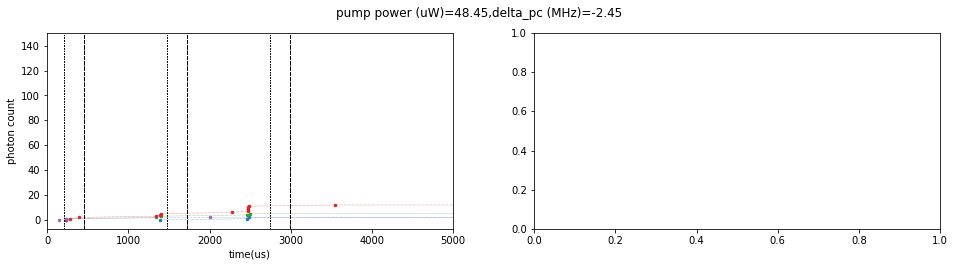

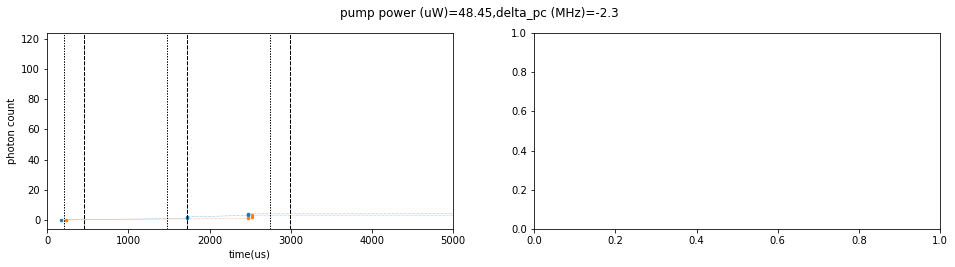

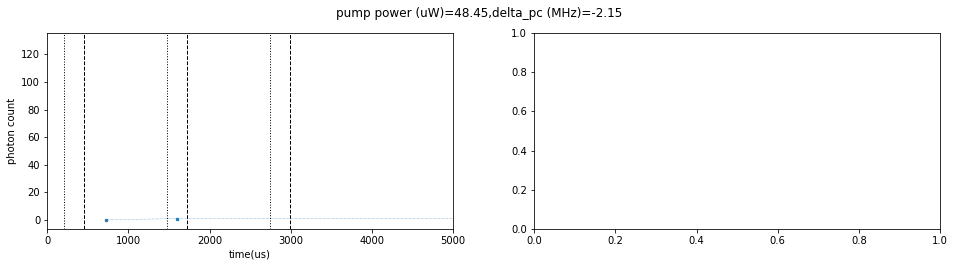

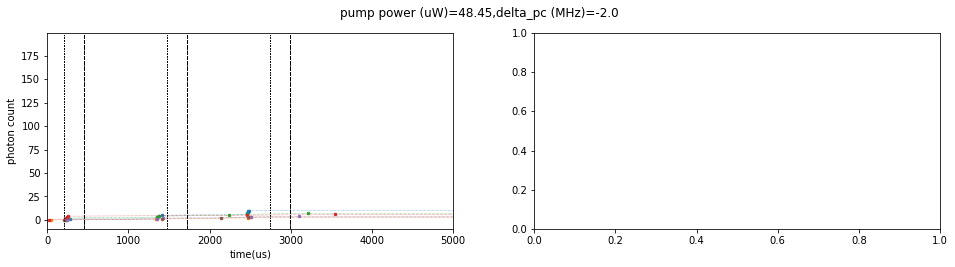

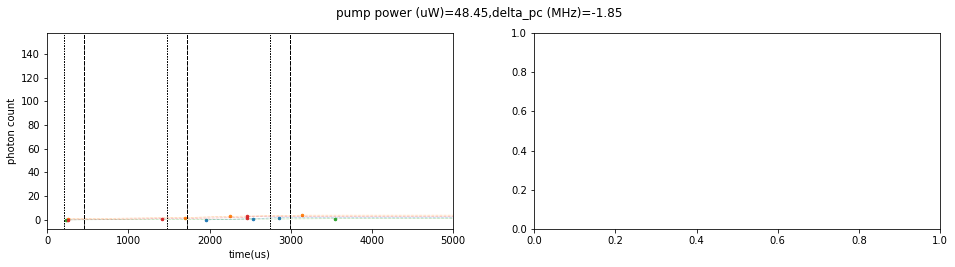

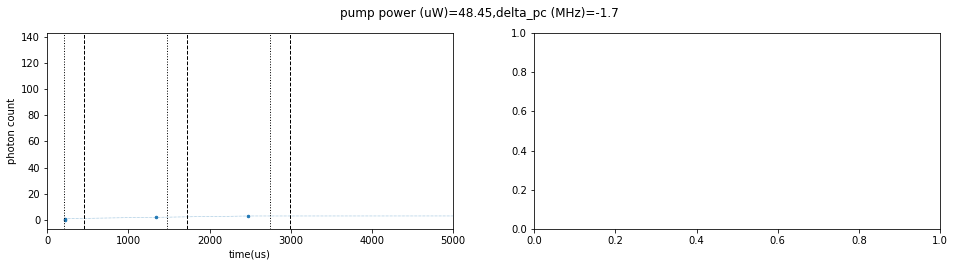

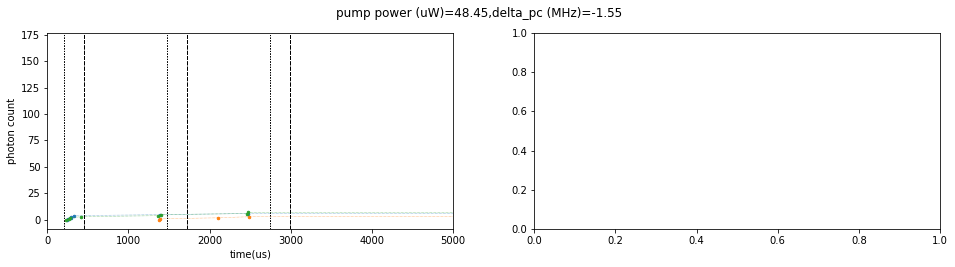

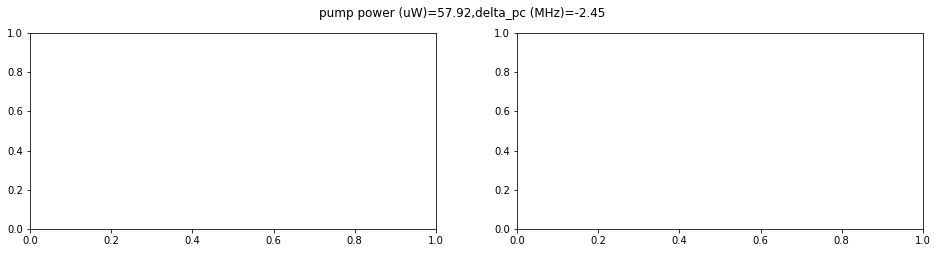

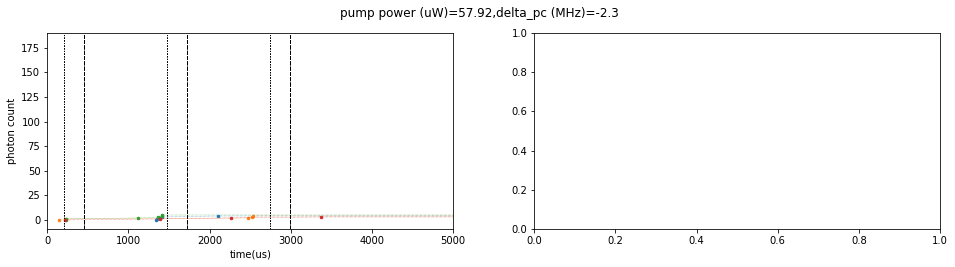

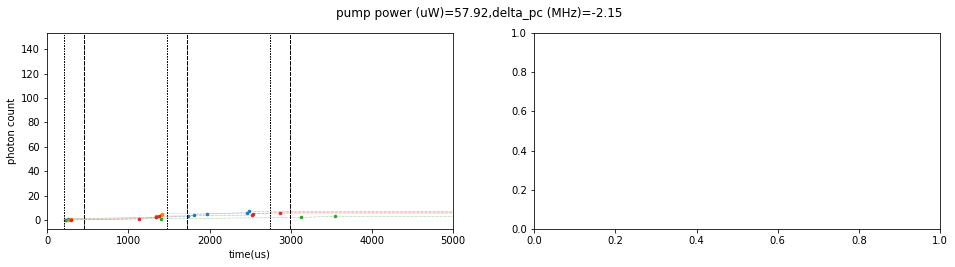

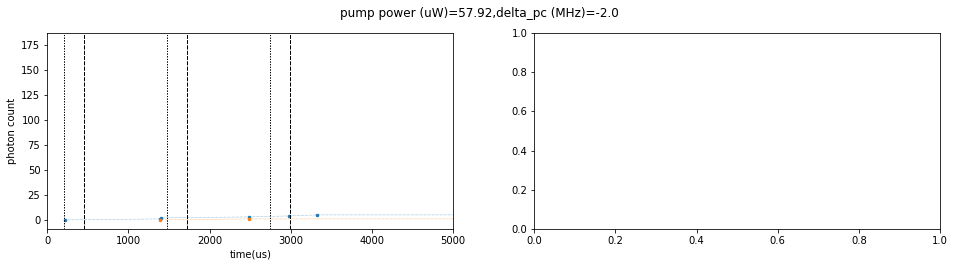

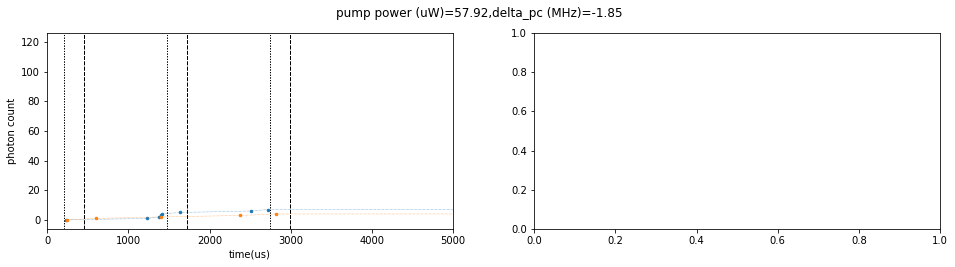

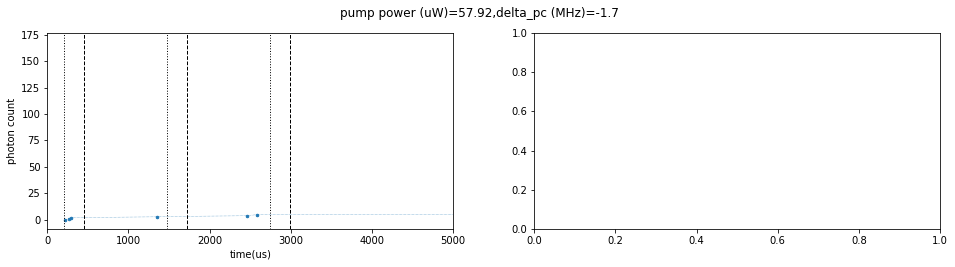

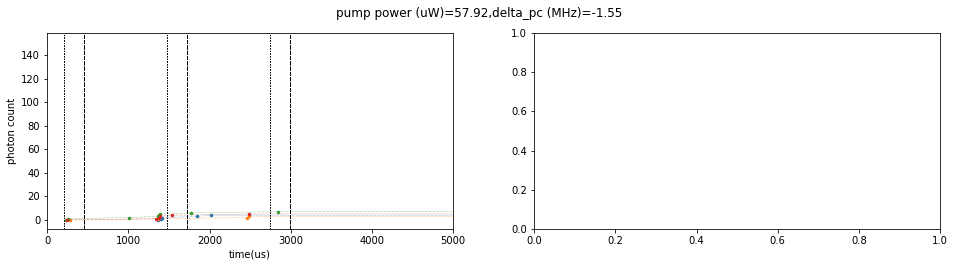

In [ ]:
plot_true = True
# if plot_true:
for x_val_plot in point_list:
#     x_val_plot = 1
    ind_x=np.argmin(np.abs(point_list-x_val_plot))
#     print(point_name_inner, point_list_inner[ind_x])
    outer_ind=ind_x//num_points_inner
    inner_ind=ind_x%num_points_inner
    fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[16,3.6])
    plt.suptitle(f'{point_name_outer}={np.round(point_list_outer[outer_ind],2)},{point_name_inner}={point_list_inner[inner_ind]}')
    plt.sca(axs[0])

    for i in range(num_shots_sliced):
#     for i in np.arange(100,200):
        if mask_xval[ind_x][i] & mask_array_matrix[0][i]:
            plt.plot(PT_cavity_timestamp_array_raw[i],np.arange(len(PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
            plt.xlabel('time(us)')
            plt.ylabel('photon count')
            for cav_frame in range(num_frames_cav_per_twz):
                plt.axvline(t_cav_start[cav_frame],c='k',linestyle=':',linewidth=1)
                plt.axvline(t_cav_end[cav_frame], c='k',linestyle='--',linewidth=1)
                plt.xlim(0,5000)
#                 plt.axvline(t_pre+1*t_probe + 0*t_mol)
#                 plt.axvline(t_pre+2*t_probe + 1*t_mol)
    plt.sca(axs[1])

#     for i in range(num_shots_sliced):
# #     for i in np.arange(100,200):
#         if mask_xval[ind_x][i] & mask_array_matrix[0][i]:
#             plt.plot(silver_PT_cavity_timestamp_array_raw[i],np.arange(len(silver_PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
#             plt.xlabel('time(us)')
#             plt.ylabel('photon count')
#             for cav_frame in range(num_frames_cav_per_twz):
#                 plt.axvline(t_cav_start[cav_frame],c='k',linestyle=':',linewidth=1)
#                 plt.axvline(t_cav_end[cav_frame], c='k',linestyle='--',linewidth=1)


#     plt.xlim([0,700])
#     plt.ylim([0,100])
#     plt.xlim([0,74e3])
    
#     plt.ylim([-20,10000])
#     plt.ylim([-1,3])

#     plt.sca(axs[1])
#     gap_list_all = np.array([])
#     for i in range(num_shots_sliced):
#         if mask_xval[ind_x][i] & mask_full_0[i]:
#             gap_list_all = np.concatenate((gap_list_all, np.diff(PT_cavity_timestamp_array_raw[i])))
                
#     max_gap = max(gap_list_all)
#     hist_edge=np.arange(-0.5,max_gap+10,5)
#     hist_x=(hist_edge[:-1]+hist_edge[1:])/2
#     hist_y = np.histogram(gap_list_all,bins=hist_edge)[0] 
#     plt.bar(hist_x,hist_y,1, edgecolor="r",facecolor='r',alpha=0.6)
#     plt.yscale('log')

#     plt.xlim([t_cav_start[num_frames_cav_per_twz]-20,t_cav_end[2*num_frames_cav_per_twz-1]+10]);
#     plt.ylim([-20,100])

(2300.0, 3000.0)

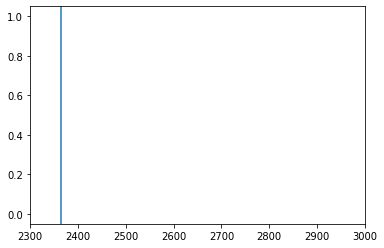

In [ ]:
i=0
plt.plot(PT_cavity_timestamp_array_raw[i],np.arange(len(PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
plt.axvline([2365])
plt.xlim([2300,3000])

## Bin data

In [ ]:
# Bin data

mask_dark=((np.sum(atom_existence_array,axis=2)[:,0]==0) & (np.sum(atom_existence_array,axis=2)[:,1]==0))# & mask_select[:num_shots])

if np.sum(mask_dark)>0:
    dark_count=np.mean(cavity_photoncount_array[mask_dark,1])
    print(dark_count)
    dark_count_rate=dark_count/(N_cycle*t_probe)
else:
    dark_count=0
    
# dark_count=0

# if np.sum(mask_dark)>0:
#     dark_count_2=np.mean(cavity_photoncount_array_2[mask_dark,1])
#     print(dark_count_2)
#     dark_count_rate_2=dark_count_2/(N_cycle*t_probe)
# else:
#     dark_count_2=0
    
num_array=len(twz_num_plot)

x_bin0_array_list=[[]]*num_array
photoncount_bin0_array_list=[[]]*num_array
photoncount_bin0_array_err_list=[[]]*num_array
photoncount_bin0_array_mean_err_list=[[]]*num_array

x_bin1_array_list=[[]]*num_array
photoncount_bin1_array_list=[[]]*num_array
photoncount_bin1_array_err_list=[[]]*num_array
photoncount_bin1_array_mean_err_list=[[]]*num_array

# TO DO: update the binning method to bin on x_val_corrected instead of x_val, actually maybe do both.
for array_ind in range(num_array):
    x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array[mask_array_matrix[array_ind],0])
    
    x_bin0_array_list[array_ind]=x_bin_temp
    photoncount_bin0_array_list[array_ind]=photoncount_bin_temp-dark_count
    photoncount_bin0_array_err_list[array_ind]=photoncount_bin_temp_err
    photoncount_bin0_array_mean_err_list[array_ind]=photoncount_bin_temp_mean_err
    
    x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array[mask_array_matrix[array_ind],1])
    
    x_bin1_array_list[array_ind]=x_bin_temp
    photoncount_bin1_array_list[array_ind]=photoncount_bin_temp-dark_count
    photoncount_bin1_array_err_list[array_ind]=photoncount_bin_temp_err
    photoncount_bin1_array_mean_err_list[array_ind]=photoncount_bin_temp_mean_err

0.09958791208791208


In [ ]:
num_shots_fpga

15391

In [ ]:
# for SPCM1
photoncount_point_array=[]
for point in range(num_points):
    photoncount_point_temp=[]
    for shot in range(num_shots_fpga):
        if mask_array_matrix[0][shot] & mask_xval[point][shot]:
            photoncount_point_temp.append(cavity_photoncount_array[shot])
    photoncount_point_array.append(photoncount_point_temp)
    
photoncount_point_avg_array=np.empty((num_points,num_frames_cav))
photoncount_point_avg_array[:]=np.nan

photoncount_point_err_array=np.empty((num_points,num_frames_cav))
photoncount_point_err_array[:]=np.nan

for point in range(num_points):
    if len(photoncount_point_array[point])>0:
        photoncount_point_avg_array[point,:]=np.nanmean(np.array(photoncount_point_array[point])-dark_count,axis=0)
        photoncount_point_err_array[point,:]=np.nanstd(np.array(photoncount_point_array[point])-dark_count,axis=0)/np.sqrt(len(photoncount_point_array[point]))

In [ ]:
# for SPCM2
# photoncount_point_array_2=[]
# for point in range(num_points):
#     photoncount_point_temp=[]
#     for shot in range(num_shots):
#         if mask_array_matrix[0][shot] & mask_xval[point][shot]:
#             photoncount_point_temp.append(cavity_photoncount_array_2[shot])
#     photoncount_point_array_2.append(photoncount_point_temp)
    
# photoncount_point_avg_array_2=np.empty((num_points,num_frames_cav))
# photoncount_point_avg_array_2[:]=np.nan

# photoncount_point_err_array_2=np.empty((num_points,num_frames_cav))
# photoncount_point_err_array_2[:]=np.nan

# for point in range(num_points):
#     if len(photoncount_point_array_2[point])>0:
#         photoncount_point_avg_array_2[point,:]=np.nanmean(np.array(photoncount_point_array_2[point])-dark_count_2,axis=0)
#         photoncount_point_err_array_2[point,:]=np.nanstd(np.array(photoncount_point_array_2[point])-dark_count_2,axis=0)/np.sqrt(len(photoncount_point_array_2[point]))

In [ ]:
# plt.errorbar(point_list,photoncount_point_avg_array_2[:,1],yerr=photoncount_point_err_array_2[:,1])

In [ ]:
# Bin data



# num_array=len(twz_num_plot)

# x_bin0_array_list_2=[[]]*num_array
# photoncount_bin0_array_list_2=[[]]*num_array
# photoncount_bin0_array_err_list_2=[[]]*num_array
# photoncount_bin0_array_mean_err_list_2=[[]]*num_array

# x_bin1_array_list_2=[[]]*num_array
# photoncount_bin1_array_list_2=[[]]*num_array
# photoncount_bin1_array_err_list_2=[[]]*num_array
# photoncount_bin1_array_mean_err_list_2=[[]]*num_array

# # TO DO: update the binning method to bin on x_val_corrected instead of x_val, actually maybe do both.
# for array_ind in range(num_array):
#     x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array_2[mask_array_matrix[array_ind],0])
    
#     x_bin0_array_list_2[array_ind]=x_bin_temp
#     photoncount_bin0_array_list_2[array_ind]=photoncount_bin_temp-dark_count
#     photoncount_bin0_array_err_list_2[array_ind]=photoncount_bin_temp_err
#     photoncount_bin0_array_mean_err_list_2[array_ind]=photoncount_bin_temp_mean_err
    
#     x_bin_temp,photoncount_bin_temp,photoncount_bin_temp_err,photoncount_bin_temp_mean_err=uniquebin(x_val[mask_array_matrix[array_ind]],cavity_photoncount_array_2[mask_array_matrix[array_ind],1])
    
#     x_bin1_array_list_2[array_ind]=x_bin_temp
#     photoncount_bin1_array_list_2[array_ind]=photoncount_bin_temp-dark_count
#     photoncount_bin1_array_err_list_2[array_ind]=photoncount_bin_temp_err
#     photoncount_bin1_array_mean_err_list_2[array_ind]=photoncount_bin_temp_mean_err

In [ ]:
cavity_photoncount_array_postselected = cavity_photoncount_array[mask_array_matrix[0]]

In [ ]:
cavity_photoncount_array_postselected.shape

(110, 3)

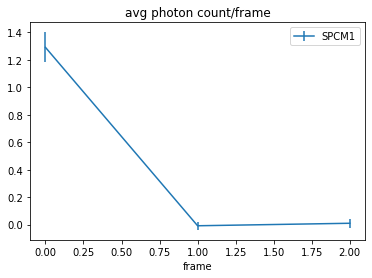

In [ ]:
plt.errorbar(np.arange(num_frames_cav), np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count, axis=0),
             yerr=np.std(cavity_photoncount_array[mask_array_matrix[0]]/np.sqrt(np.sum(mask_array_matrix[0])),axis=0),label='SPCM1')
# plt.errorbar(np.arange(num_frames_cav), np.mean(cavity_photoncount_array_2[mask_array_matrix[0]]-dark_count_2, axis=0),
#              yerr=np.std(cavity_photoncount_array_2[mask_array_matrix[0]]/np.sqrt(np.sum(mask_array_matrix[0])),axis=0),label='SPCM2')
plt.xlabel('frame')
plt.title('avg photon count/frame')
plt.legend()

In [ ]:
low_count=np.mean(np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count,axis=0)[:5])
high_count=np.mean(np.mean(cavity_photoncount_array[mask_array_matrix[0]]-dark_count,axis=0)[-5:])
print(high_count/low_count)

1.0


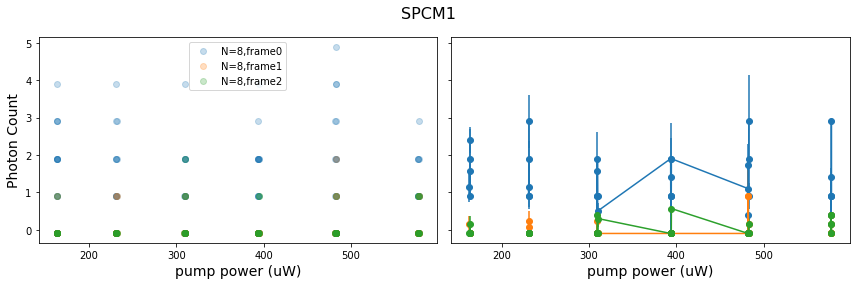

In [ ]:
# show total photon counts
fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[12,4],sharex=True,sharey=True)
plt.suptitle('SPCM1',fontsize=16)
plt.sca(axs[0])

for array_ind in range(num_array):
    for frame in range(num_frames_cav):
        plt.plot(x_val[mask_array_matrix[array_ind]], cavity_photoncount_array[:,frame][mask_array_matrix[array_ind]]-dark_count, 'o', label=f'N={twz_num_plot[array_ind]},frame{frame}',alpha=0.25)

        
plt.xlabel(point_name_outer,fontsize=14)
plt.ylabel('Photon Count',fontsize=14)
plt.legend()

plt.sca(axs[1])
for array_ind in range(num_array):
    for frame in range(num_frames_cav):
        plt.errorbar(point_list, photoncount_point_avg_array[:,frame],yerr=photoncount_point_err_array[:,frame], marker='o')
    
plt.xlabel(point_name_outer,fontsize=14)
    
    
plt.tight_layout()
plt.show()

    


In [ ]:
# # show total photon counts
# fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[12,4],sharex=True,sharey=True)
# plt.suptitle('SPCM2',fontsize=16)
# plt.sca(axs[0])

# for array_ind in range(num_array):
#     for frame in range(num_frames_cav):
#         plt.plot(x_val[mask_array_matrix[array_ind]], cavity_photoncount_array_2[:,frame][mask_array_matrix[array_ind]]-dark_count, 'o', label=f'N={twz_num_plot[array_ind]},frame{frame}',alpha=0.25)

        
# plt.xlabel(point_name_outer,fontsize=14)
# plt.ylabel('Photon Count',fontsize=14)
# plt.legend()

# plt.sca(axs[1])
# for array_ind in range(num_array):
#     for frame in range(num_frames_cav):
#         plt.errorbar(point_list, photoncount_point_avg_array_2[:,frame],yerr=photoncount_point_err_array_2[:,frame], marker='o')
    
# plt.xlabel(point_name_outer,fontsize=14)
    
    
# plt.tight_layout()
# plt.show()

    


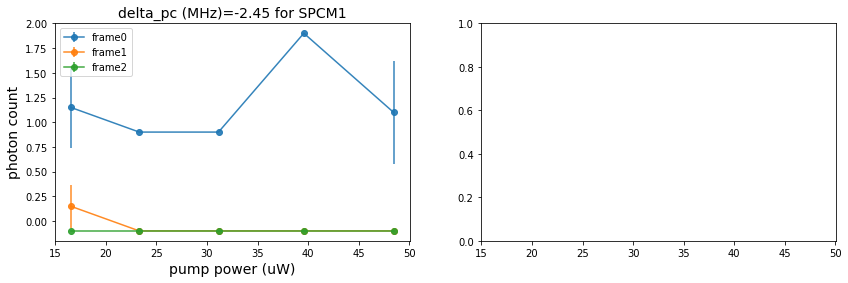

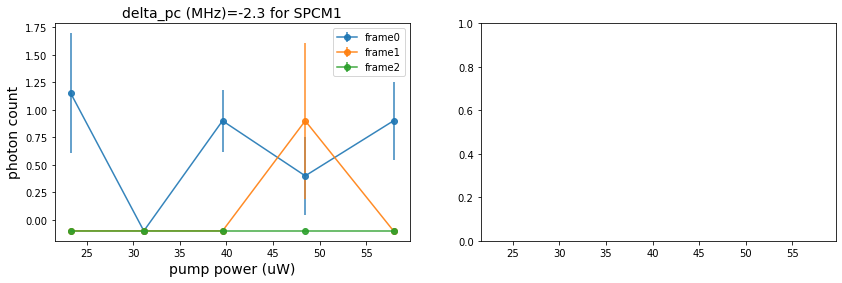

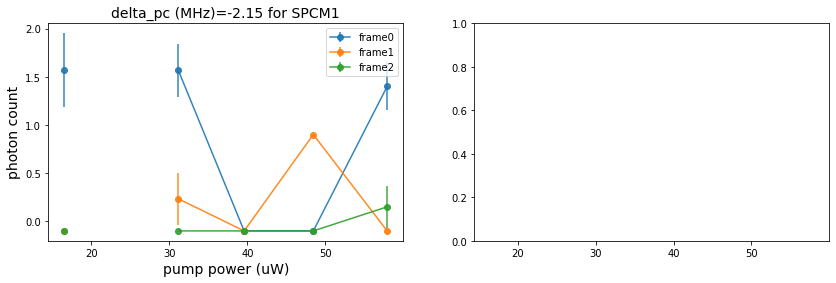

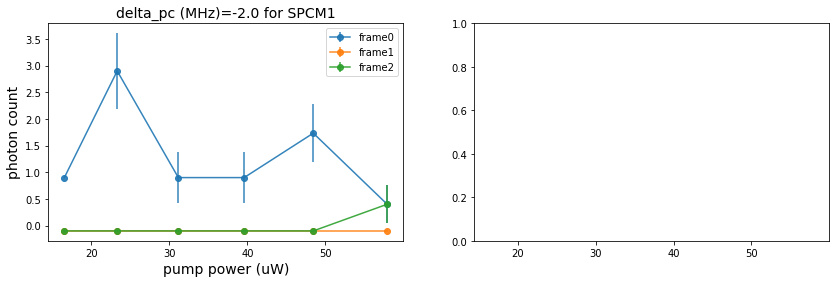

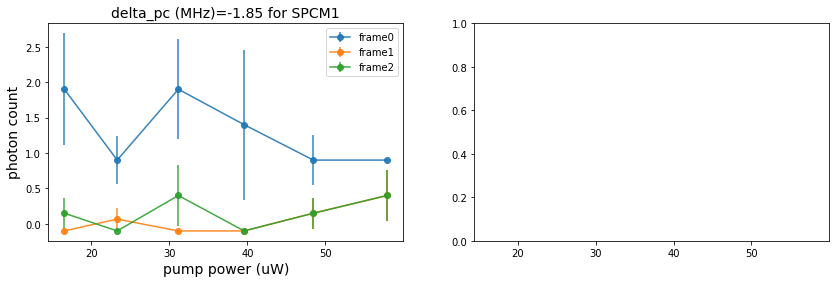

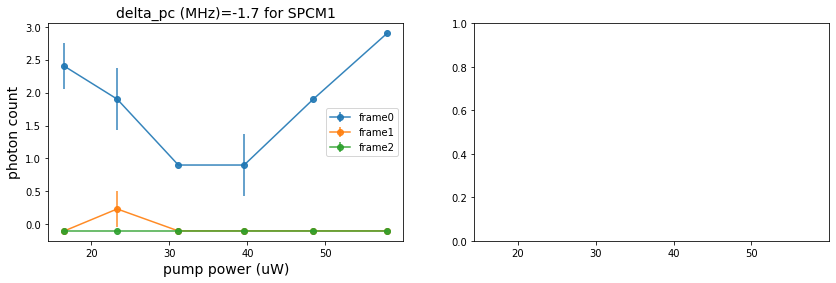

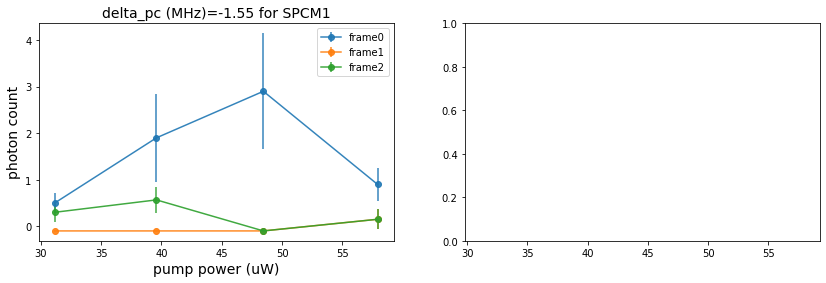

In [ ]:
# show total photon counts
for inner_point_ind in range(num_points_inner):
    fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[14,4],sharex=True,sharey=False)
    plt.sca(axs[0])

    for frame in range(num_frames_cav):
        plt.errorbar(point_list_outer, photoncount_point_avg_array[inner_point_ind::num_points_inner,frame],yerr=photoncount_point_err_array[inner_point_ind::num_points_inner,frame], marker='o', label=f'frame{frame}',alpha=0.9)

   
    plt.title(f'{point_name_inner}={point_list_inner[inner_point_ind]} for SPCM1',fontsize=14)
    plt.ylabel('photon count', fontsize=14)
    plt.xlabel(f'{point_name_outer}',fontsize=14)
    plt.legend()

    plt.sca(axs[1])

#     for frame in range(num_frames_cav):
#         plt.errorbar(point_list_outer, photoncount_point_avg_array_2[inner_point_ind::num_points_inner,frame],yerr=photoncount_point_err_array_2[inner_point_ind::num_points_inner,frame], marker='o', label=f'frame{frame}',alpha=0.9)

#     plt.title(f'{point_name_inner}={point_list_inner[inner_point_ind]} for SPCM2',fontsize=14)
# #     plt.ylabel('photon count', fontsize=14)
#     plt.xlabel(f'{point_name_outer}',fontsize=14)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

    


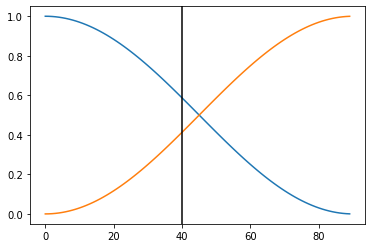

In [ ]:
angle=np.arange(0,90)
plt.plot(angle, (np.cos(2*np.pi/180*angle)+1)/2)
plt.plot(angle, 1-(np.cos(2*np.pi/180*angle)+1)/2)
plt.axvline(40, c='k')

In [ ]:
angle = 40
print((np.cos(2*np.pi/180*angle)+1)/2/(1-(np.cos(2*np.pi/180*angle)+1)/2))

1.4202766254612067


In [ ]:
# photoncount_point_avg_array[0][0]/(photoncount_point_avg_array_2[0][0]*110/90)

In [ ]:
print(f'first frame counts = {np.mean(cavity_photoncount_array[:,0])}')
print(f'second frame counts = {np.mean(cavity_photoncount_array[:,1])}')

first frame counts = 1.9692677538821388
second frame counts = 0.12494314859333376


In [ ]:
# print(photoncount_bin_array_list[0])
# print(photoncount_bin_array_mean_err_list[0])

In [ ]:
# # show total photon counts per atom

# fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[12,4],sharex=True,sharey=True)
# plt.sca(axs[0])

# for array_ind in range(num_array):
#     plt.plot(x_val[mask_array_matrix[array_ind]], (cavity_photoncount_array[:,0][mask_array_matrix[array_ind]]-dark_count)/twz_num_plot[array_ind], 'o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.5)
# plt.xlabel(point_name_inner,fontsize=14)
# plt.ylabel('Photon Count per atom',fontsize=14)
# plt.legend()

# plt.sca(axs[1])
# for array_ind in range(num_array):
#     plt.errorbar(x_bin_array_list[array_ind], photoncount_bin_array_list[array_ind]/twz_num_plot[array_ind],yerr=photoncount_bin_array_mean_err_list[array_ind]/twz_num_plot[array_ind], marker='o', label=f'All atoms',alpha=0.9)
# plt.xlabel(point_name_inner,fontsize=14)
    
    
# plt.tight_layout()
# plt.show()

In [ ]:

# plt.plot(np.arange(cavity_photoncount_array.shape[0])[mask_array_matrix[1] & mask_xval[8]],cavity_photoncount_array[:,0][mask_array_matrix[1] & mask_xval[8]])

## Averaged Time traces

In [ ]:
PT_cavity_timestamp_array_new = []

for shot_num in range(num_shots_sliced):
    PT_cavity_timestamp_array_cycles = []
    for i in range(N_cycle):
        timestamp_list = []
        for j in range(len(PT_cavity_timestamp_array_raw[shot_num])):   
            if t_pre + t_cycle*i < PT_cavity_timestamp_array_raw[shot_num][j] <= t_pre +t_cycle*i + t_probe:
                timestamp_list.append(PT_cavity_timestamp_array_raw[shot_num][j])
        PT_cavity_timestamp_array_cycles.append(timestamp_list)
    PT_cavity_timestamp_array_cycles = np.array(PT_cavity_timestamp_array_cycles)
    PT_cavity_timestamp_array_new.append(PT_cavity_timestamp_array_cycles)
# PT_cavity_timestamp_array_new = np.array(PT_cavity_timestamp_array_new)


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# bin the photon counts
bin_size = filter_time #us
num_bins = int(t_probe/bin_size)
photon_number_binned = np.empty((num_shots_sliced, N_cycle, num_bins))
photon_number_binned[:] = np.NaN

for shot_num in range(num_shots_sliced):
    if mask_good_data[shot_num]:
        for i in range(N_cycle):      
            for bin_num in range(num_bins):
                count = 0
                for j in range(len(PT_cavity_timestamp_array_new[shot_num][i])):
                    if t_pre + t_cycle*i + bin_size*bin_num <= PT_cavity_timestamp_array_new[shot_num][i][j] < t_pre + t_cycle*i + bin_size*(bin_num+1):
                        count += 1
                photon_number_binned[shot_num][i][bin_num] = count

In [ ]:
photon_rate_timebin=np.zeros([len(twz_num_plot),num_points,num_bins])
photon_rate_timebin_err=np.zeros([len(twz_num_plot),num_points,num_bins])
for array_index,twz_num in enumerate(twz_num_plot):
    for point in range(num_points):
        for i in range(num_bins):
            photon_number_list_temp=photon_number_binned[mask_array_matrix[array_index]&mask_xval[point]][:,:,i].flatten()
            photon_rate_timebin[array_index,point,i]=np.mean(photon_number_list_temp)/bin_size
            photon_rate_timebin_err[array_index,point,i]=np.std(photon_number_list_temp)/bin_size/np.sqrt(len(photon_number_list_temp))

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
photon_rate_timebin_frame0=np.zeros([len(twz_num_plot),num_points,num_bins])
photon_rate_timebin_err_frame0=np.zeros([len(twz_num_plot),num_points,num_bins])
for array_index,twz_num in enumerate(twz_num_plot):
    for point in range(num_points):
        for i in range(num_bins):
            photon_number_list_temp=photon_number_binned[mask_array_matrix[array_index]&mask_xval[point]][:,0,i].flatten()
            photon_rate_timebin_frame0[array_index,point,i]=np.nanmean(photon_number_list_temp)/bin_size
            photon_rate_timebin_err_frame0[array_index,point,i]=np.nanstd(photon_number_list_temp)/bin_size/np.sqrt(len(photon_number_list_temp))
            
            
photon_rate_timebin_frame1=np.zeros([len(twz_num_plot),num_points,num_bins])
photon_rate_timebin_err_frame1=np.zeros([len(twz_num_plot),num_points,num_bins])
for array_index,twz_num in enumerate(twz_num_plot):
    for point in range(num_points):
        for i in range(num_bins):
            photon_number_list_temp=photon_number_binned[mask_array_matrix[array_index]&mask_xval[point]][:,1,i].flatten()
            photon_rate_timebin_frame1[array_index,point,i]=np.nanmean(photon_number_list_temp)/bin_size
            photon_rate_timebin_err_frame1[array_index,point,i]=np.nanstd(photon_number_list_temp)/bin_size/np.sqrt(len(photon_number_list_temp))
            
if num_frames_cav==3:            
    photon_rate_timebin_frame2=np.zeros([len(twz_num_plot),num_points,num_bins])
    photon_rate_timebin_err_frame2=np.zeros([len(twz_num_plot),num_points,num_bins])
    for array_index,twz_num in enumerate(twz_num_plot):
        for point in range(num_points):
            for i in range(num_bins):
                photon_number_list_temp=photon_number_binned[mask_array_matrix[array_index]&mask_xval[point]][:,2,i].flatten()
                photon_rate_timebin_frame2[array_index,point,i]=np.nanmean(photon_number_list_temp)/bin_size
                photon_rate_timebin_err_frame2[array_index,point,i]=np.nanstd(photon_number_list_temp)/bin_size/np.sqrt(len(photon_number_list_temp))

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


<ErrorbarContainer object of 3 artists>

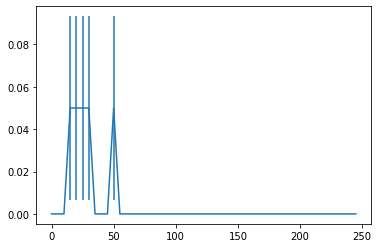

In [ ]:
plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin_frame0[0,0,:],yerr=photon_rate_timebin_err_frame0[0,0,:], label=f'{point_name_inner} = {point_list[point]}')
# plt.errorbar()

In [ ]:
photon_rate_timebin_frame0[0,0,:2]

array([0., 0.])

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python

Text(0, 0.5, 'Photon count rate [$us^{-1}$]')

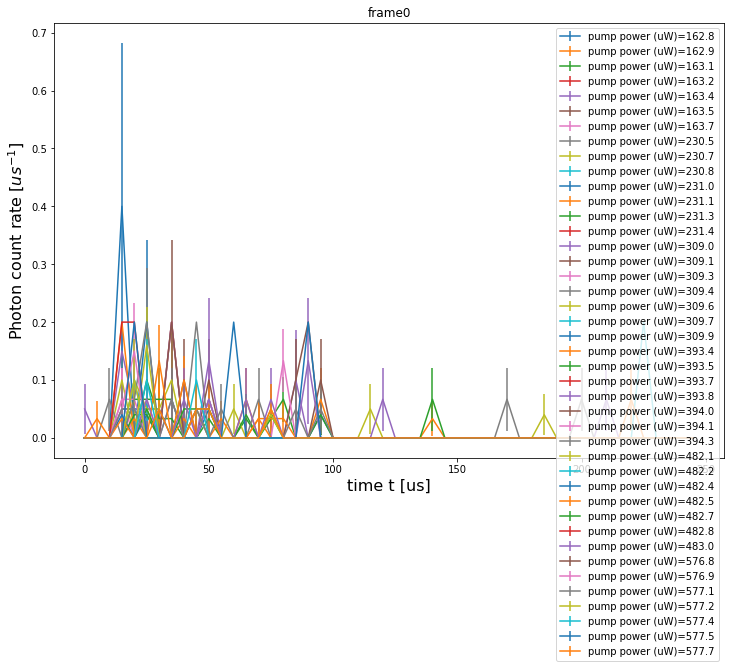

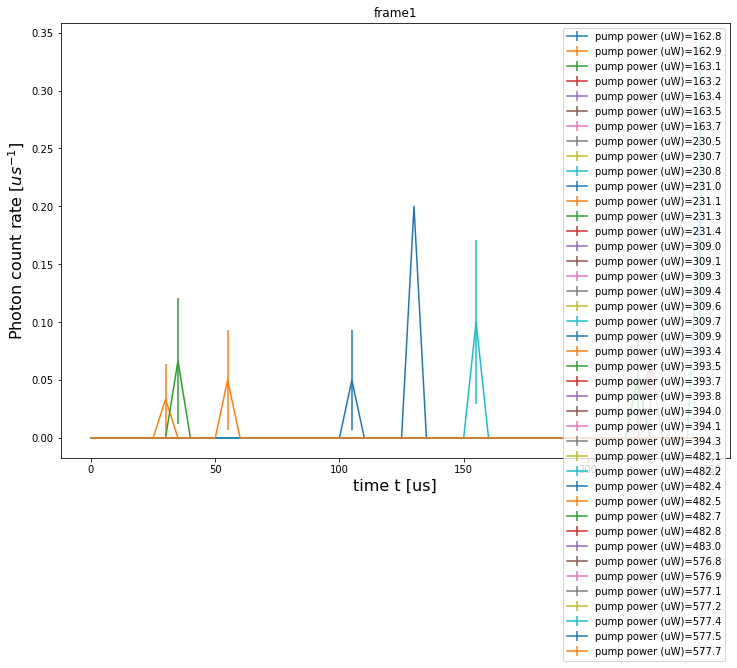

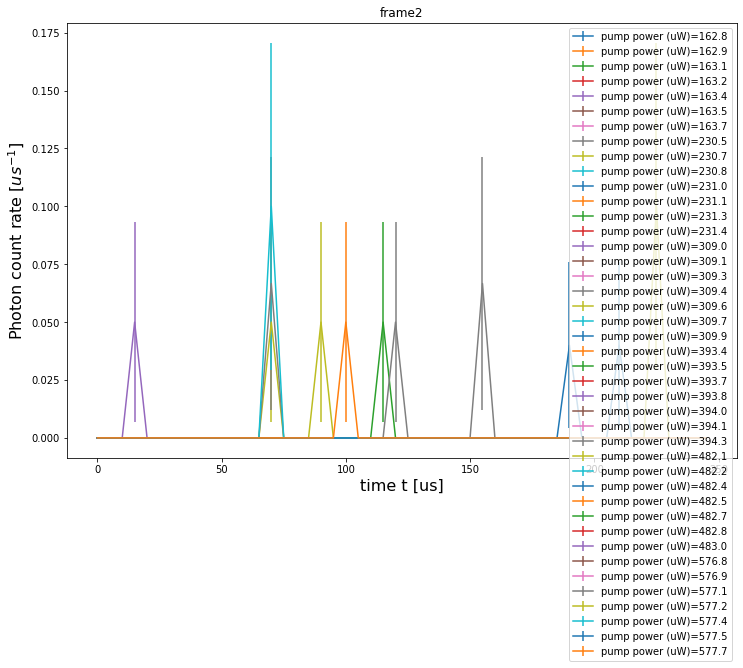

In [ ]:
k=0 # twz num

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[12,8])

for i in range(len(point_list)):
    plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin_frame0[k,i],yerr=photon_rate_timebin_err_frame0[k,i],label=f'{point_name_outer}={round(point_list[i],1)}')
    
plt.legend()
plt.title('frame0')
# plt.xlim([-50,1100])

plt.xlabel('time t [us]',fontsize=16)
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[12,8])

for i in range(len(point_list)):
    plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin_frame1[k,i],yerr=photon_rate_timebin_err_frame1[k,i],label=f'{point_name_outer}={round(point_list[i],1)}')
    
plt.legend()
plt.title('frame1')
# plt.xlim([-50,1100])

plt.xlabel('time t [us]',fontsize=16)
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[12,8])

for i in range(len(point_list)):
    plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin_frame2[k,i],yerr=photon_rate_timebin_err_frame2[k,i],label=f'{point_name_outer}={round(point_list[i],1)}')
    
plt.legend()
plt.title('frame2')
# plt.xlim([-50,1100])

plt.xlabel('time t [us]',fontsize=16)
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)

In [ ]:
print(photon_rate_timebin[0][0][0])
print(photon_rate_timebin_err[0][0][0])

0.0
0.0


In [ ]:
# plt.errorbar(point_list_inner, photon_rate_timebin[0][:,0], yerr=photon_rate_timebin_err[0][:,0]) # first bin photon count rate
# plt.xlabel(point_name_inner)
# plt.ylabel('initial photon count rate (MHz)')

In [ ]:
# plot the maximum average count rate
photon_rate_timebin_frame0_max=np.zeros(num_points)
photon_rate_timebin_frame0_max[:]=np.nan
photon_rate_timebin_frame0_max_err=np.zeros(num_points)
photon_rate_timebin_frame0_max_err[:]=np.nan

for point in range(num_points):
    argmax = np.argmax(photon_rate_timebin_frame0[0,point])
    photon_rate_timebin_frame0_max[point]=photon_rate_timebin_frame0[0][point][argmax]
    photon_rate_timebin_frame0_max_err[point]=photon_rate_timebin_err_frame0[0][point][argmax]
print(photon_rate_timebin_frame0_max)

photon_rate_timebin_frame1_max=np.zeros(num_points)
photon_rate_timebin_frame1_max[:]=np.nan
photon_rate_timebin_frame1_max_err=np.zeros(num_points)
photon_rate_timebin_frame1_max_err[:]=np.nan


for point in range(num_points):
    argmax = np.argmax(photon_rate_timebin_frame1[0,point])
    photon_rate_timebin_frame1_max[point]=photon_rate_timebin_frame1[0][point][argmax]
    photon_rate_timebin_frame1_max_err[point]=photon_rate_timebin_err_frame1[0][point][argmax]

photon_rate_timebin_frame2_max=np.zeros(num_points)
photon_rate_timebin_frame2_max[:]=np.nan
photon_rate_timebin_frame2_max_err=np.zeros(num_points)
photon_rate_timebin_frame2_max_err[:]=np.nan


for point in range(num_points):
    argmax = np.argmax(photon_rate_timebin_frame2[0,point])
    photon_rate_timebin_frame2_max[point]=photon_rate_timebin_frame2[0][point][argmax]
    photon_rate_timebin_frame2_max_err[point]=photon_rate_timebin_err_frame2[0][point][argmax]
    


[0.05              nan 0.1        0.2        0.15       0.2
        nan 0.2        0.1               nan 0.4        0.03333333
 0.06666667        nan 0.2        0.         0.13333333 0.06666667
 0.1        0.2        0.04       0.2        0.04       0.
 0.13333333 0.2        0.06666667 0.2        0.16       0.1
 0.         0.13333333 0.05       0.2        0.13333333        nan
 0.15       0.05       0.1        0.1        0.2        0.05      ]


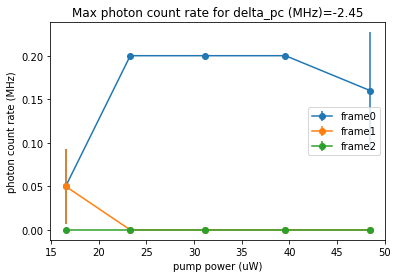

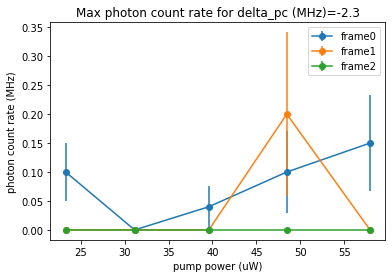

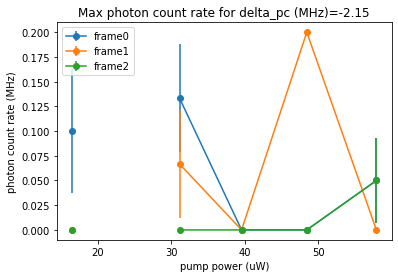

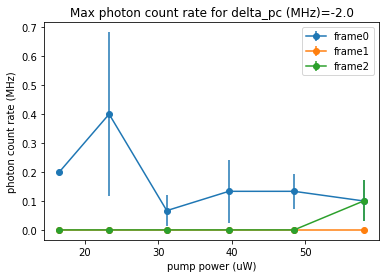

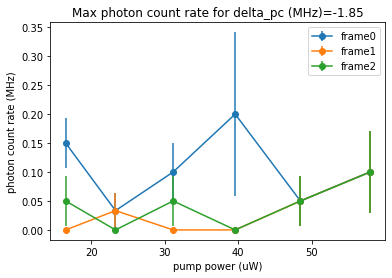

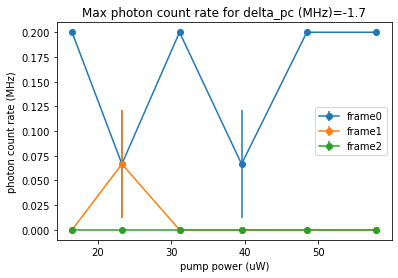

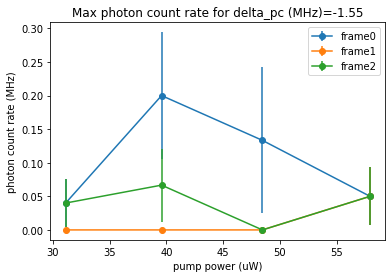

<Figure size 432x288 with 0 Axes>

In [ ]:
for inner_point_ind in range(num_points_inner):
    plt.errorbar(point_list_outer, photon_rate_timebin_frame0_max[inner_point_ind::num_points_inner], yerr=photon_rate_timebin_frame0_max_err[inner_point_ind::num_points_inner], label='frame0',marker='o')
    plt.errorbar(point_list_outer, photon_rate_timebin_frame1_max[inner_point_ind::num_points_inner], yerr=photon_rate_timebin_frame1_max_err[inner_point_ind::num_points_inner], label='frame1',marker='o')
    plt.errorbar(point_list_outer, photon_rate_timebin_frame2_max[inner_point_ind::num_points_inner], yerr=photon_rate_timebin_frame2_max_err[inner_point_ind::num_points_inner], label='frame2',marker='o')
    
    plt.legend()
    plt.xlabel(point_name_outer)
    plt.ylabel('photon count rate (MHz)')
    plt.title(f'Max photon count rate for {point_name_inner}={point_list_inner[inner_point_ind]}')
    plt.figure()

In [ ]:
mask_valid_data.shape

(15391,)

ValueError: x and y must be the same size

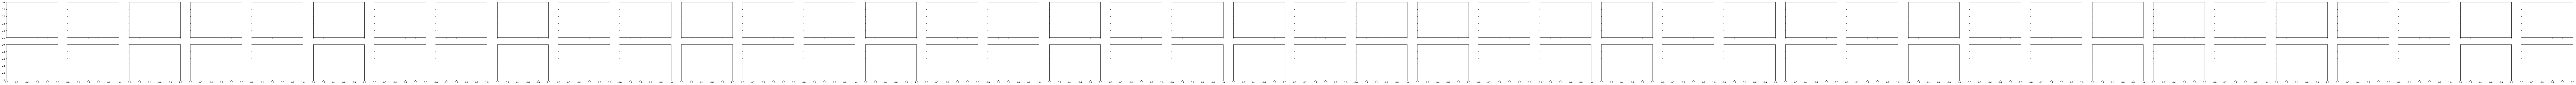

In [ ]:
num_bins_avg = 4

amp_frame_array_point_init_avg = np.empty((num_points, num_masked_loop_max, num_frames_cav))
amp_frame_array_point_init_avg[:] = np.nan

for ind_x in range(num_points):
    amp_frame_array_point_init_avg[ind_x][0:num_masked_loop_list[ind_x]] = np.nanmean(amp_frame_array_point[ind_x][:,:,:num_bins_avg],axis=-1)
    
# frame0
fig,axs=plt.subplots(ncols=num_points,nrows=2,figsize=(5*num_points,6.5),sharey=True,sharex=True)
for point in range(num_points):
    plt.sca(axs[0,point])

    inner_idx = point%num_points_inner
    outer_idx = point//num_points_inner
    mask_temp = mask_xval[point] & mask_array_matrix[0]
    temp=[]
    for shot in range(num_shots_sliced):
        if mask_temp[shot]==True:
            temp.append(shot)
    for good_shot in range(len(temp)):
        if np.sum(amp_frame_array[temp[good_shot]])==0 or (np.mean(amp_frame_array[temp[good_shot]][0])<20):
            mask_temp[temp[good_shot]]=False
    plt.scatter(amp_frame_array_point_avg[point,:num_masked_loop_list[point],0]**2,\
                np.mean(photon_number_binned[mask_temp,0,:],axis=1)/filter_time,marker='.',\
                color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
    # plt.legend()
    plt.xlabel('het_amp^2')
    # plt.xlim(0,2500)
    plt.ylim(-0.5,1)
    plt.ylabel('SPCM count rate (MHz)')
# plt.xlim(0,1500/71*25)
# plt.ylim(0,500/71*25)
    plt.title("frame0 full 200us")
# plt.legend(loc=(1,0))
# plt.show()

for point in range(num_points):
    plt.sca(axs[1,point])
    inner_idx = point%num_points_inner
    outer_idx = point//num_points_inner
    mask_temp = mask_xval[point] & mask_array_matrix[0]
    temp=[]
    for shot in range(num_shots_sliced):
        if mask_temp[shot]==True:
            temp.append(shot)
    for good_shot in range(len(temp)):
        if np.sum(amp_frame_array[temp[good_shot]])==0 or (np.mean(amp_frame_array[temp[good_shot]][0])<20):
            mask_temp[temp[good_shot]]=False
    plt.scatter(amp_frame_array_point_init_avg[point,:num_masked_loop_list[point],0]**2,\
                np.mean(photon_number_binned[mask_temp,0,:num_bins_avg],axis=1)/(filter_time),marker='.',\
                color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
    plt.xlabel('het_amp^2')
    # plt.xlim(0,2500)
    # plt.ylim(0,10)
    plt.ylabel('SPCM count rate (MHz)')
    # plt.xlim(0,1500/71*25)
    # plt.ylim(0,500/71*25)
    plt.title(f'frame0 initial {filter_time*num_bins_avg}us')



In [ ]:
# frame1

fig,axs=plt.subplots(ncols=num_points,nrows=2,figsize=(5*num_points,6.5),sharey=True,sharex=True)
for point in range(num_points):
    plt.sca(axs[0,point])

    inner_idx = point%num_points_inner
    outer_idx = point//num_points_inner
    mask_temp = mask_xval[point] & mask_array_matrix[0]
    temp=[]
    for shot in range(num_shots_sliced):
        if mask_temp[shot]==True:
            temp.append(shot)
    for good_shot in range(len(temp)):
        if np.sum(amp_frame_array[temp[good_shot]])==0 or (np.mean(amp_frame_array[temp[good_shot]][0])<20):
            mask_temp[temp[good_shot]]=False
    plt.scatter(amp_frame_array_point_avg[point,:num_masked_loop_list[point],1]**2,\
                np.mean(photon_number_binned[mask_temp,1,:],axis=1)/filter_time,marker='.',\
                color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
    # plt.legend()
    plt.xlabel('het_amp^2')
    # plt.xlim(0,2500)
    plt.ylim(-0.5,1)
    plt.ylabel('SPCM count rate (MHz)')
# plt.xlim(0,1500/71*25)
# plt.ylim(0,500/71*25)
    plt.title("frame1 full 200us")
# plt.legend(loc=(1,0))
# plt.show()

for point in range(num_points):
    plt.sca(axs[1,point])
    inner_idx = point%num_points_inner
    outer_idx = point//num_points_inner
    mask_temp = mask_xval[point] & mask_array_matrix[0]
    temp=[]
    for shot in range(num_shots_sliced):
        if mask_temp[shot]==True:
            temp.append(shot)
    for good_shot in range(len(temp)):
        if np.sum(amp_frame_array[temp[good_shot]])==0 or (np.mean(amp_frame_array[temp[good_shot]][0])<20):
            mask_temp[temp[good_shot]]=False
    plt.scatter(amp_frame_array_point_init_avg[point,:num_masked_loop_list[point],1]**2,\
                np.mean(photon_number_binned[mask_temp,1,:num_bins_avg],axis=1)/(filter_time),marker='.',\
                color=np.array([(1-ii/num_masked_loop_list[point],0,ii/num_masked_loop_list[point]) for ii in range(num_masked_loop_list[point])]))
    
    plt.xlabel('het_amp^2')
    # plt.xlim(0,2500)
    # plt.ylim(0,10)
    plt.ylabel('SPCM count rate (MHz)')
    # plt.xlim(0,1500/71*25)
    # plt.ylim(0,500/71*25)
    plt.title(f'frame1 initial {filter_time*num_bins_avg}us')



### Fit Lorentzian with initial scattering rate

In [ ]:
# def lorentzian(x,x0,gamma,A):
#     return A*gamma**2/((x-x0)**2+gamma**2)

# detuning = point_list-f0_whole_run

# # detuning=point_list

# popt_lz_array=np.zeros([len(twz_num_plot),3])
# popt_lz_err_array=np.zeros([len(twz_num_plot),3])

# for i in range(len(twz_num_plot)):
    
#     x_plot=np.linspace(-4,3,601)
    
#     mask_fit_temp=~np.isnan(photon_rate_timebin[i,:,0])
    
#     x_fit_temp=detuning[mask_fit_temp]
#     y_fit_temp=photon_rate_timebin[i,mask_fit_temp,0]
#     y_fit_err_temp=photon_rate_timebin_err[i,mask_fit_temp,0]
    
# #     popt_lz,pcov_lz=curve_fit(lorentzian,x_fit_temp,y_fit_temp,p0=[x_fit_temp[np.argmax(y_fit_temp)],0.5,np.max(y_fit_temp)],sigma=y_fit_err_temp,absolute_sigma=True)
#     popt_lz,pcov_lz=curve_fit(lorentzian,x_fit_temp,y_fit_temp,p0=[x_fit_temp[np.argmax(y_fit_temp)],0.5,np.max(y_fit_temp)])
    
#     popt_lz_err=np.sqrt(np.diag(pcov_lz))
    
#     popt_lz_array[i]=popt_lz
#     popt_lz_err_array[i]=popt_lz_err
    
#     plt.errorbar(detuning,photon_rate_timebin[i,:,0]/twz_num_plot[i],yerr=photon_rate_timebin_err[i,:,0]/twz_num_plot[i],marker='o',markersize=5)
#     plt.plot(x_plot,lorentzian(x_plot,*popt_lz)/twz_num_plot[i])

#     plt.xlabel('Probe-Cavity Detuning (MHz)',fontsize=12)
#     plt.ylabel('Cavity Photon Rate per atom (ct/us)',fontsize=12)
    
#     print('N={:.0f}'.format(twz_num_plot[i]))
#     print('Spectrum shift = {:.3f}+/-{:.3f} MHz'.format(popt_lz[0],popt_lz_err[0]))
#     print('Spectrum width = {:.3f}+/-{:.3f} MHz'.format(popt_lz[1],popt_lz_err[1]))
#     print('Spectrum height = {:.3f}+/-{:.3f} ct/us'.format(popt_lz[2],popt_lz_err[2]))

In [ ]:
# plt.errorbar(detuning,photon_rate_timebin[1,:,0],yerr=photon_rate_timebin_err[1,:,0],marker='o',markersize=5)


### time traces

In [ ]:
# fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[16,4],sharey=True)

# plt.sca(axs[0])

# for point in range(num_points):
#     freq_temp=point_list[point]-f0_whole_run-popt_lz[0]
#     if freq_temp<0:
# #         plt.plot(bin_size*np.arange(num_bins),photon_rate_timebin[point]/photon_rate_timebin[point][0],label=f'Detuning = {freq_temp:.2f}')

#         plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[point],yerr=photon_rate_timebin_err[point], label=f'Detuning = {freq_temp:.2f} MHz')

# plt.xlabel('time (us)')
# plt.ylabel('binned photon counts (ct/us)')
# plt.legend(fontsize=9)
# plt.xlim([-450,800])
# plt.title('Cavity Cooling',fontsize=15)

# plt.sca(axs[1])

# for point in range(num_points):
#     freq_temp=point_list[point]-f0_whole_run-popt_lz[0]
#     if freq_temp>0:
#         plt.errorbar(bin_size*np.arange(num_bins),photon_rate_timebin[point],yerr=photon_rate_timebin_err[point], label=f'Detuning = {freq_temp:.2f} MHz')

# plt.xlabel('time (us)')
# plt.ylabel('binned photon counts (ct/us)')
# plt.title('Cavity Heating',fontsize=15)
# plt.legend(fontsize=9)
# plt.xlim([-450,800])


### fit lorentzian with all data

In [ ]:
# x_plot=np.linspace(-4,3,601)

# detuning = point_list-f0_whole_run

# signal_all=(photoncount_bin_all_list[0]-3)/(N_cycle*t_probe)
# signal_all_err=photoncount_bin_all_err/(N_cycle*t_probe)

# popt_lz_all,pcov_lz_all=curve_fit(lorentzian,detuning,signal_all,p0=[detuning[np.argmax(signal_all)],0.5,np.max(signal_all)])
# popt_lz_all_err=np.sqrt(np.diag(pcov_lz_all))

# plt.errorbar(detuning,signal_all,yerr=signal_all_err,marker='o',markersize=5)
# plt.plot(x_plot,lorentzian(x_plot,*popt_lz_all))
# plt.xlabel('Probe-Cavity Detuning (MHz)',fontsize=12)
# plt.ylabel('Cavity Photon Rate (ct/us)',fontsize=12)

# print('Lorentzian fit with all recorded photon')
# print('Spectrum shift = {:.3f}+/-{:.3f} MHz'.format(popt_lz_all[0],popt_lz_all_err[0]))
# print('Spectrum width = {:.3f}+/-{:.3f} MHz'.format(popt_lz_all[1],popt_lz_all_err[1]))
# print('Spectrum height = {:.3f}+/-{:.3f} ct/us'.format(popt_lz_all[2],popt_lz_all_err[2]))



## Fit the oscillation

In [ ]:
def Oscillation_fitfun(x,x0,omega,ymax,ymin):
    return (ymax-ymin)/2*np.cos((x-x0)*omega)+(ymax+ymin)/2

In [ ]:
x_data_plot=[[]]*num_array
y_data_plot=[[]]*num_array
y_data_plot_err=[[]]*num_array

for array_ind in range(num_array):
    x_data_plot[array_ind]=x_bin_array_list[array_ind]
    y_data_plot[array_ind]=photoncount_bin_array_list[array_ind]
    y_data_plot_err[array_ind]=photoncount_bin_array_mean_err_list[array_ind]
    
#     x_data_plot[array_ind]=x_bin_array_list[array_ind]
#     y_data_plot[array_ind]=photon_rate_timebin[array_ind,:,0]-dark_count_rate
#     y_data_plot_err[array_ind]=photon_rate_timebin_err[array_ind,:,0]
    
#     mask=~np.isnan(y_data_plot[array_ind])
#     y_data_plot[array_ind]=y_data_plot[array_ind][mask]
#     y_data_plot_err[array_ind]=y_data_plot_err[array_ind][mask]
#     x_data_plot[array_ind]=x_data_plot[array_ind][mask]

In [ ]:
y_data_plot_err

In [ ]:
popt_array=[[]]*num_array
popt_err_array=[[]]*num_array
pcov_array=[[]]*num_array

contrast_array=np.zeros(num_array)
contrast_array_err=np.zeros(num_array)

conversion_array=np.zeros(num_array)
conversion_array_err=np.zeros(num_array)

maximum_array=np.zeros(num_array)
maximum_array_err=np.zeros(num_array)

maximum_position=np.zeros(num_array)
maximum_position_err=np.zeros(num_array)

for array_ind in range(num_array):
#     popt_temp,pcov_temp=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], y_data_plot[array_ind],
#                                   p0=[x_data_plot[array_ind][np.argmax(y_data_plot[array_ind])],4,np.max(y_data_plot[array_ind]),np.min(y_data_plot[array_ind])])
    popt_temp,pcov_temp=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], y_data_plot[array_ind],
                                  p0=[0,4.5,np.max(y_data_plot[array_ind]),np.min(y_data_plot[array_ind])])

    popt_temp_err=np.sqrt(np.diag(pcov_temp))
    
    popt_array[array_ind]=popt_temp
    popt_err_array[array_ind]=popt_temp_err
    pcov_array[array_ind]=pcov_temp
    
    contrast_array[array_ind]=(popt_temp[2]-popt_temp[3])/(popt_temp[2]+popt_temp[3])
    contrast_array_err[array_ind]=np.sqrt(popt_temp_err[2]**2+popt_temp_err[3])/(popt_temp[2]+popt_temp[3])
    
    conversion_array[array_ind]      = 390 * popt_temp[1]/(2*np.pi)
    conversion_array_err[array_ind]  = 390 * popt_temp_err[1]/(2*np.pi)
    
    maximum_array[array_ind]=popt_temp[2]
    maximum_array_err[array_ind]=popt_temp_err[2]
    
    maximum_position[array_ind]=popt_temp[0]
    maximum_position_err[array_ind]=popt_temp_err[0]

In [ ]:
# unit as photon count

xplot=np.linspace(np.min(point_list),np.max(point_list),201)

for array_ind in range(num_array):
    plt.errorbar(x_data_plot[array_ind], y_data_plot[array_ind]/twz_num_plot[array_ind],yerr=y_data_plot_err[array_ind]/twz_num_plot[array_ind],
                 marker='o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.9,color='C{:.0f}'.format(array_ind))
    plt.plot(xplot,Oscillation_fitfun(xplot,*popt_array[array_ind])/twz_num_plot[array_ind],linestyle='--')
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Count per atom',fontsize=14)
plt.legend()

for array_ind,num in enumerate(twz_num_plot):
    print('============ N={:.0f} ============='.format(num))
    print('Contrast = {:.1f}+/-{:.1f}%'.format(contrast_array[array_ind]*100,contrast_array_err[array_ind]*100))
    print('Conversion = {:.1f}+/-{:.1f}'.format(conversion_array[array_ind],conversion_array_err[array_ind]))
    print('Maximum = {:.5f}+/-{:.5f}'.format(popt_array[array_ind][2],popt_err_array[array_ind][2]))
    print('Maximum Position = {:.2f}+/-{:.2f}'.format(maximum_position[array_ind],maximum_position_err[array_ind]))
    

In [ ]:
popt_array

In [ ]:
# unit as photon rate

xplot=np.linspace(np.min(point_list),np.max(point_list),201)

for array_ind in range(num_array):
    plt.errorbar(x_data_plot[array_ind], y_data_plot[array_ind]/twz_num_plot[array_ind],yerr=y_data_plot_err[array_ind]/twz_num_plot[array_ind],
                 marker='o', label=r'N={:.0f}'.format(twz_num_plot[array_ind]),alpha=0.9,color='C{:.0f}'.format(array_ind))
    plt.plot(xplot,Oscillation_fitfun(xplot,*popt_array[array_ind])/twz_num_plot[array_ind],linestyle='--')
plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon rate per atom (ct/us)',fontsize=14)
plt.legend()

for array_ind,num in enumerate(twz_num_plot):
    print('============ N={:.0f} ============='.format(num))
    print('Contrast = {:.1f}+/-{:.1f}%'.format(contrast_array[array_ind]*100,contrast_array_err[array_ind]*100))
    print('Conversion = {:.1f}+/-{:.1f}'.format(conversion_array[array_ind],conversion_array_err[array_ind]))
    print('Maximum = {:.5f}+/-{:.5f}'.format(popt_array[array_ind][2],popt_err_array[array_ind][2]))
    

In [ ]:
popt,pcov=curve_fit(Oscillation_fitfun,x_data_plot[array_ind], photon_rate_timebin[0,:,0][1:],
                                  p0=[0,4.5,np.max(photon_rate_timebin[0,:,0][array_ind]),np.min(photon_rate_timebin[0,:,0][array_ind])])

In [ ]:
#plot bin0 counts
plt.errorbar(point_list,photon_rate_timebin[0,:,0],photon_rate_timebin_err[0,:,0])
# plt.plot(np.linspace(point_list[0], point_list[-1], 100), 
#          Oscillation_fitfun(np.linspace(point_list[0], point_list[-1], 100), *popt), '--')
print(f'contrast={(popt[2]-popt[3])/(popt[2]+popt[3])}')
plt.xlabel(f'{point_name_inner}')
plt.ylabel('Photon count rate [$us^{-1}$]',fontsize=16)